In [52]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit # this makes sure the same patient is in either training/test but not split between
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, make_scorer, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# on colab
data_path = r"C:/Users/carlo/OneDrive/Documents/Icahn/M1/MD+ Datathon/mcPhases/data/mcphases/1.0.0/"

Remaining to try:
1. ✅ Remove some features that are not relevant (if feature importances/scores are bad) RESULT: ~0.7 auc w/ cv_glucose/mage
2. ✅ Make the model with, without, and aware of period phase tuning and produce comparison figure for this
3. Decide if we want to keep BMI (depends if features importances/scores are bad)
4. Group by different windows of time (if features importances/scores bad)
5. Build all the necessary figures with this new data including
*   ROC Curve of best model(s)
*   Comparison of phase/aware/agnostic
*   Confusion matrix of best model(s) / F1 Score/Acc/Recall etc.
*   Feature importance of best model(s)
6. Then we need to clean up this code and structure in google drive for submission (just have a readme, remove cremasters, comment code).
7. Should have our final missingness for data ()
8. NICE TO HAVES: Would be nice to generate more statistics on how our model performs on sub-samples, how our model performs on middle of the cluster data versus tail end, and probability calibration (platt scaling), and also the distribution of all the features in our input.
9. If time, create a flow-chart of our technical methods
<break>
NEW FIGURES:
https://docs.google.com/document/d/10vQF2vPKOkRruXiwFze9YD1JZO5oAFfrnCuXOI63XVA/edit?tab=t.0#heading=h.fjjln7nv29aa


# Prep

In [53]:
active_df = pd.read_csv(f'{data_path}active_minutes.csv')
active_df.sample(10)

id  study_interval  is_weekend  day_in_study  sedentary  lightly  \
2736  26            2024        True           875        NaN      120   
3954  38            2024       False           940        NaN      197   
3020  27            2024       False           961        NaN      104   
3721  37            2022        True            22      742.0      263   
2906  27            2022       False            68      738.0      195   
3981  39            2022       False             9      707.0      212   
473    7            2022       False            24      898.0      110   
1422  13            2024       False           942        NaN      251   
4683  43            2024       False           943        NaN      190   
837   10            2022       False            13     1028.0       71   

      moderately  very  
2736           0     0  
3954          17    12  
3020           0     0  
3721          22     3  
2906          11    15  
3981           8    15  
473            0     0  
1422          16    34  
4683           0     0  
837            0     0

In [54]:
height_weight_df = pd.read_csv(f'{data_path}height_and_weight.csv') # height, weight
bmi_df = height_weight_df[['id', 'height_2022', 'weight_2022', 'height_2024', 'weight_2024']]
bmi_df['bmi_2022'] = bmi_df['weight_2022'] / (bmi_df['height_2022'] / 100) ** 2 # 55% MISSING! # by patient
bmi_df['bmi_2024'] = bmi_df['weight_2024'] / (bmi_df['height_2024'] / 100) ** 2
bmi_df = bmi_df[['id', 'bmi_2022', 'bmi_2024']]

subject_info_df = pd.read_csv(f'{data_path}subject-info.csv') # birth_year
age_df = subject_info_df[['id', 'birth_year']]
age_df['age'] = 2022 - age_df['birth_year'] # rough age, assuming data collected in 2022 # by patient
age_df = age_df[['id', 'age']]

rhv_df = pd.read_csv(f'{data_path}resting_heart_rate.csv')
rhv_df = rhv_df.drop(columns=['is_weekend']) # by day

hrv_df = pd.read_csv(f'{data_path}heart_rate_variability_details.csv')
hrv_df = hrv_df.drop(columns=['is_weekend']) # by time
hrv_df = (
    hrv_df.groupby(['id', 'day_in_study'])
    .agg(rmssd=('rmssd', 'mean'),
         coverage=('coverage', 'mean'),
         low_frequency=('low_frequency', 'mean'),
         high_frequency=('high_frequency', 'mean'))
    .reset_index()
)

steps_df = pd.read_csv(f'{data_path}steps.csv')
steps_df = steps_df.drop(columns=['is_weekend']) # by time
steps_df = (
    steps_df.groupby(['id', 'day_in_study'])['steps']
    .agg('sum')
    .reset_index()
)
# Add efficiency, duration, and other metrics from sleep.csv
sleep_df = pd.read_csv(f'{data_path}sleep.csv')
sleep_df = sleep_df[['id', 'study_interval', 'sleep_start_day_in_study',
                     'sleep_start_timestamp', 'sleep_end_day_in_study',
                     'sleep_end_timestamp', 'minutesasleep', 'efficiency',
                     'duration', 'minutesawake', 'minutestofallasleep'
                     ]] # by time
sleep_df = (
    sleep_df.groupby(['id', 'sleep_start_day_in_study'])
    .agg(minutesasleep=('minutesasleep', 'sum'),
         efficiency=('efficiency', 'mean'),
         duration=('duration', 'mean'),
         minutesawake=('minutesawake', 'sum'),
         minutestofallasleep=('minutestofallasleep', 'mean'))
    .reset_index()
)
sleep_df = sleep_df.rename(columns={'sleep_start_day_in_study': 'day_in_study'})

# Add sleep score (overall_score, resting_heart_rate) from sleep_score.csv
sleep_score_df = pd.read_csv(f'{data_path}sleep_score.csv')
sleep_score_df = sleep_score_df[['id', 'study_interval', 'day_in_study',
                                 'overall_score', 'composition_score',
                                 'revitalization_score', 'duration_score',
                                 'deep_sleep_in_minutes', 'resting_heart_rate',
                                 'restlessness']]
# Merge sleep metrics with sleep score
sleep_df = sleep_df.merge(sleep_score_df, on=['id', 'day_in_study'], how='left')

temp_df = pd.read_csv(f'{data_path}computed_temperature.csv')
temp_df = temp_df[['id', 'study_interval', 'sleep_start_day_in_study',
                     'sleep_start_timestamp', 'sleep_end_day_in_study',
                     'sleep_end_timestamp',	'nightly_temperature',
                   'baseline_relative_nightly_standard_deviation']] # by time
temp_df = (
    temp_df.groupby(['id', 'sleep_start_day_in_study'])['nightly_temperature']
    .agg('mean')
    .reset_index()
)
temp_df = temp_df.rename(columns={'sleep_start_day_in_study': 'day_in_study'})

hormones_df = pd.read_csv(f'{data_path}hormones_and_selfreport.csv')
hormones_df = hormones_df[['id', 'study_interval', 'day_in_study',
                           'phase', 'lh', 'estrogen', 'pdg', 'flow_volume',
                            'flow_color', 'appetite', 'headaches', 'cramps',
                           'sorebreasts', 'fatigue', 'sleepissue',
                           'moodswing', 'stress', 'foodcravings', 'bloating']] # by day

activity_df = pd.read_csv(f'{data_path}active_minutes.csv')
activity_df = active_df[['id', 'study_interval', 'day_in_study',
                       'sedentary',	'lightly', 'moderately', 'very']]

C:\Users\carlo\AppData\Local\Temp\ipykernel_37224\2490604158.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_df['age'] = 2022 - age_df['birth_year'] # rough age, assuming data collected in 2022 # by patient


In [55]:
dfs = [bmi_df, age_df, rhv_df, hrv_df, steps_df, sleep_df, temp_df, hormones_df, activity_df]
merged_df = bmi_df.merge(age_df, on='id', how='inner')
merged_df = merged_df.merge(rhv_df, on='id', how='right')
merged_df = merged_df.rename(columns={'value': 'rhv_value', 'error': 'rhv_error'})
merged_df = merged_df.merge(hrv_df, on=['id', 'day_in_study'], how='outer')
merged_df = merged_df.merge(steps_df, on=['id', 'day_in_study'], how='outer')
merged_df = merged_df.merge(sleep_df, on=['id', 'day_in_study', 'study_interval'], how='outer')
merged_df = merged_df.merge(temp_df, on=['id', 'day_in_study'], how='outer')
merged_df = merged_df.merge(hormones_df, on=['id', 'day_in_study', 'study_interval'], how='outer')
merged_df = merged_df.merge(activity_df, on=['id', 'day_in_study', 'study_interval'], how='outer')

In [56]:
# filter only for patients with non-NA BMI
merged_df['study_interval_x'] = merged_df['study_interval'].astype('Int64')
merged_df['bmi'] = np.where(
    merged_df['study_interval_x'].eq(2022).fillna(False),
    merged_df['bmi_2022'],
    merged_df['bmi_2024']
)
merged_df = merged_df.drop(columns=['bmi_2022', 'bmi_2024'])

In [57]:
# display features list
for col in merged_df.columns:
  print(col)

id
age
study_interval
day_in_study
rhv_value
rhv_error
rmssd
coverage
low_frequency
high_frequency
steps
minutesasleep
efficiency
duration
minutesawake
minutestofallasleep
overall_score
composition_score
revitalization_score
duration_score
deep_sleep_in_minutes
resting_heart_rate
restlessness
nightly_temperature
phase
lh
estrogen
pdg
flow_volume
flow_color
appetite
headaches
cramps
sorebreasts
fatigue
sleepissue
moodswing
stress
foodcravings
bloating
sedentary
lightly
moderately
very
study_interval_x
bmi


In [58]:
# For this version, reduce the input parameters greatly AND remove hormones
# only include id, age, day_in_study, rhv_value, rmssd, steps, minutesasleep, nightly_temperature, bmi # total steps, sleep_efficiency, sleep_score, sleep_duration
merged_df_sedentary = merged_df[['id', 'age', 'day_in_study', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi', 'sedentary', 'very', 'moderately', 'lightly']]
merged_df = merged_df[['id', 'age', 'day_in_study', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi']]


In [59]:
print(merged_df.shape) # (14600, 36)
merged_df = merged_df[merged_df['bmi'].notna()]
merged_df_sedentary = merged_df_sedentary[merged_df_sedentary['bmi'].notna()]
print(merged_df.shape) # (5768, 36)
# merged_df.drop('bmi', axis=1, inplace=True)
# print(merged_df.shape)

(16844, 9)
(6364, 9)


In [60]:
# add IRP scores
# irp_scores_df = pd.read_csv(r"C:\Users\carlo\OneDrive\Documents\Icahn\M1\MD+ Datathon\mcPhases\data\mcphases\1.0.0\glucose_metrics.00.csv")

# for colab
irp_scores_df = pd.read_csv(r"C:\Users\carlo\OneDrive\Documents\Icahn\M1\MD+ Datathon\mcPhases\data\mcphases\1.0.0\glucose_metrics.00.csv")
irp_scores_df = irp_scores_df.drop(columns=['n_points'])
merged_df = merged_df.merge(irp_scores_df, on=['id', 'day_in_study'], how='inner')
irp_scores = ['daily_mean_glucose', 'daily_min_glucose', 'daily_max_glucose',
               'overnight_mean', 'cv_glucose', 'mage', 'pp_auc_0_60',
               'k_decay', 'cremaster_score_daily_global']
merged_df_sedentary = merged_df_sedentary.merge(irp_scores_df, on=['id', 'day_in_study'], how='inner')

In [61]:
import numpy as np
import pandas as pd

def process_weekly(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Week from day_in_study
    if 'day_in_study' in df.columns:
        df['week'] = (df['day_in_study'] - 1) // 7 + 1

    # Drop/rename phase columns
    if 'phase_y' in df.columns:
        df = df.drop(columns=['phase_y'])
    if 'phase_x' in df.columns:
        df = df.rename(columns={'phase_x': 'phase'})

    # Drop raw day_in_study after making week
    if 'day_in_study' in df.columns:
        df = df.drop(columns=['day_in_study'])

    # Build aggregation dict from the dataframe's own dtypes
    agg_dict = {}

    # age: first
    if 'age' in df.columns:
        agg_dict['age'] = 'first'

    # numeric → mean (except id, week, age)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in ['id', 'week', 'age']:
        if col in numeric_cols:
            numeric_cols.remove(col)
    for col in numeric_cols:
        agg_dict[col] = 'mean'

    # string-like → mode (most frequent) with safe fallback
    object_like = df.select_dtypes(include=['object', 'string', 'category']).columns.tolist()
    for col in object_like:
        agg_dict[col] = (lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

    # Group and aggregate
    grouped = df.groupby(['id', 'week'], dropna=False)
    out = grouped.agg(agg_dict).reset_index()

    print(f"After grouping by week: {out.shape}")
    print(f"Columns: {out.columns.tolist()}")
    return out

# Apply to both dataframes
merged_df = process_weekly(merged_df)
merged_df_sedentary = process_weekly(merged_df_sedentary)


After grouping by week: (223, 19)
Columns: ['id', 'week', 'age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi', 'daily_mean_glucose', 'daily_min_glucose', 'daily_max_glucose', 'overnight_mean', 'cv_glucose', 'mage', 'pp_auc_0_60', 'k_decay', 'cremaster_score_daily_global', 'phase']
After grouping by week: (223, 23)
Columns: ['id', 'week', 'age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi', 'sedentary', 'very', 'moderately', 'lightly', 'daily_mean_glucose', 'daily_min_glucose', 'daily_max_glucose', 'overnight_mean', 'cv_glucose', 'mage', 'pp_auc_0_60', 'k_decay', 'cremaster_score_daily_global', 'phase']


In [62]:
merged_df.columns

Index(['id', 'week', 'age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep',
       'nightly_temperature', 'bmi', 'daily_mean_glucose', 'daily_min_glucose',
       'daily_max_glucose', 'overnight_mean', 'cv_glucose', 'mage',
       'pp_auc_0_60', 'k_decay', 'cremaster_score_daily_global', 'phase'],
      dtype='object')

In [63]:
groups = merged_df['id'].values

train_df = merged_df #.iloc.reset_index(drop=True)
train_df_sedentary = merged_df_sedentary #.iloc.reset_index(drop=True)
train_df.columns


Index(['id', 'week', 'age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep',
       'nightly_temperature', 'bmi', 'daily_mean_glucose', 'daily_min_glucose',
       'daily_max_glucose', 'overnight_mean', 'cv_glucose', 'mage',
       'pp_auc_0_60', 'k_decay', 'cremaster_score_daily_global', 'phase'],
      dtype='object')

In [64]:
# Only drop columns that actually exist in the dataframe to avoid KeyError
cols_to_drop = ['id', 'week'] + [col for col in irp_scores if col in train_df.columns]
cols_to_drop_sedentary = ['id', 'week'] + [col for col in irp_scores if col in train_df_sedentary.columns]

X_train = train_df.drop(columns=cols_to_drop)
X_train_sedentary = train_df_sedentary.drop(columns=cols_to_drop_sedentary)
print(X_train.shape)
print(X_train_sedentary.shape)

(223, 8)
(223, 12)


In [65]:
X_train.columns

Index(['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep',
       'nightly_temperature', 'bmi', 'phase'],
      dtype='object')

In [66]:
for col in irp_scores:
  globals()[f"{col}_y_train"] = train_df[col].astype(float)
 #  globals()[f"{col}_y_test"] = test_df[col].astype(float)

In [67]:
print(X_train.shape)
# print(X_test.shape)
for col in irp_scores:
  print(f"{col}_train.shape: {globals()[f'{col}_y_train'].shape}")
  # print(f"{col}_test.shape: {globals()[f'{col}_y_test'].shape}")
  print()

(223, 8)
daily_mean_glucose_train.shape: (223,)

daily_min_glucose_train.shape: (223,)

daily_max_glucose_train.shape: (223,)

overnight_mean_train.shape: (223,)

cv_glucose_train.shape: (223,)

mage_train.shape: (223,)

pp_auc_0_60_train.shape: (223,)

k_decay_train.shape: (223,)

cremaster_score_daily_global_train.shape: (223,)



In [ ]:
### UNTUNED

# def _bin_high_low(s, q_lo, q_hi):
#     """Label series into 'Low'/'High' given two thresholds."""
#     out = pd.Series(pd.NA, index=s.index, dtype="object")
#     out[s >= q_hi] = "High"
#     out[s <  q_lo] = "Low"
#     return out

# def get_xgboost_groupkfold(
#     y_name, X_train, y_train, # X_test, y_test,
#     groups_train,
#     groups_test=None,     # optional; not used by GroupKFold but kept for symmetry
#     q=(0.5, 0.5),         # (lower, upper) quantiles; use (0.25, 0.75) for quartiles
#     n_splits=5,
#     need_cols={"age","bmi"}  # for your overlap check
# ):

#   # -- numeric/categorical splits built once (will be re-fit within pipeline each fold) --
#   numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
#   categorical_cols = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()

#   numeric_pre = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
#   categorical_pre = Pipeline(steps=[
#       ("imputer", SimpleImputer(strategy="most_frequent")),
#       ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
#   ])
#   preprocessor = ColumnTransformer(
#       transformers=[
#           ("num", numeric_pre, numeric_cols),
#           ("cat", categorical_pre, categorical_cols),
#       ],
#       remainder="drop",
#       sparse_threshold=0.3
#   )

#   clf = XGBClassifier(
#       n_estimators=500,
#       learning_rate=0.05,
#       max_depth=6,
#       subsample=0.8,
#       colsample_bytree=0.8,
#       reg_lambda=1.0,
#       eval_metric="logloss",
#       random_state=42,
#       n_jobs=-1
#   )

#   pipeline = Pipeline(steps=[("prep", preprocessor), ("model", clf)])

#   # ---- PREP continuous targets ----
#   y_train_cont = pd.to_numeric(pd.Series(y_train).reset_index(drop=True), errors="coerce")
#   # y_test_cont  = pd.to_numeric(pd.Series(y_test).reset_index(drop=True),  errors="coerce")

#   # ---- GROUP K-FOLD CV with per-fold thresholding ----
#   gkf = GroupKFold(n_splits=n_splits)

#   cv_accs, cv_aucs, cms = [], [], []

#   # Optional overlap check using your chosen columns
#   if not need_cols.issubset(X_train.columns):
#       print(f"⚠️ Missing columns for overlap check. Expected {need_cols}, have {set(X_train.columns)}")

#   for fold, (tr_idx, va_idx) in enumerate(gkf.split(X_train, y_train_cont, groups=groups_train), start=1):
#     X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
#     y_tr_c, y_va_c = y_train_cont.iloc[tr_idx], y_train_cont.iloc[va_idx]

#     # thresholds from *training split only*
#     q_lo = np.nanpercentile(y_tr_c, q[0]*100)
#     q_hi = np.nanpercentile(y_tr_c, q[1]*100)

#     y_tr_lbl = _bin_high_low(y_tr_c, q_lo, q_hi)
#     y_va_lbl = _bin_high_low(y_va_c, q_lo, q_hi)

#     # drop NA in labels and align X
#     tr_mask = y_tr_lbl.notna()
#     va_mask = y_va_lbl.notna()
#     X_tr_c  = X_tr.loc[tr_mask]
#     y_tr_l  = y_tr_lbl.loc[tr_mask]
#     X_va_c  = X_va.loc[va_mask]
#     y_va_l  = y_va_lbl.loc[va_mask]

#     # encode labels
#     le = LabelEncoder()
#     y_tr_enc = le.fit_transform(y_tr_l.values)
#     y_va_enc = le.transform(y_va_l.values)

#     # skip fold if only one class after binning
#     if len(np.unique(y_tr_enc)) < 2 or len(np.unique(y_va_enc)) < 2:
#         print(f"Fold {fold}: ⚠️ skipped (only one class after binning).")
#         continue

#     pipeline.fit(X_tr_c, y_tr_enc)

#     # metrics
#     y_pred = pipeline.predict(X_va_c)
#     acc = accuracy_score(y_va_enc, y_pred)

#     # pick positive class index ("High" if present)
#     pos_idx = list(le.classes_).index("High") if "High" in le.classes_ else 1 if len(le.classes_)>1 else 0
#     proba = pipeline.predict_proba(X_va_c)[:, pos_idx]
#     # y_true needs to be 0/1 for roc_auc; map to {0,1} by comparing to pos_idx
#     y_true01 = (y_va_enc == pos_idx).astype(int)
#     auc = roc_auc_score(y_true01, proba)
#     fpr, tpr, _ = roc_curve(y_true01, proba)
#     cv_accs.append(acc)
#     cv_aucs.append(auc)

#     cm = confusion_matrix(y_true01, y_pred, labels=[0,1])  # [[TN, FP],[FN, TP]]
#     cms.append(cm)

#     # roc curve
#     plt.plot(fpr, tpr, alpha=0.3, label=f"Fold {fold} (AUC={auc:.3f})")

#   cv_summary = {
#       "cv_accuracy_mean": float(np.nanmean(cv_accs)) if len(cv_accs) else np.nan,
#       "cv_auc_mean":      float(np.nanmean(cv_aucs)) if len(cv_aucs) else np.nan,
#       "cv_accuracy_std":  float(np.nanstd(cv_accs))  if len(cv_accs) else np.nan,
#       "cv_auc_std":       float(np.nanstd(cv_aucs))  if len(cv_aucs) else np.nan
#   }
#   evals_cv = [y_name,
#               None if np.isnan(cv_summary["cv_accuracy_mean"]) else round(cv_summary["cv_accuracy_mean"],3),
#               None if np.isnan(cv_summary["cv_auc_mean"]) else round(cv_summary["cv_auc_mean"],3)]

#   plt.xlabel("False Positive Rate")
#   plt.ylabel("True Positive Rate")
#   plt.title(f'{y_name} ROC')
#   plt.legend(loc="lower right")
#   plt.tight_layout()
#   plt.show()

#   cm_sum = np.sum(cms, axis=0)
#   cm_mean = cm_sum / n_splits
#   plt.figure()
#   plt.imshow(cm_mean, interpolation='nearest')
#   plt.title(f'{y_name} confusion matrix')
#   plt.xlabel("Predicted")
#   plt.ylabel("True")
#   plt.xticks([0,1], ["Low","High"])
#   plt.yticks([0,1], ["Low","High"])
#   for i in range(cm_mean.shape[0]):
#       for j in range(cm_mean.shape[1]):
#           plt.text(j, i, f"{cm_mean[i, j]:.1f}", ha='center', va='center')
#   plt.tight_layout()
#   plt.show()

#   return evals_cv, preprocessor, pipeline, numeric_cols, categorical_cols

# def get_feature_names(y_name, preprocessor, pipeline, numeric_cols, categorical_cols = None):
#   feature_names = []
#   feature_names.extend(numeric_cols)
#   # one hot encoded cateogrical
#   ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
#   if categorical_cols:
#     cat_feature_names = ohe.get_feature_names_out(categorical_cols)
#     feature_names.extend(cat_feature_names.tolist())

#   booster = pipeline.named_steps["model"]
#   importances = booster.feature_importances_

#   # plotting top 20
#   top_k = 10
#   order = np.argsort(importances)[::-1][:top_k]

#   top_features = [feature_names[i] for i in order]
#   top_importances = importances[order]

#   plt.figure(figsize=(10, 6))
#   plt.barh(top_features, top_importances)
#   plt.gca().invert_yaxis()  # highest importance at top
#   plt.xlabel("Feature Importance")
#   plt.title(f"{y_name} - Top {top_k} Most Important Features (XGBoost)")
#   plt.tight_layout()
#   plt.show()

~~~~~~~~~~~~~daily_mean_glucose~~~~~~~~~~~~~~~


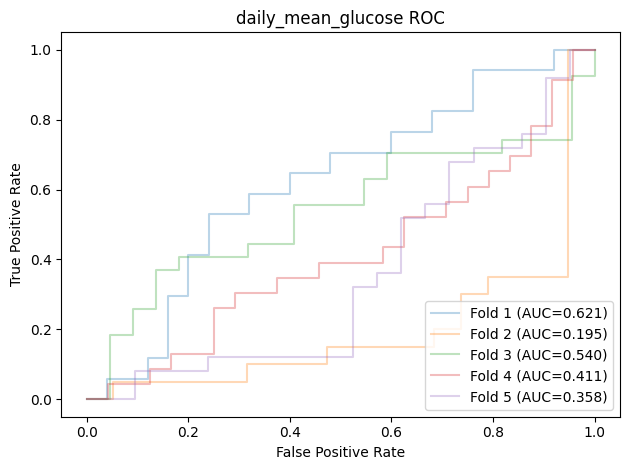

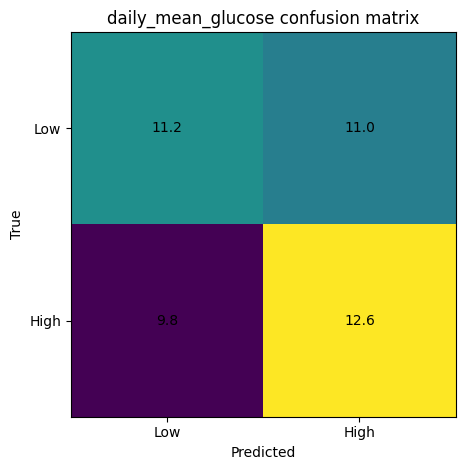

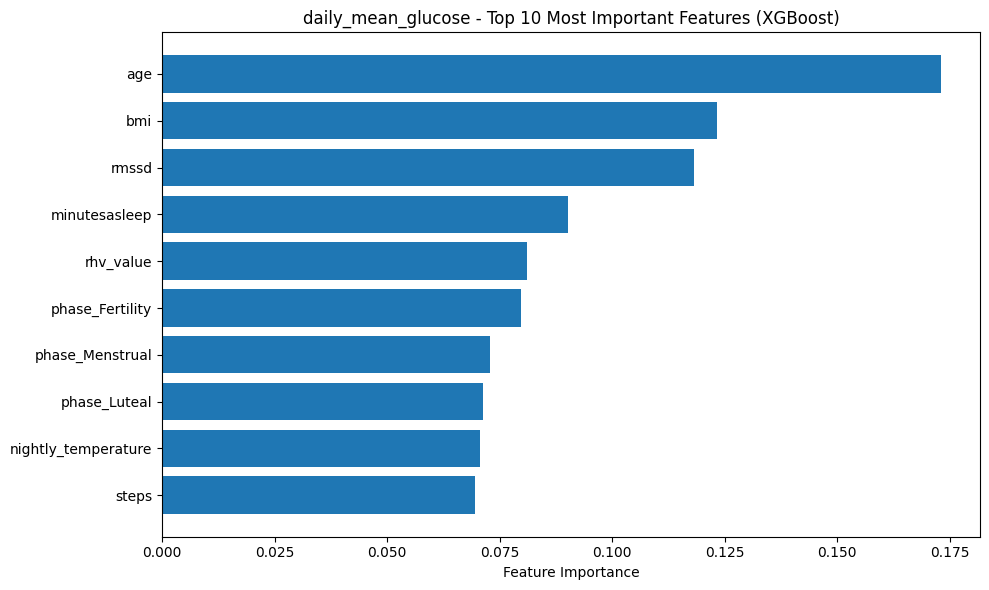

~~~~~~~~~~~~~daily_min_glucose~~~~~~~~~~~~~~~


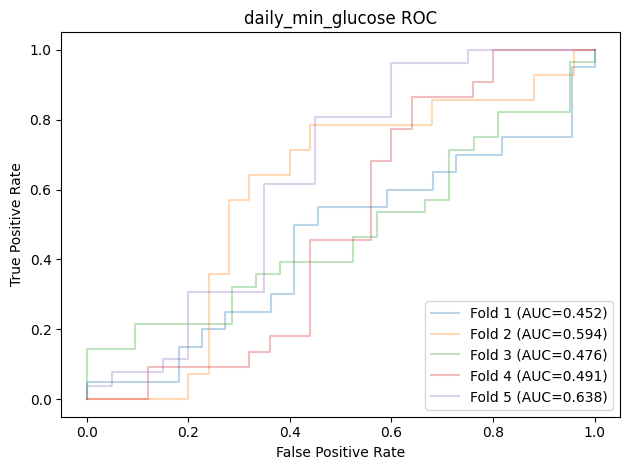

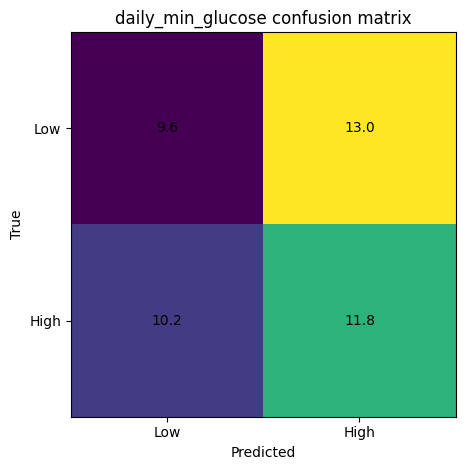

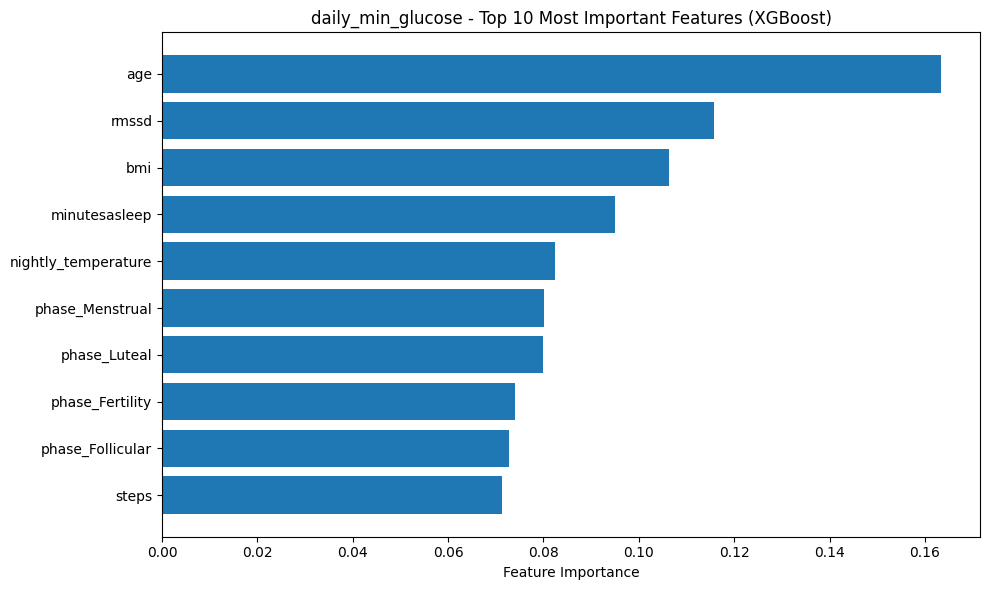

~~~~~~~~~~~~~daily_max_glucose~~~~~~~~~~~~~~~


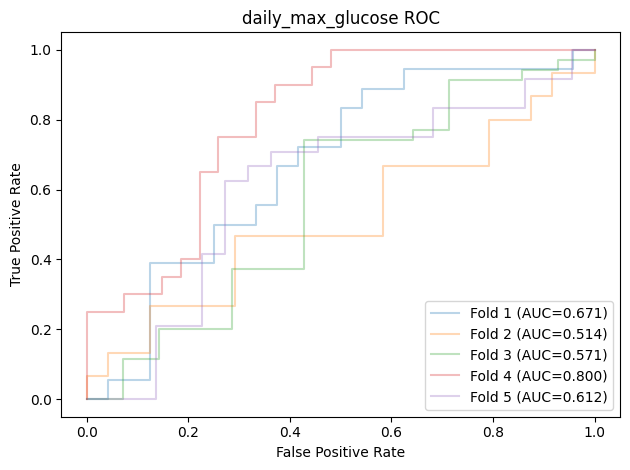

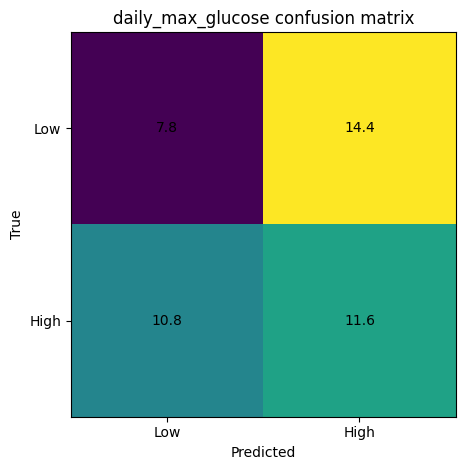

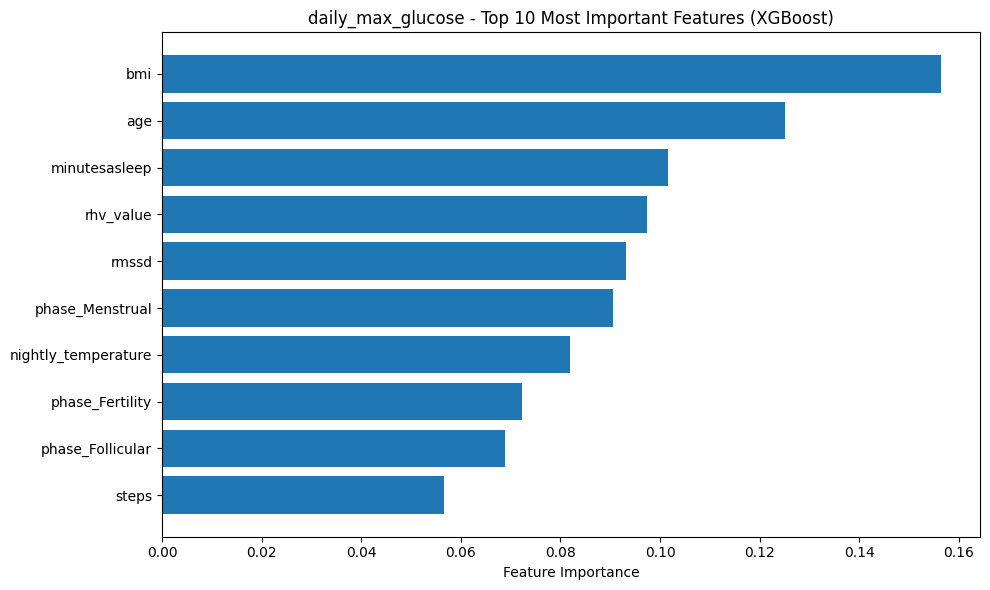

~~~~~~~~~~~~~overnight_mean~~~~~~~~~~~~~~~


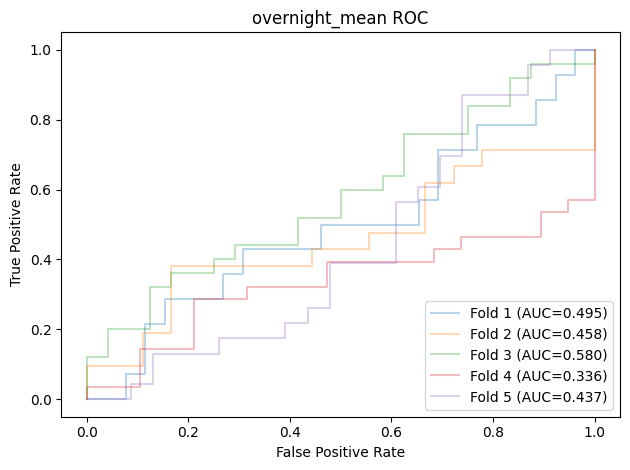

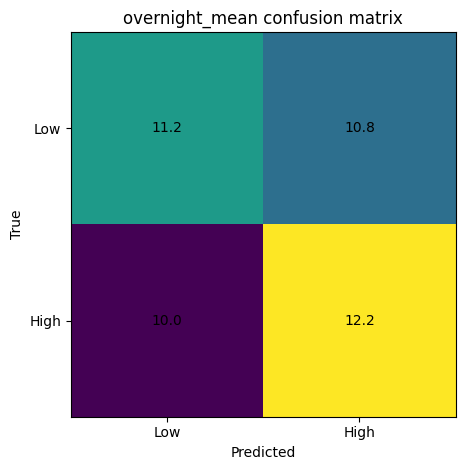

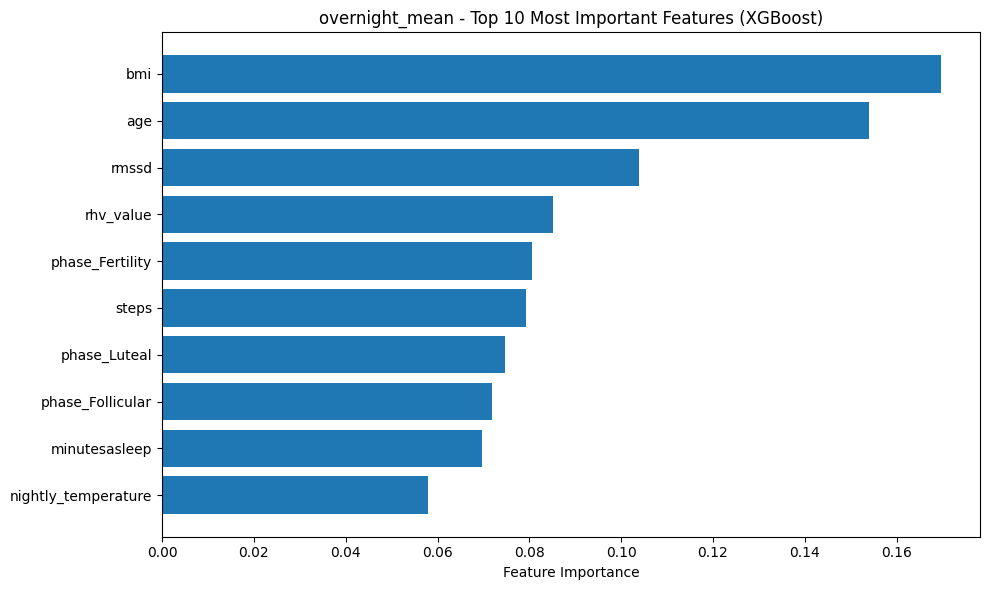

~~~~~~~~~~~~~cv_glucose~~~~~~~~~~~~~~~


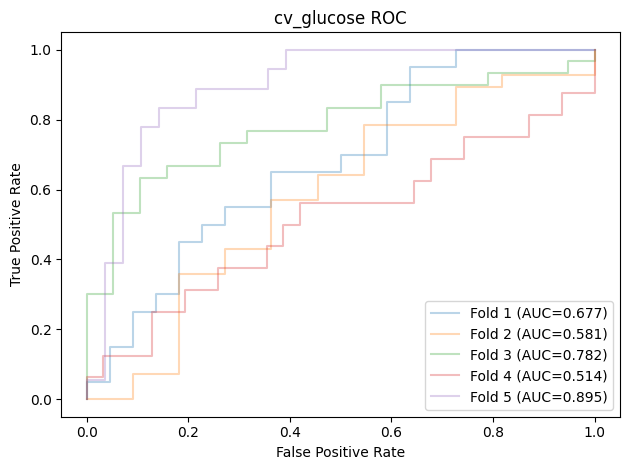

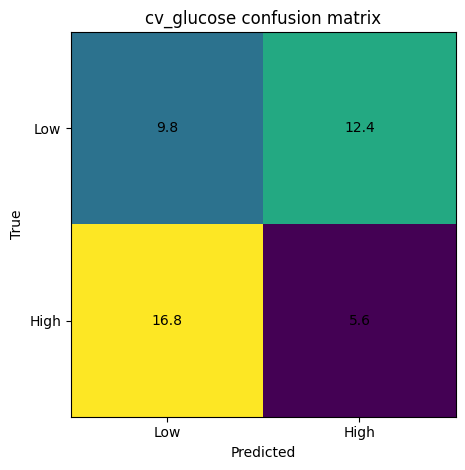

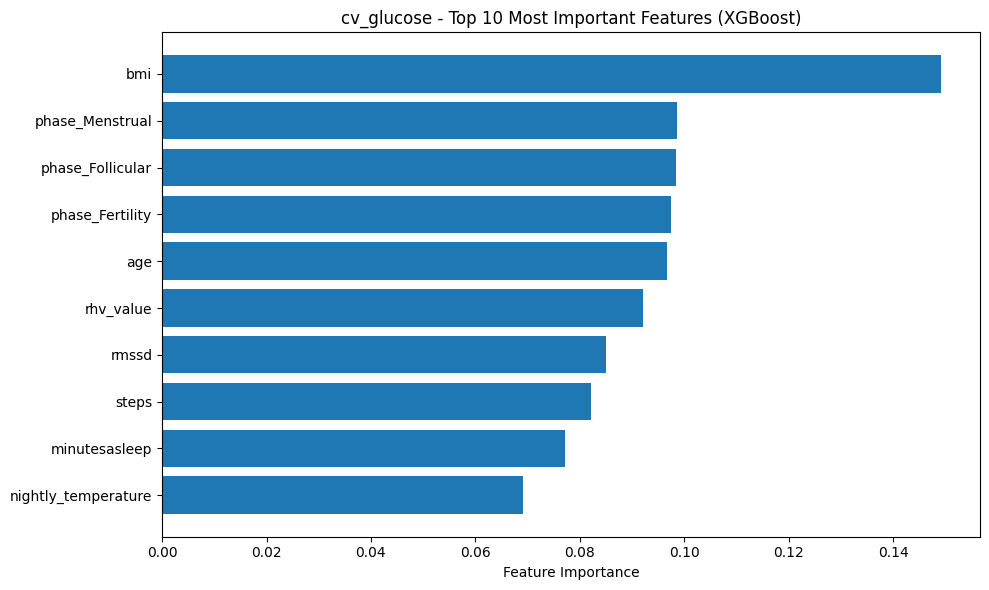

~~~~~~~~~~~~~mage~~~~~~~~~~~~~~~


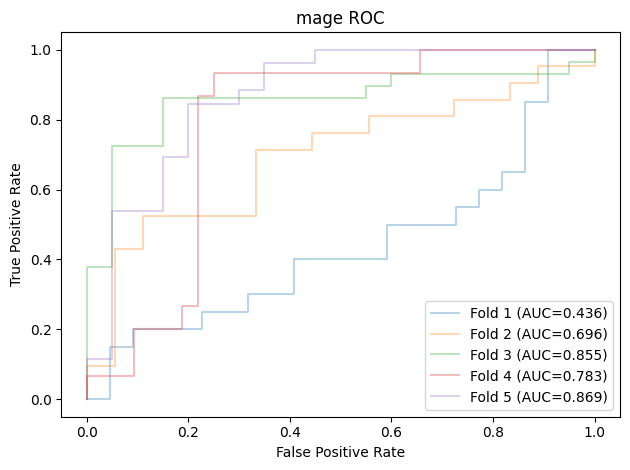

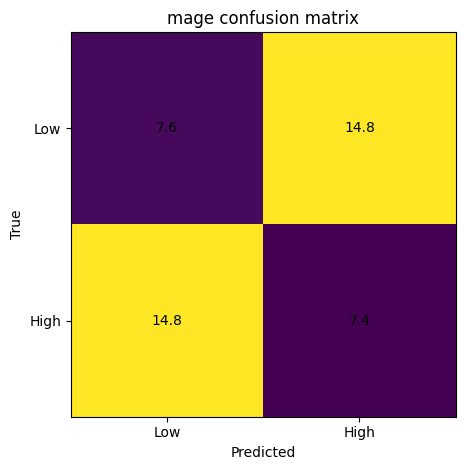

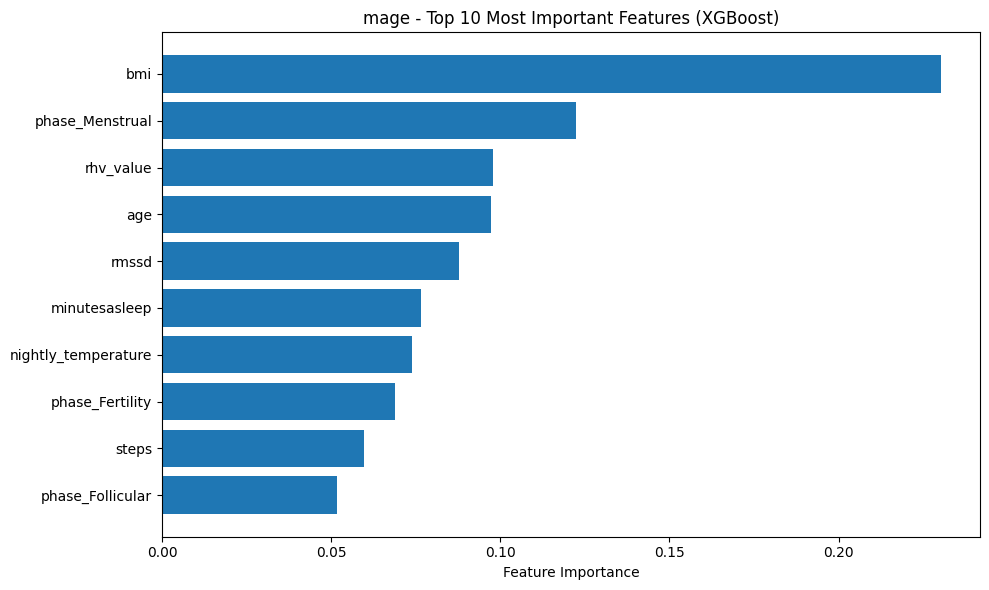

~~~~~~~~~~~~~pp_auc_0_60~~~~~~~~~~~~~~~


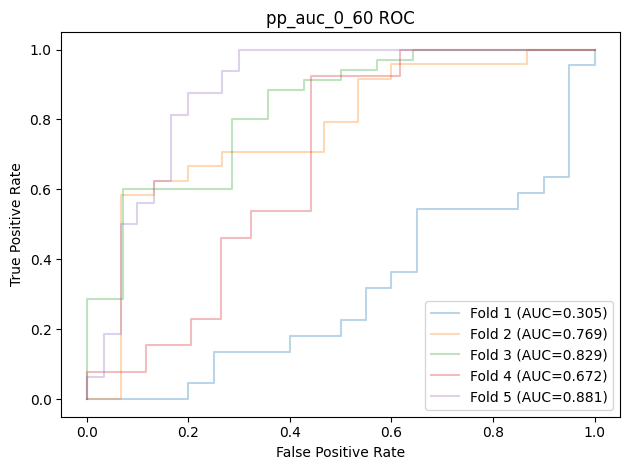

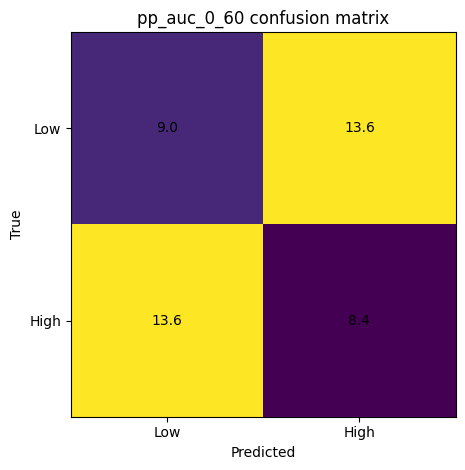

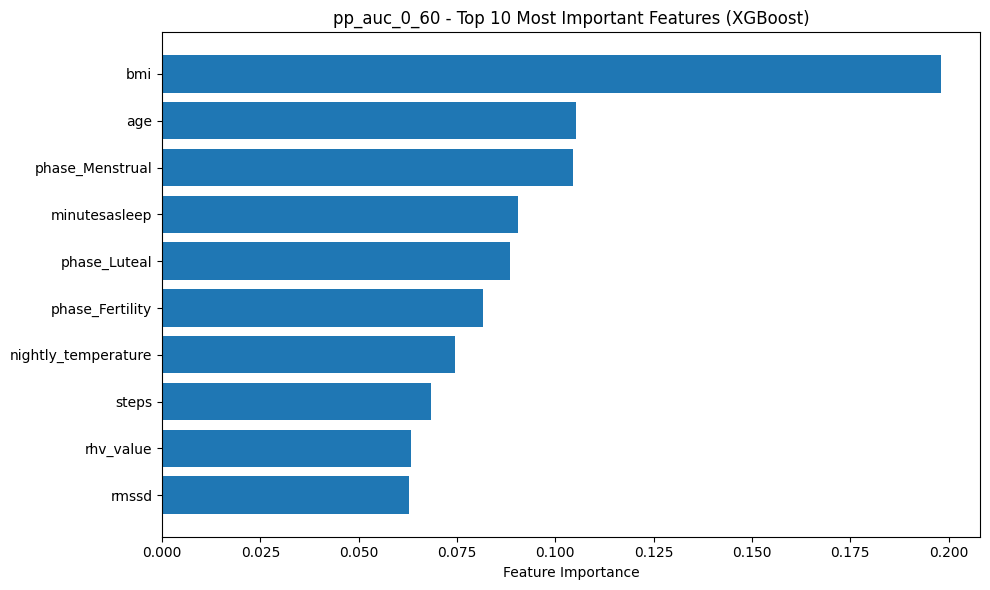

~~~~~~~~~~~~~k_decay~~~~~~~~~~~~~~~


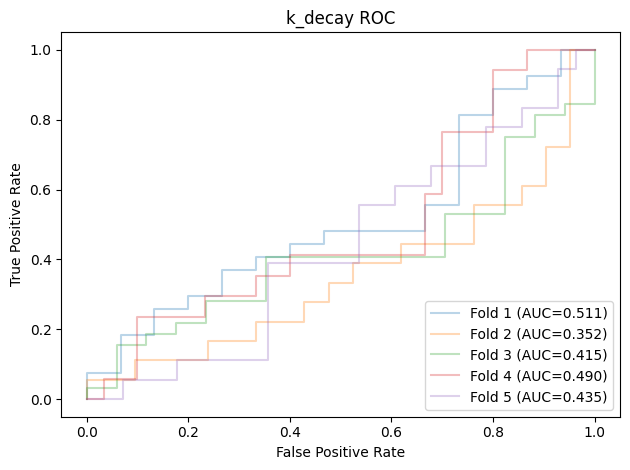

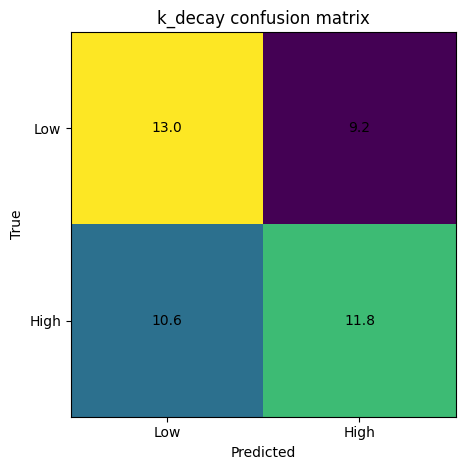

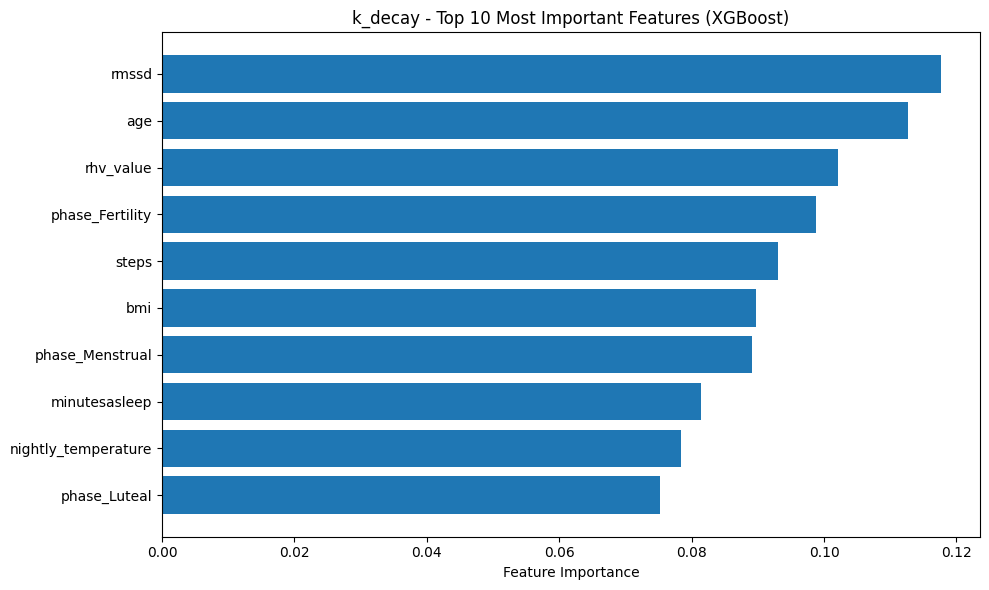

~~~~~~~~~~~~~cremaster_score_daily_global~~~~~~~~~~~~~~~


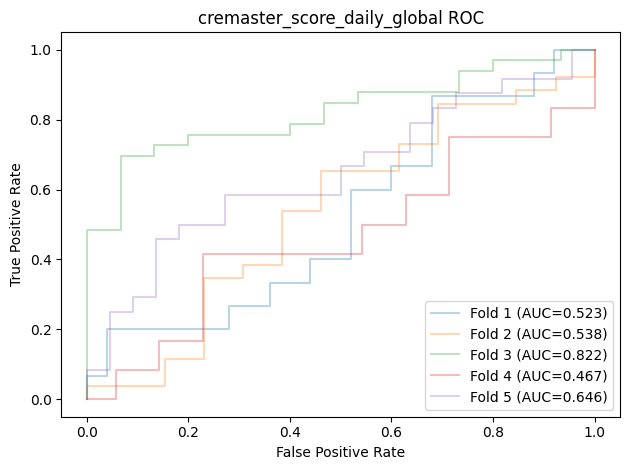

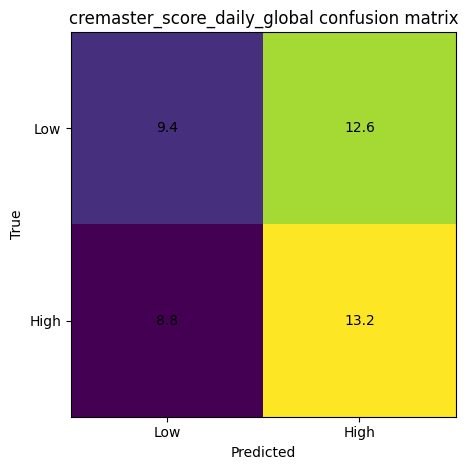

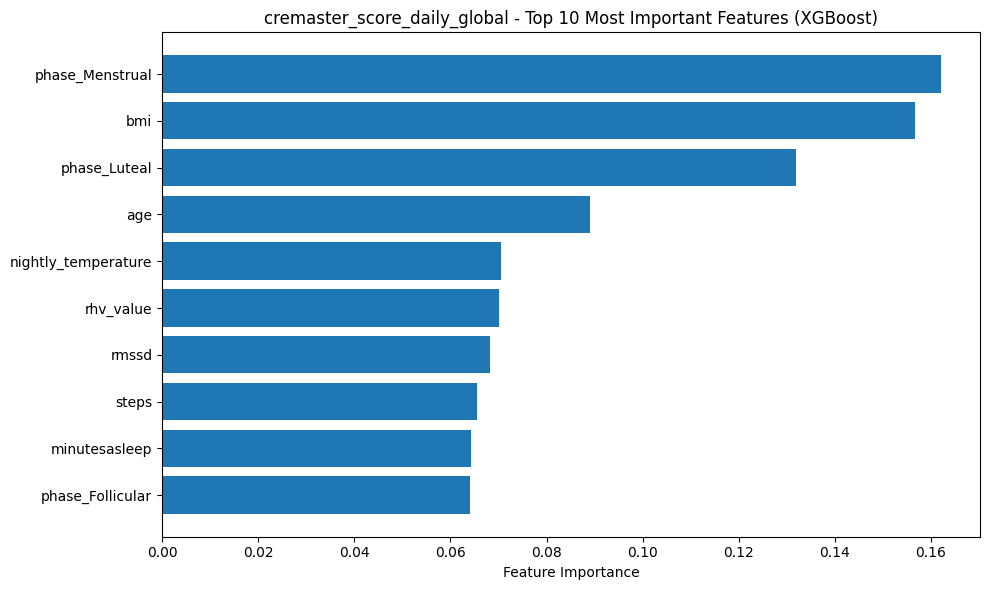

In [ ]:
### UNTUNED

# top_k=10
# eval_cv_results = []
# for y_name in irp_scores:
#   print(f'~~~~~~~~~~~~~{y_name}~~~~~~~~~~~~~~~')
#   y_train_vec = globals()[f"{y_name}_y_train"]
#  # y_test_vec  = globals()[f"{y_name}_y_test"]
#   evals_cv, preprocessor, pipeline, numeric_cols, categorical_cols = get_xgboost_groupkfold(
#         y_name, X_train, y_train_vec, train_df['id']
#     )
#   eval_cv_results.append(evals_cv)

#   # plotting feautures
#   get_feature_names(y_name, preprocessor, pipeline, numeric_cols, categorical_cols)

In [ ]:
# eval_cv_results # UNTUNED
# eval_cv_results_phase_aware = eval_cv_results.copy() # UNTENED

In [ ]:
#eval_cv_results_phase_aware UNTUNED

[['daily_mean_glucose', 0.462, 0.425],
 ['daily_min_glucose', 0.519, 0.53],
 ['daily_max_glucose', 0.57, 0.634],
 ['overnight_mean', 0.471, 0.461],
 ['cv_glucose', 0.652, 0.69],
 ['mage', 0.658, 0.728],
 ['pp_auc_0_60', 0.606, 0.691],
 ['k_decay', 0.444, 0.441],
 ['cremaster_score_daily_global', 0.485, 0.599]]

In [72]:
# Recreate model as phase unaware, and then phase-specific
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# --- your helper unchanged ---
def _bin_high_low(s, q_lo, q_hi):
    out = pd.Series(pd.NA, index=s.index, dtype="object")
    out[s >= q_hi] = "High"
    out[s <  q_lo] = "Low"
    return out

# --- tiny wrapper used ONLY for RandomizedSearchCV ---
class BinnedXGBClassifier(BaseEstimator, ClassifierMixin):
    """Bins continuous y inside fit() using provided quantiles, then fits XGB."""
    def __init__(self, q=(0.5, 0.5),
                 n_estimators=500, learning_rate=0.05, max_depth=6,
                 subsample=0.8, colsample_bytree=0.8,
                 reg_lambda=1.0, reg_alpha=0.0,
                 min_child_weight=1.0, gamma=0.0,
                 random_state=42, n_jobs=-1, eval_metric="logloss"):
        self.q=q; self.n_estimators=n_estimators; self.learning_rate=learning_rate; self.max_depth=max_depth
        self.subsample=subsample; self.colsample_bytree=colsample_bytree
        self.reg_lambda=reg_lambda; self.reg_alpha=reg_alpha
        self.min_child_weight=min_child_weight; self.gamma=gamma
        self.random_state=random_state; self.n_jobs=n_jobs; self.eval_metric=eval_metric
        self._clf=None

    def fit(self, X, y):
        y = pd.Series(pd.to_numeric(y, errors="coerce"), index=getattr(y, "index", None))
        q_lo = np.nanpercentile(y, self.q[0]*100)
        q_hi = np.nanpercentile(y, self.q[1]*100)
        y_lbl = _bin_high_low(y, q_lo, q_hi)
        m = y_lbl.notna()
        X_fit = X.loc[m] if hasattr(X, "loc") else X[m]
        y_fit = (y_lbl.loc[m].values == "High").astype(int)
        self._clf = XGBClassifier(
            n_estimators=self.n_estimators, learning_rate=self.learning_rate, max_depth=self.max_depth,
            subsample=self.subsample, colsample_bytree=self.colsample_bytree,
            reg_lambda=self.reg_lambda, reg_alpha=self.reg_alpha,
            min_child_weight=self.min_child_weight, gamma=self.gamma,
            eval_metric=self.eval_metric, random_state=self.random_state, n_jobs=self.n_jobs
        )
        self._clf.fit(X_fit, y_fit)
        return self

    def predict_proba(self, X):
        p1 = self._clf.predict_proba(X)[:,1]
        return np.column_stack([1-p1, p1])

def get_xgboost_groupkfold(
    y_name, X_train, y_train,  # X_test, y_test,
    groups_train,
    groups_test=None,
    q=(0.5, 0.5),
    n_splits=5,
    need_cols={"age","bmi"},
    tune_n_iter=25,  # <-- random search iterations (adjust as you like)
    random_state=42
):

  # -- columns / preprocessors (unchanged) --
  numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
  categorical_cols = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()

  numeric_pre = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
  categorical_pre = Pipeline(steps=[
      ("imputer", SimpleImputer(strategy="most_frequent")),
      ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
  ])
  preprocessor = ColumnTransformer(
      transformers=[
          ("num", numeric_pre, numeric_cols),
          ("cat", categorical_pre, categorical_cols),
      ],
      remainder="drop",
      sparse_threshold=0.3
  )

  # ---- PREP continuous targets ----
  y_train_cont = pd.to_numeric(pd.Series(y_train), errors="coerce")

  # ---- tune first with RandomizedSearchCV (bins y inside fit, no leakage) ----
  groups_train = pd.Series(groups_train)
  n_groups = groups_train.nunique()
  if n_groups < 2:
      raise ValueError(f"Need at least 2 groups; got {n_groups}.")
  if n_splits > n_groups:
      print(f"⚠️ Reducing n_splits from {n_splits} to {n_groups} to match group count.")
      n_splits = n_groups
  gkf = GroupKFold(n_splits=n_splits)

  tune_pipe = Pipeline(steps=[
      ("prep", preprocessor),
      ("model", BinnedXGBClassifier(q=q, random_state=random_state))
  ])

  # simple, sensible search space
  param_distributions = {
      "model__n_estimators":     np.arange(300, 1201, 100),
      "model__learning_rate":    np.logspace(-3, -0.3, 20),
      "model__max_depth":        np.arange(3, 11),
      "model__subsample":        np.linspace(0.6, 1.0, 9),
      "model__colsample_bytree": np.linspace(0.5, 1.0, 11),
      "model__reg_lambda":       np.logspace(-2, 2, 9),
      "model__reg_alpha":        np.logspace(-3, 1, 9),
      "model__min_child_weight": np.logspace(-1, 2, 10),
      "model__gamma":            np.logspace(-3, 1, 9),
  }

  search = RandomizedSearchCV(
      estimator=tune_pipe,
      param_distributions=param_distributions,
      n_iter=tune_n_iter,
      scoring="roc_auc",
      cv=gkf,
      n_jobs=-1,
      random_state=random_state,
      verbose=1,
      refit=True
  )
  search.fit(X_train, y_train_cont, groups=groups_train)

  # extract best params for plain XGBClassifier
  best_params = {k.replace("model__",""): v for k, v in search.best_params_.items()}
  print(f"\n[{y_name}] Best CV AUC (RandomizedSearchCV): {search.best_score_:.3f}")
  print(f"[{y_name}] Best params:", best_params)

  # ---- rebuild your original pipeline with tuned params ----
  clf = XGBClassifier(
      eval_metric="logloss", random_state=random_state, n_jobs=-1,
      **best_params
  )
  pipeline = Pipeline(steps=[("prep", preprocessor), ("model", clf)])

  # ---- your original GroupKFold per-fold loop (unchanged; leakage-safe) ----
  cv_accs, cv_aucs, cms = [], [], []

  # Store all predictions for overall ROC curve
  all_y_true = []
  all_y_proba = []

  if not need_cols.issubset(X_train.columns):
      print(f"⚠️ Missing columns for overlap check. Expected {need_cols}, have {set(X_train.columns)}")

  for fold, (tr_idx, va_idx) in enumerate(gkf.split(X_train, y_train_cont, groups=groups_train), start=1):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr_c, y_va_c = y_train_cont.iloc[tr_idx], y_train_cont.iloc[va_idx]

    # thresholds from *training split only*
    q_lo = np.nanpercentile(y_tr_c, q[0]*100)
    q_hi = np.nanpercentile(y_tr_c, q[1]*100)

    y_tr_lbl = _bin_high_low(y_tr_c, q_lo, q_hi)
    y_va_lbl = _bin_high_low(y_va_c, q_lo, q_hi)

    # drop NA in labels and align X
    tr_mask = y_tr_lbl.notna()
    va_mask = y_va_lbl.notna()
    X_tr_c  = X_tr.loc[tr_mask]
    y_tr_l  = y_tr_lbl.loc[tr_mask]
    X_va_c  = X_va.loc[va_mask]
    y_va_l  = y_va_lbl.loc[va_mask]

    # encode labels
    le = LabelEncoder()
    y_tr_enc = le.fit_transform(y_tr_l.values)
    y_va_enc = le.transform(y_va_l.values)

    # skip fold if only one class after binning
    if len(np.unique(y_tr_enc)) < 2 or len(np.unique(y_va_enc)) < 2:
        print(f"Fold {fold}: ⚠️ skipped (only one class after binning).")
        continue

    pipeline.fit(X_tr_c, y_tr_enc)

    # metrics
    y_pred = pipeline.predict(X_va_c)
    acc = accuracy_score(y_va_enc, y_pred)

    pos_idx = list(le.classes_).index("High") if "High" in le.classes_ else 1 if len(le.classes_)>1 else 0
    proba = pipeline.predict_proba(X_va_c)[:, pos_idx]
    y_true01 = (y_va_enc == pos_idx).astype(int)
    auc = roc_auc_score(y_true01, proba)

    fpr, tpr, _ = roc_curve(y_true01, proba)
    cv_accs.append(acc)
    cv_aucs.append(auc)

    cm = confusion_matrix(y_true01, y_pred, labels=[0,1])  # [[TN, FP],[FN, TP]]
    cms.append(cm)

    # Store for overall ROC curve
    all_y_true.extend(y_true01)
    all_y_proba.extend(proba)

    # roc curve per fold
    plt.plot(fpr, tpr, alpha=0.3, label=f"Fold {fold} (AUC={auc:.3f})")

  # Plot overall ROC curve
  if len(all_y_true) > 0:
    overall_fpr, overall_tpr, _ = roc_curve(all_y_true, all_y_proba)
    overall_auc = roc_auc_score(all_y_true, all_y_proba)
    plt.plot(overall_fpr, overall_tpr, color='blue', linewidth=2.5,
             label=f"Overall (AUC={overall_auc:.3f})", alpha=0.9)




  cv_summary = {
      "cv_accuracy_mean": float(np.nanmean(cv_accs)) if len(cv_accs) else np.nan,
      "cv_auc_mean":      float(np.nanmean(cv_aucs)) if len(cv_aucs) else np.nan,
      "cv_accuracy_std":  float(np.nanstd(cv_accs))  if len(cv_accs) else np.nan,
      "cv_auc_std":       float(np.nanstd(cv_aucs))  if len(cv_aucs) else np.nan
  }
  evals_cv = [y_name,
              None if np.isnan(cv_summary["cv_accuracy_mean"]) else round(cv_summary["cv_accuracy_mean"],3),
              None if np.isnan(cv_summary["cv_auc_mean"]) else round(cv_summary["cv_auc_mean"],3)]

  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f'{y_name} ROC (tuned)')
  plt.legend(loc="lower right")
  plt.tight_layout()
  plt.show()

  cm_sum = np.sum(cms, axis=0) if len(cms) else np.array([[0,0],[0,0]])
  cm_mean = cm_sum / n_splits
  plt.figure()
  plt.imshow(cm_mean, interpolation='nearest')
  plt.title(f'{y_name} confusion matrix (tuned)')
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.xticks([0,1], ["Low","High"])
  plt.yticks([0,1], ["Low","High"])
  for i in range(cm_mean.shape[0]):
      for j in range(cm_mean.shape[1]):
          plt.text(j, i, f"{cm_mean[i, j]:.1f}", ha='center', va='center')
  plt.tight_layout()
  plt.show()

  return evals_cv, preprocessor, pipeline, numeric_cols, categorical_cols


~~~~~~~~~~~~~daily_mean_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[daily_mean_glucose] Best CV AUC (RandomizedSearchCV): nan
[daily_mean_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


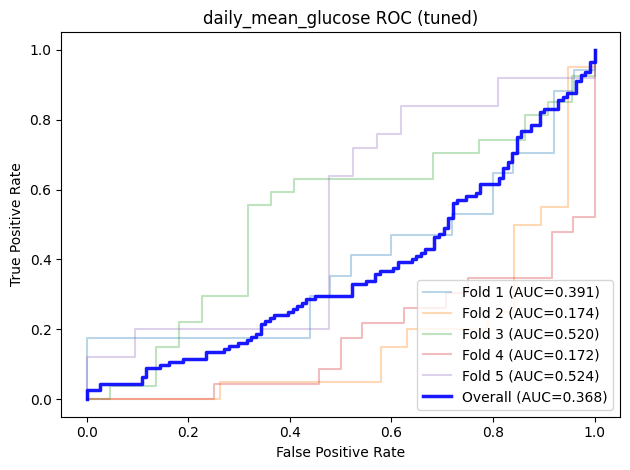

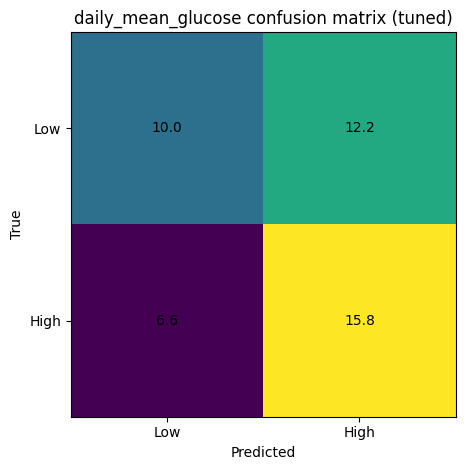

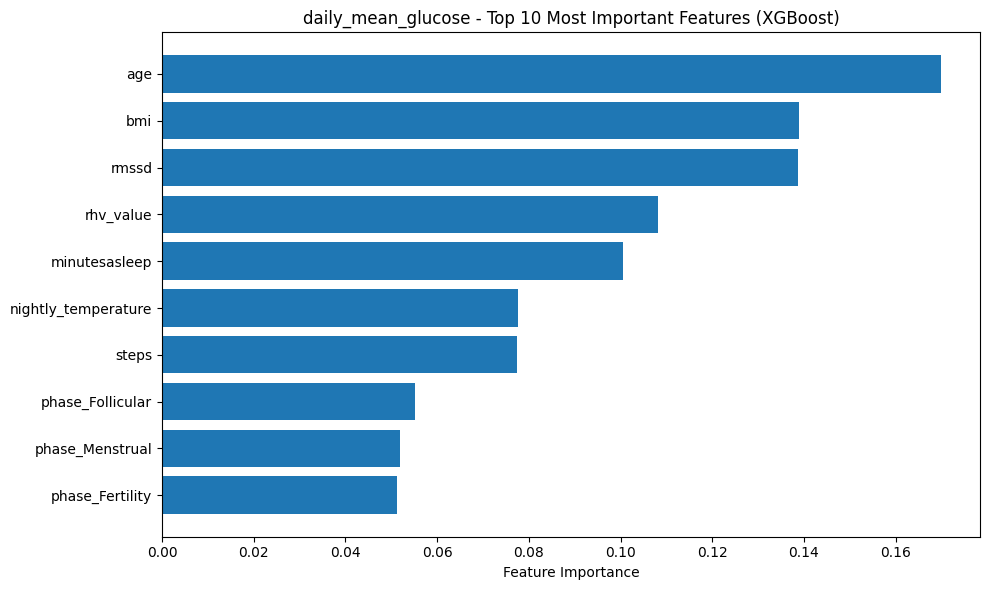

~~~~~~~~~~~~~daily_min_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[daily_min_glucose] Best CV AUC (RandomizedSearchCV): nan
[daily_min_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


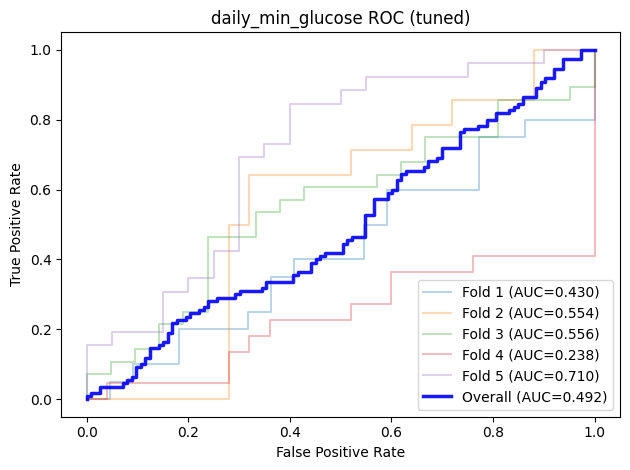

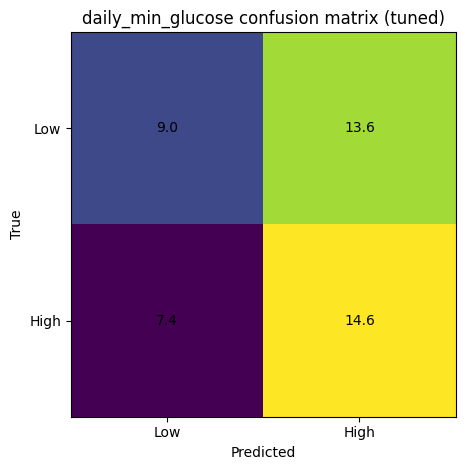

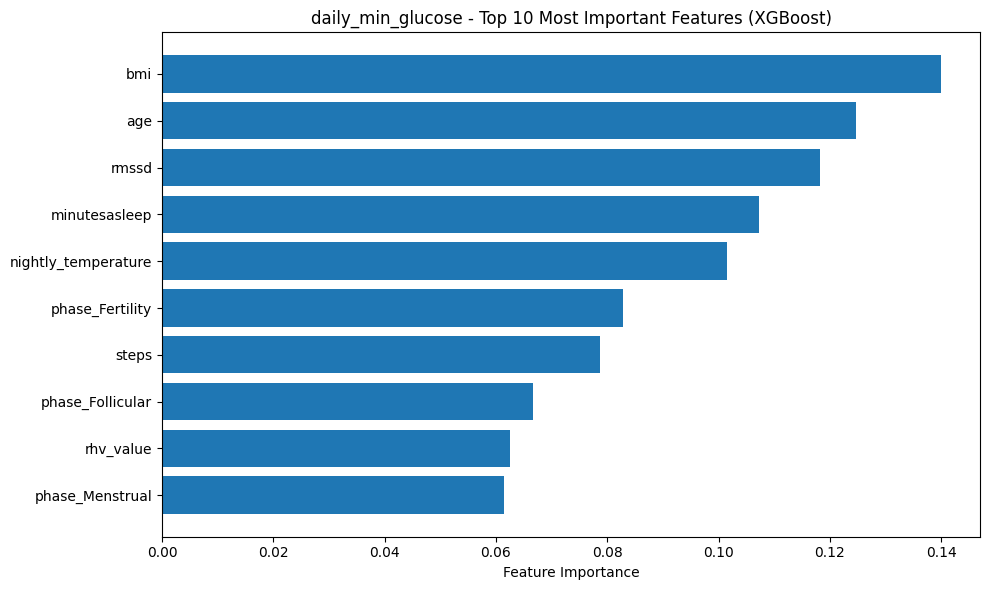

~~~~~~~~~~~~~daily_max_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[daily_max_glucose] Best CV AUC (RandomizedSearchCV): nan
[daily_max_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


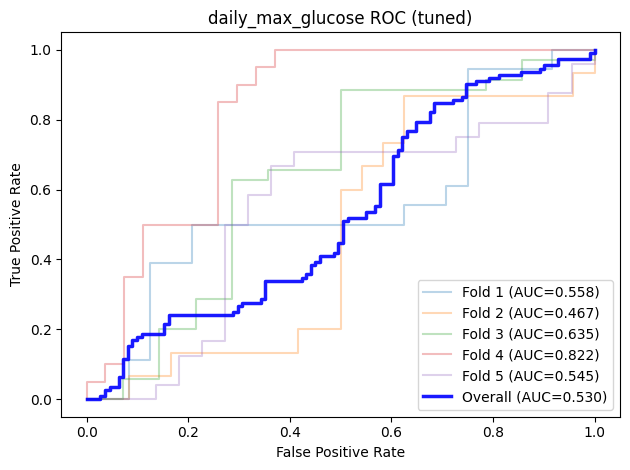

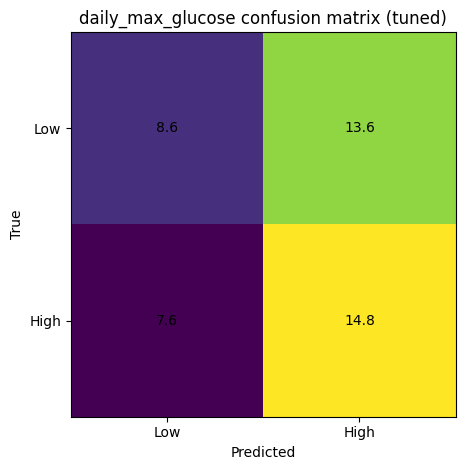

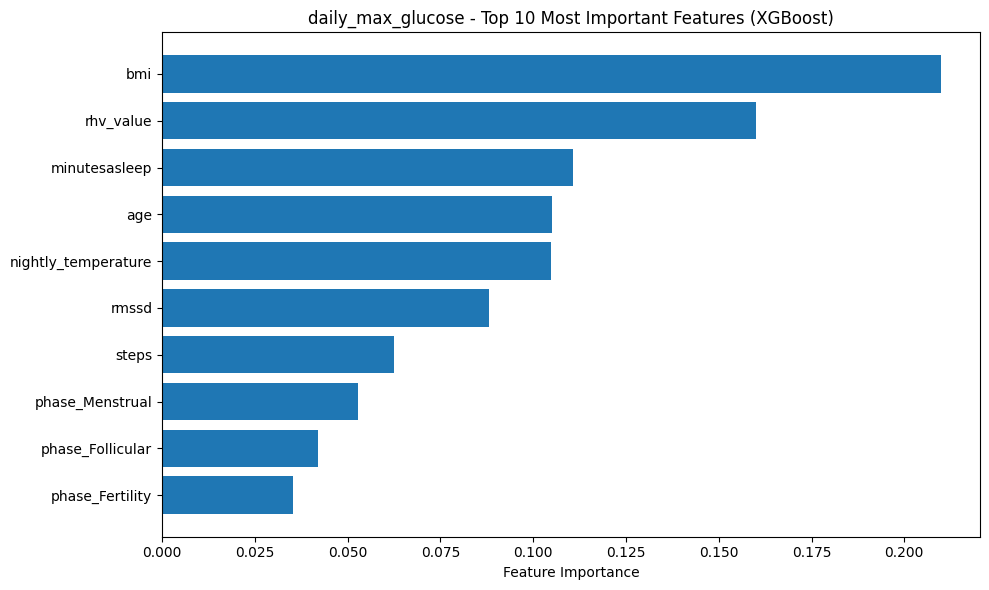

~~~~~~~~~~~~~overnight_mean~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[overnight_mean] Best CV AUC (RandomizedSearchCV): nan
[overnight_mean] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


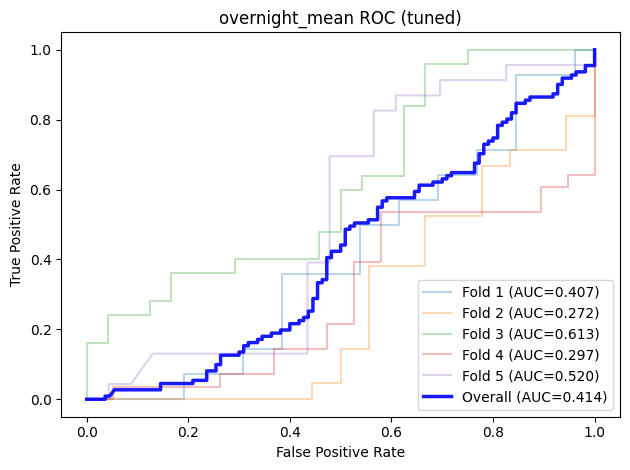

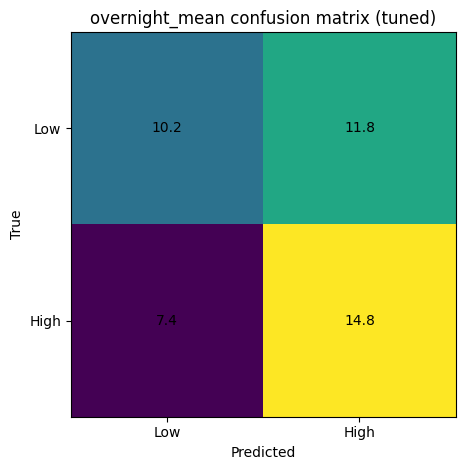

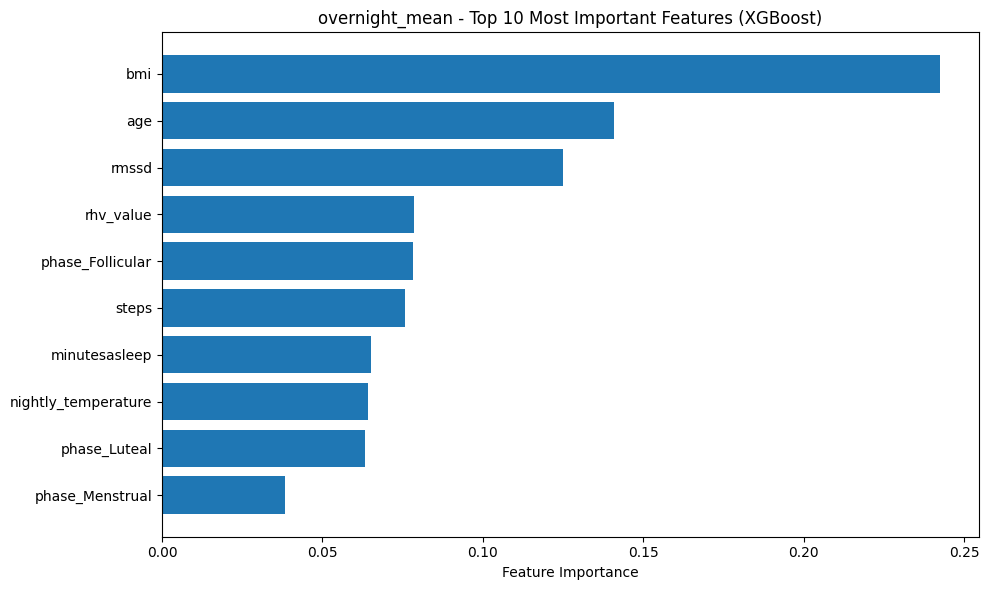

~~~~~~~~~~~~~cv_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[cv_glucose] Best CV AUC (RandomizedSearchCV): nan
[cv_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


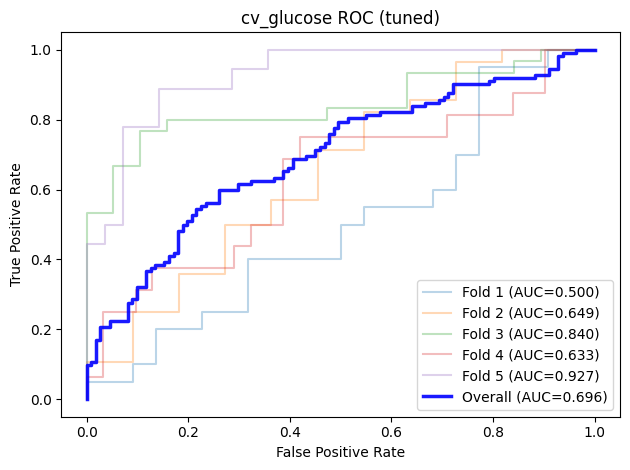

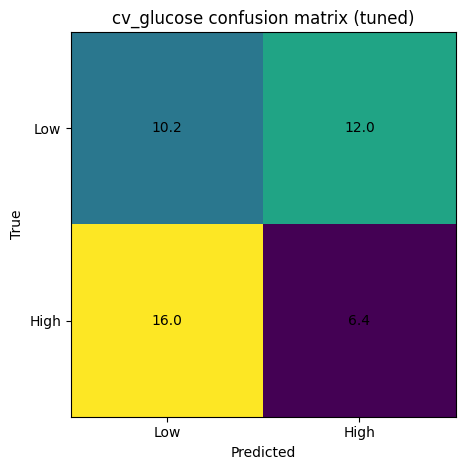

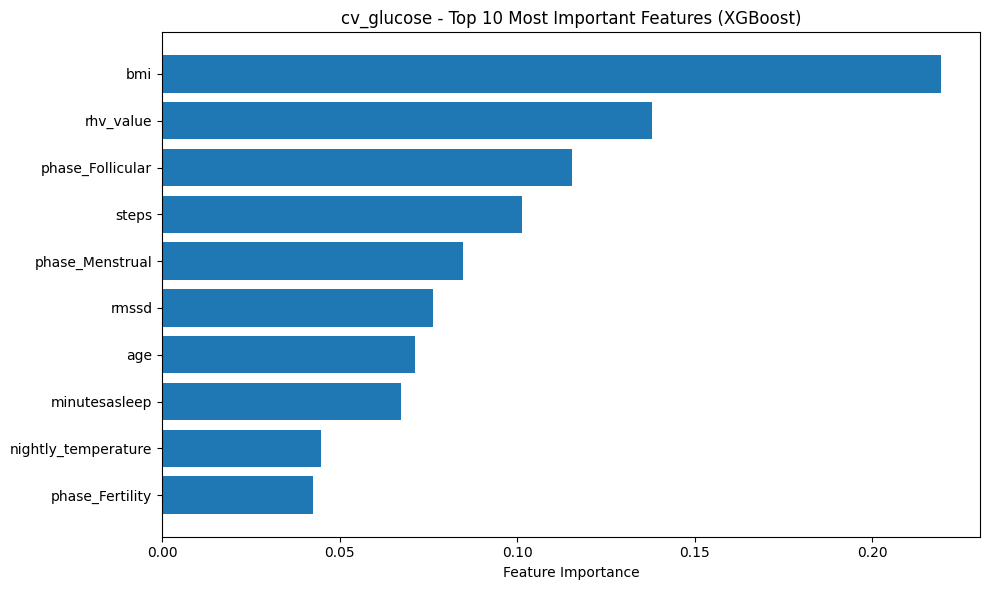

~~~~~~~~~~~~~mage~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[mage] Best CV AUC (RandomizedSearchCV): nan
[mage] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


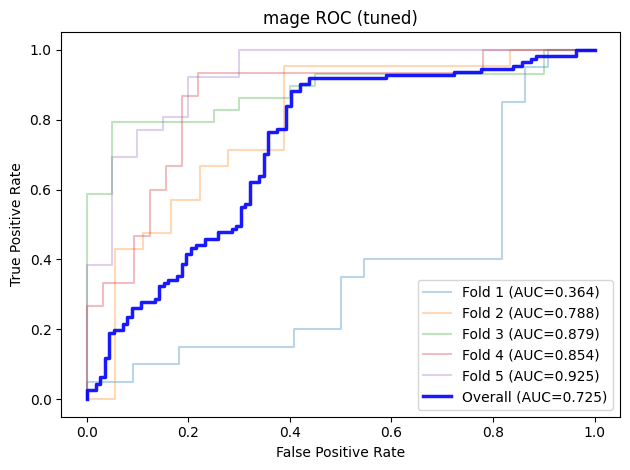

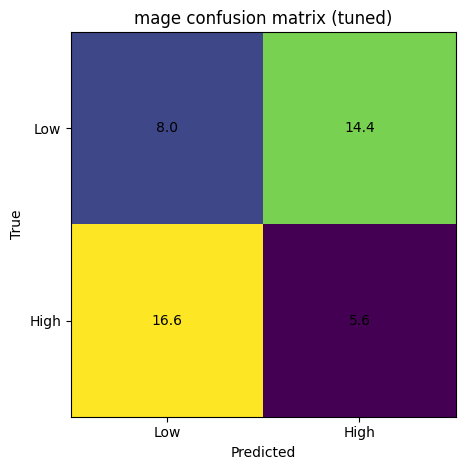

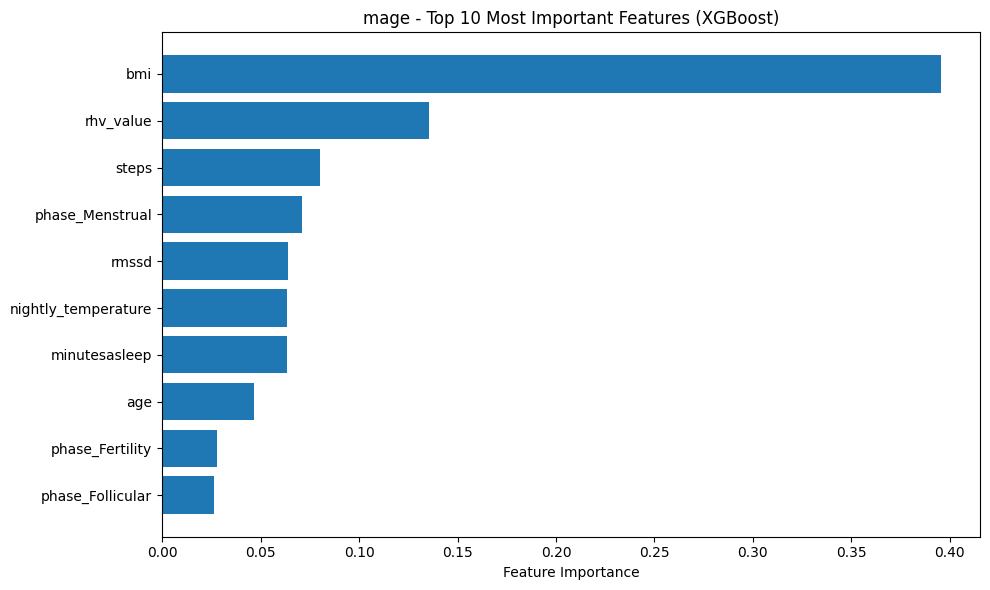

~~~~~~~~~~~~~pp_auc_0_60~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[pp_auc_0_60] Best CV AUC (RandomizedSearchCV): nan
[pp_auc_0_60] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


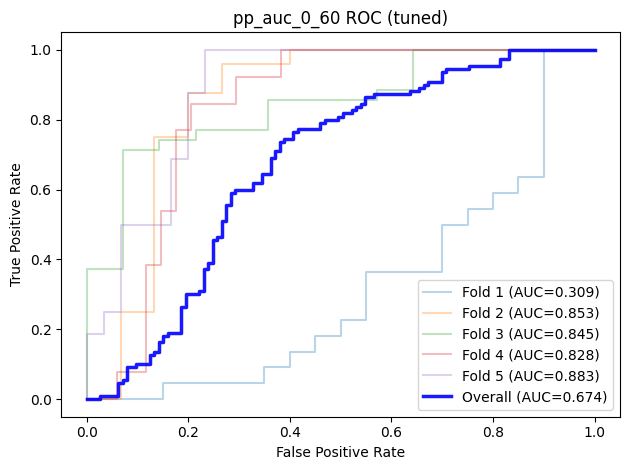

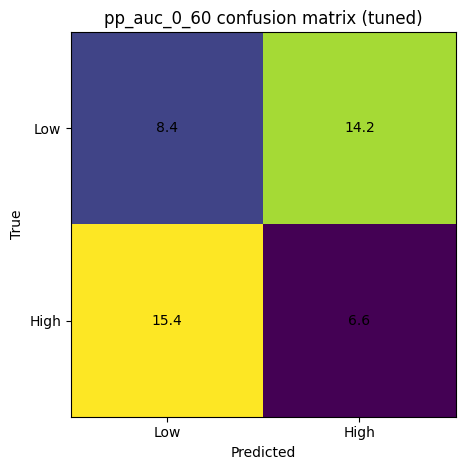

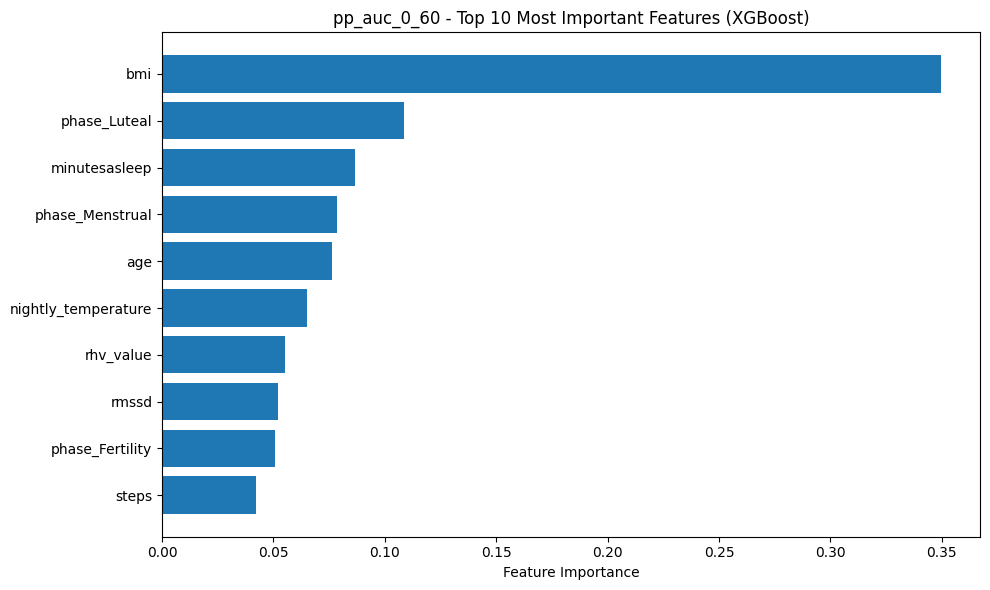

~~~~~~~~~~~~~k_decay~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[k_decay] Best CV AUC (RandomizedSearchCV): nan
[k_decay] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


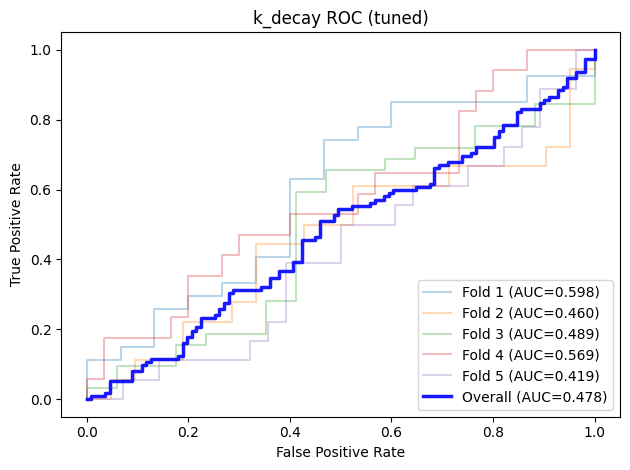

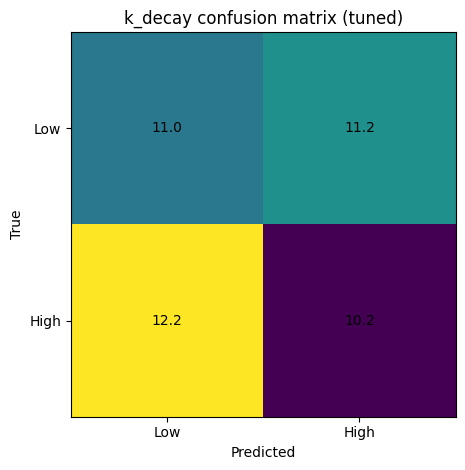

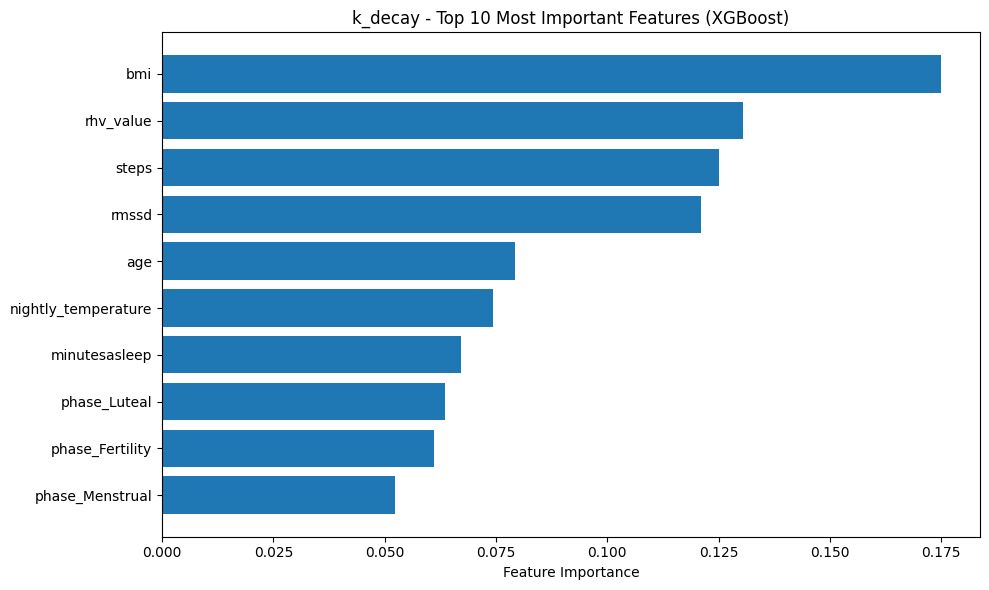

~~~~~~~~~~~~~cremaster_score_daily_global~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[cremaster_score_daily_global] Best CV AUC (RandomizedSearchCV): nan
[cremaster_score_daily_global] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


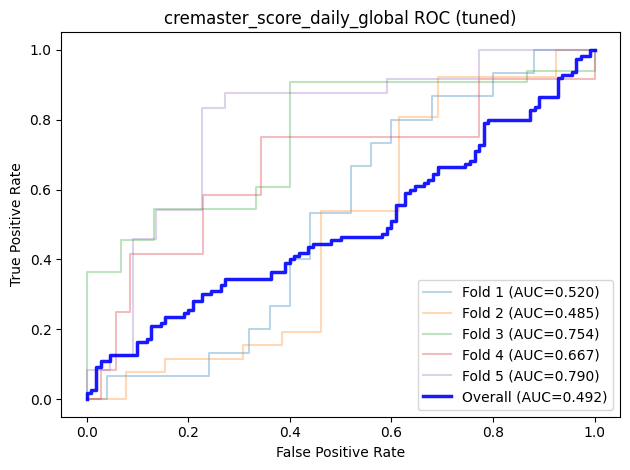

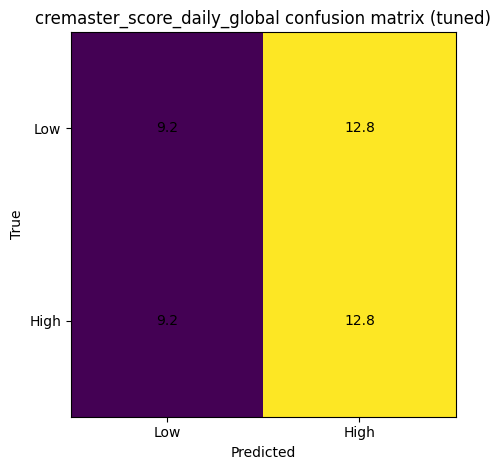

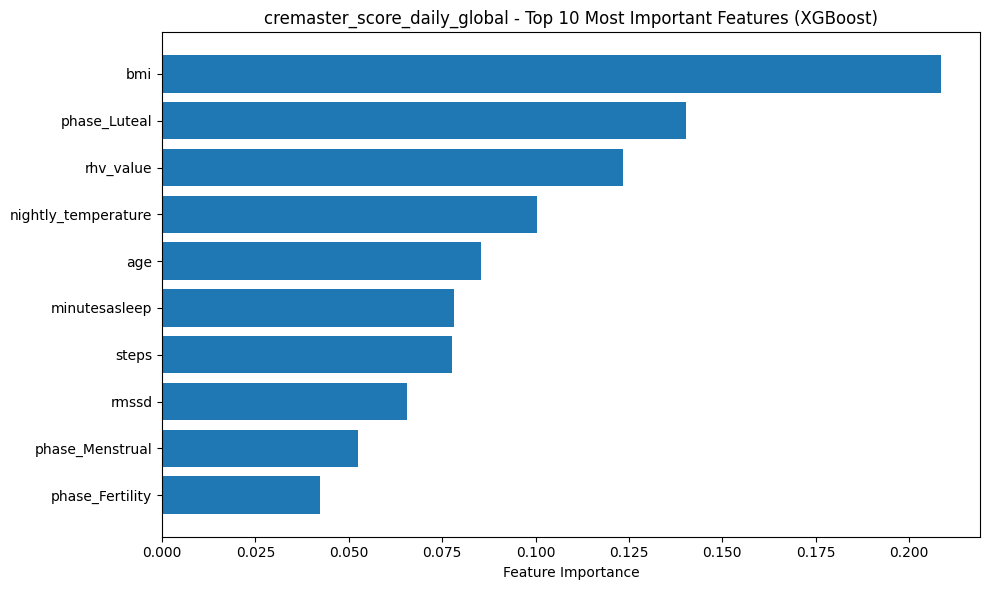

In [73]:
top_k=10
eval_cv_results = []
for y_name in irp_scores:
  print(f'~~~~~~~~~~~~~{y_name}~~~~~~~~~~~~~~~')
  y_train_vec = globals()[f"{y_name}_y_train"]
 # y_test_vec  = globals()[f"{y_name}_y_test"]
  evals_cv, preprocessor, pipeline, numeric_cols, categorical_cols = get_xgboost_groupkfold(
    y_name, X_train, y_train_vec,
    groups_train=train_df.loc[X_train.index, "id"],
    q=(0.5, 0.5),
    n_splits=5,
    tune_n_iter=25  # bump up if you want
)
  eval_cv_results.append(evals_cv)

  # plotting feautures
  get_feature_names(y_name, preprocessor, pipeline, numeric_cols, categorical_cols)




In [74]:
eval_cv_results
eval_cv_results_phase_aware = eval_cv_results.copy()

In [75]:
eval_cv_results_phase_aware

[['daily_mean_glucose', 0.42, 0.356],
 ['daily_min_glucose', 0.476, 0.498],
 ['daily_max_glucose', 0.474, 0.605],
 ['overnight_mean', 0.426, 0.422],
 ['cv_glucose', 0.623, 0.71],
 ['mage', 0.694, 0.762],
 ['pp_auc_0_60', 0.656, 0.744],
 ['k_decay', 0.529, 0.507],
 ['cremaster_score_daily_global', 0.497, 0.643]]

PHASE UNAWARE

In [76]:
# Phase unaware
# remove phase data from the dataset
X_train_phase_unaware = X_train.drop(columns=['phase'])
# check columns after
print(X_train_phase_unaware.columns)

Index(['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep',
       'nightly_temperature', 'bmi'],
      dtype='object')


~~~~~~~~~~~~~daily_mean_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[daily_mean_glucose] Best CV AUC (RandomizedSearchCV): nan
[daily_mean_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


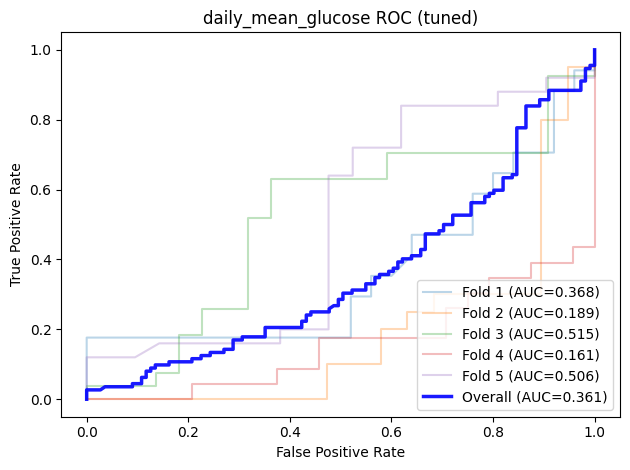

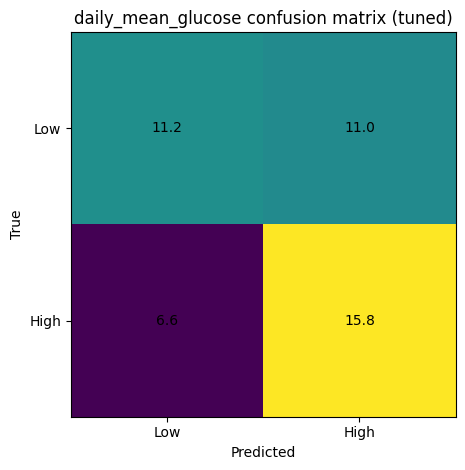

num ['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi']
cat []


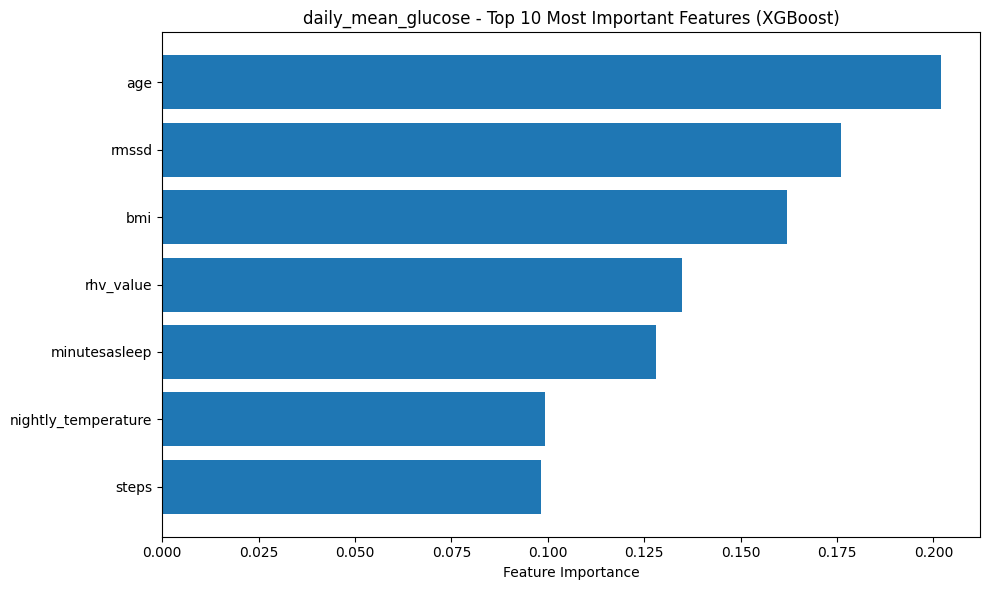

~~~~~~~~~~~~~daily_min_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[daily_min_glucose] Best CV AUC (RandomizedSearchCV): nan
[daily_min_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


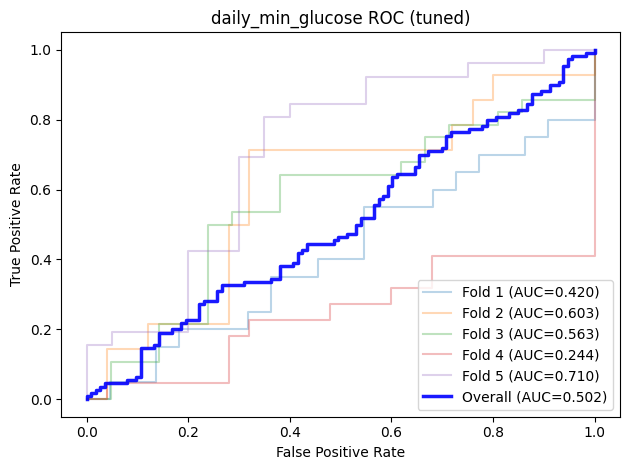

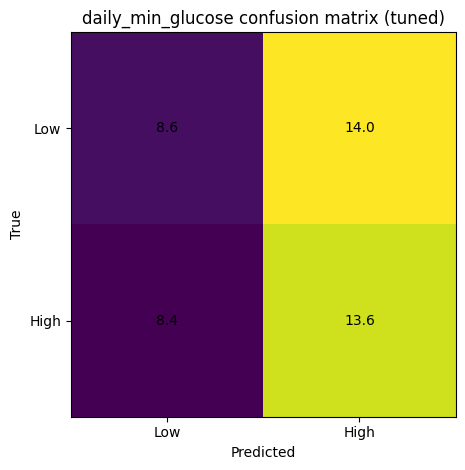

num ['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi']
cat []


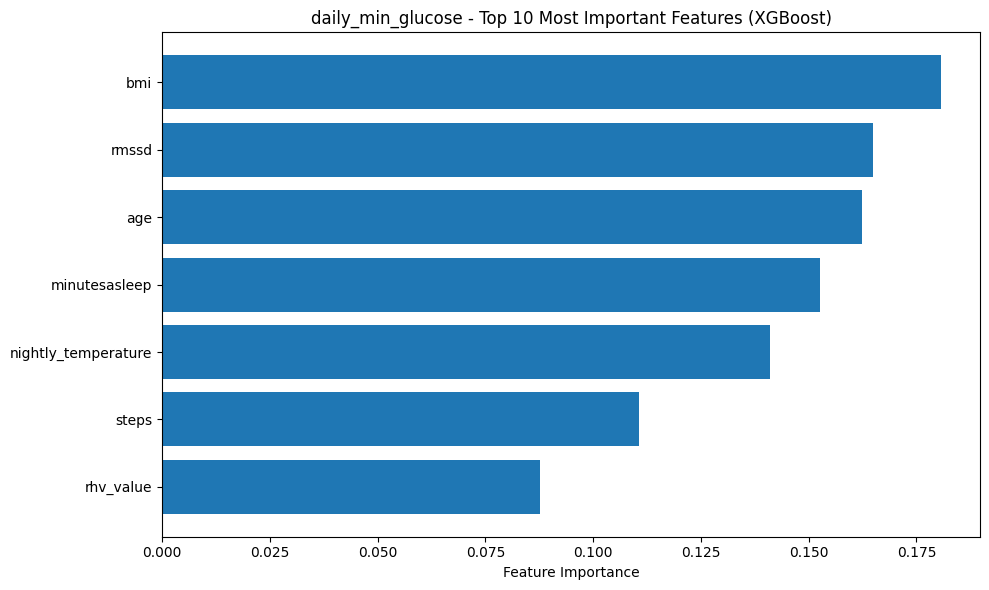

~~~~~~~~~~~~~daily_max_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[daily_max_glucose] Best CV AUC (RandomizedSearchCV): nan
[daily_max_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


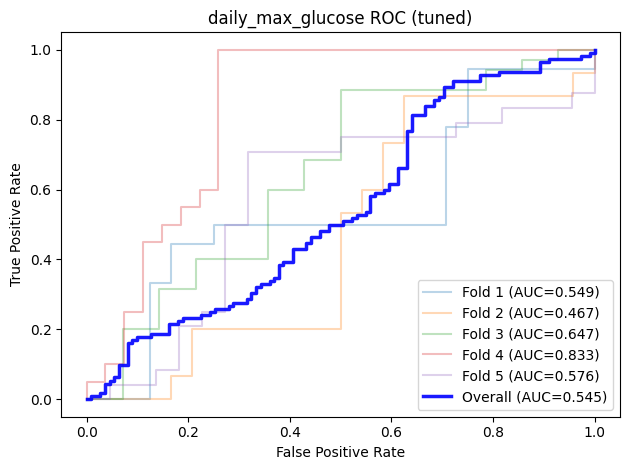

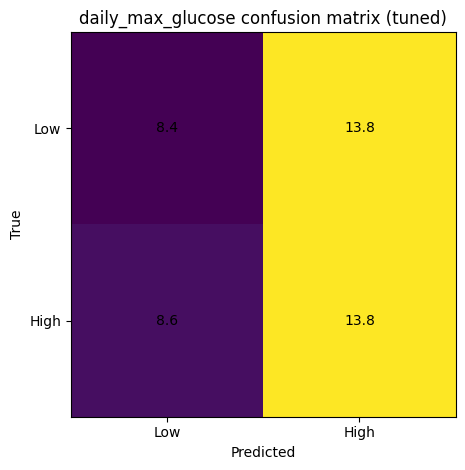

num ['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi']
cat []


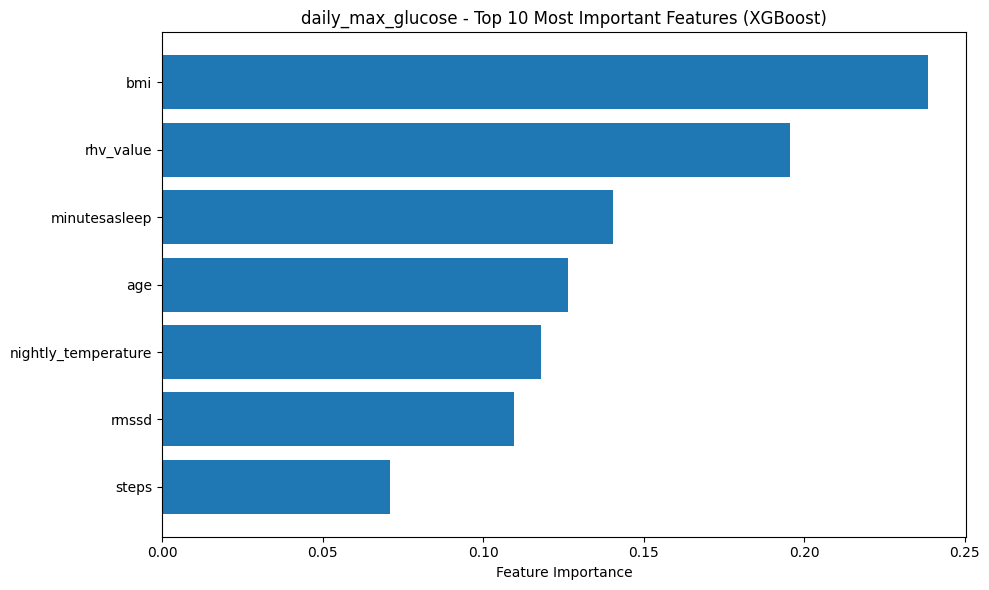

~~~~~~~~~~~~~overnight_mean~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[overnight_mean] Best CV AUC (RandomizedSearchCV): nan
[overnight_mean] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


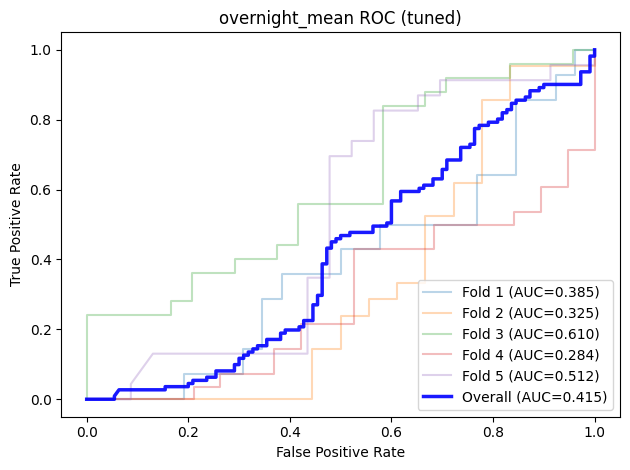

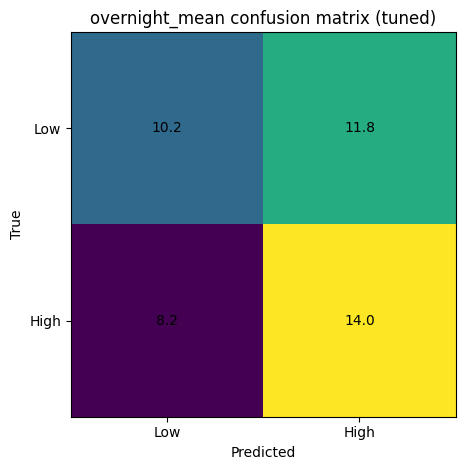

num ['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi']
cat []


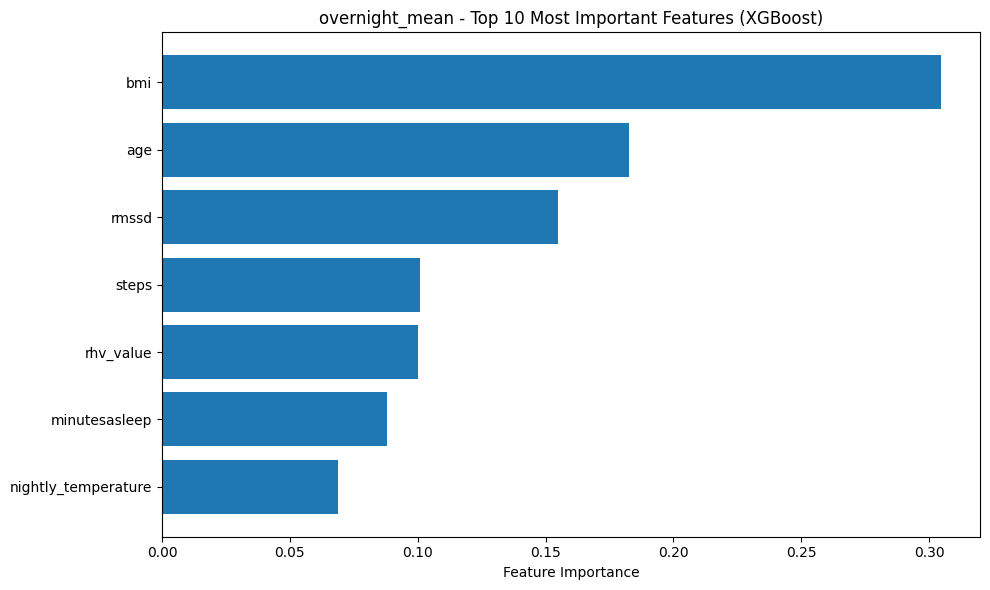

~~~~~~~~~~~~~cv_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[cv_glucose] Best CV AUC (RandomizedSearchCV): nan
[cv_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


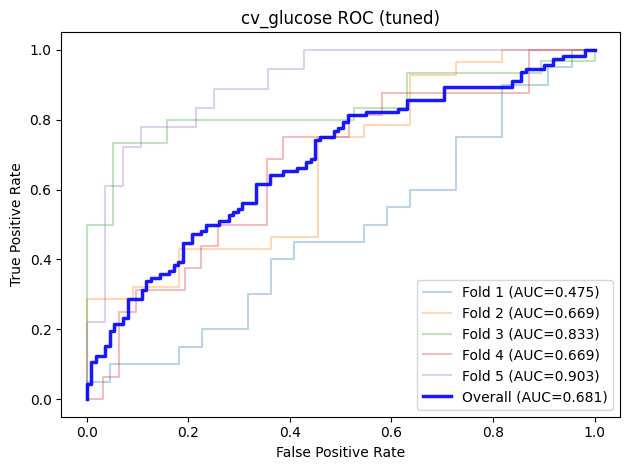

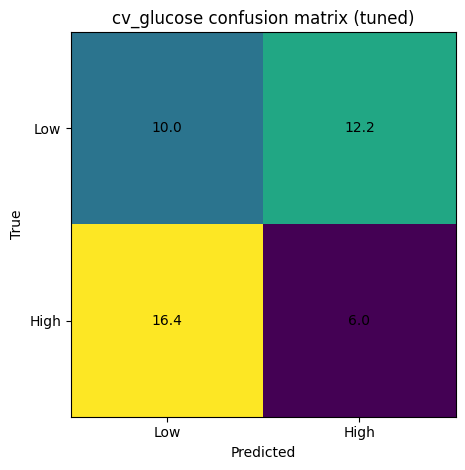

num ['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi']
cat []


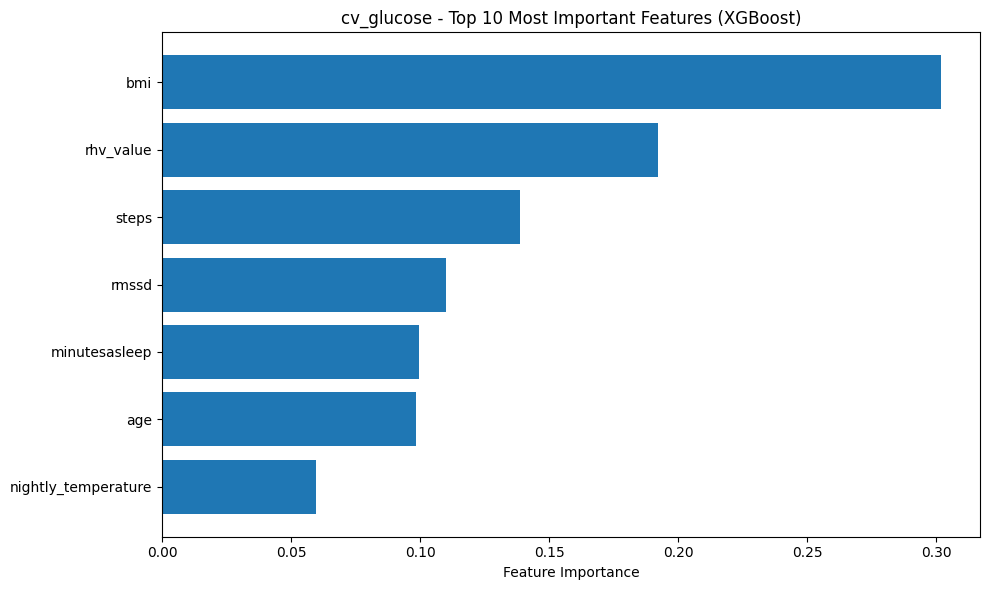

~~~~~~~~~~~~~mage~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[mage] Best CV AUC (RandomizedSearchCV): nan
[mage] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


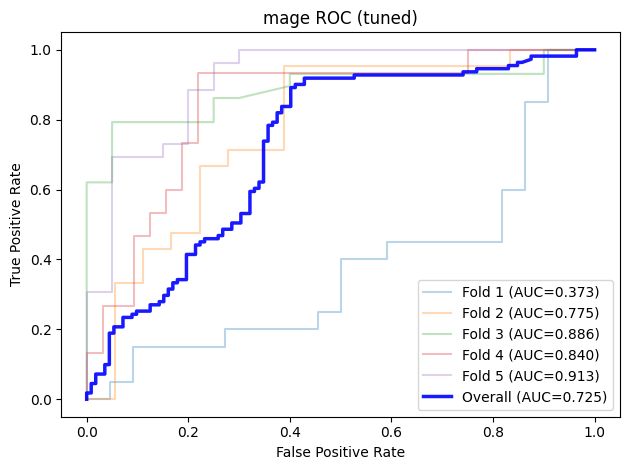

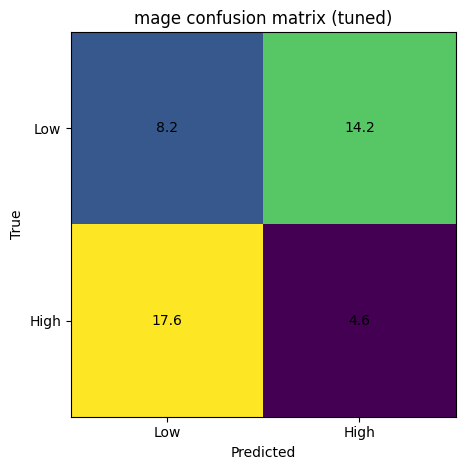

num ['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi']
cat []


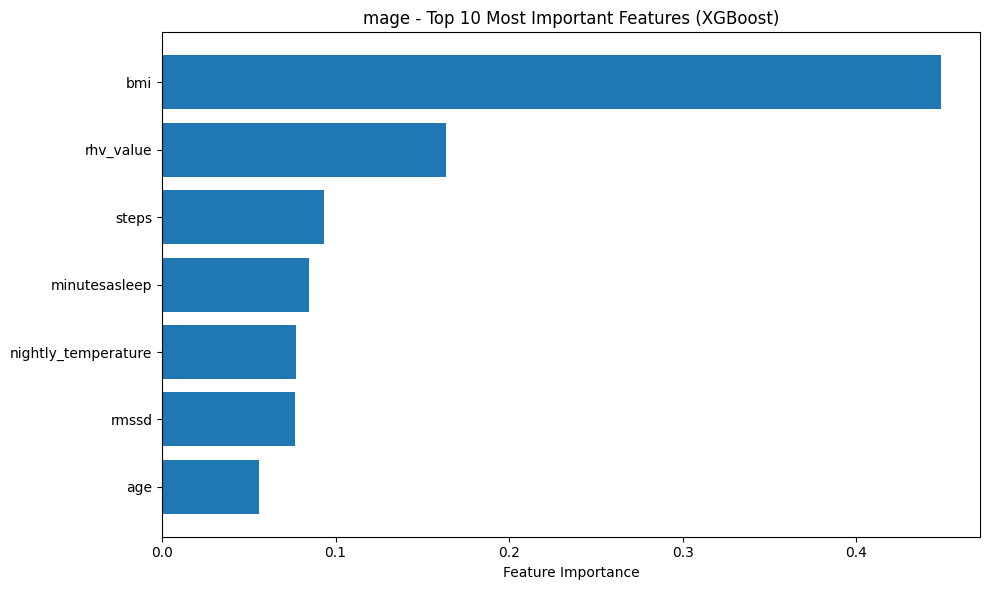

~~~~~~~~~~~~~pp_auc_0_60~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[pp_auc_0_60] Best CV AUC (RandomizedSearchCV): nan
[pp_auc_0_60] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


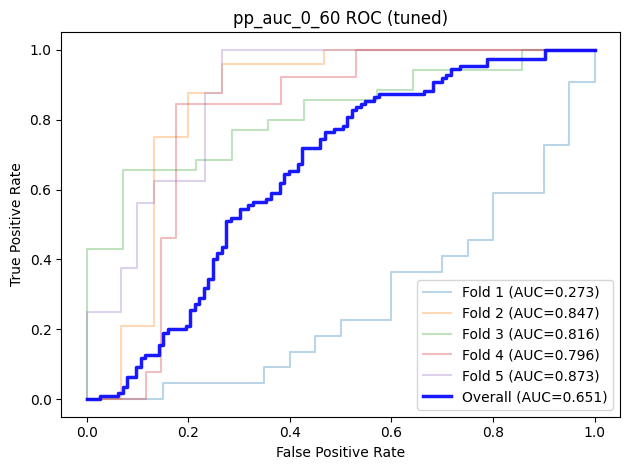

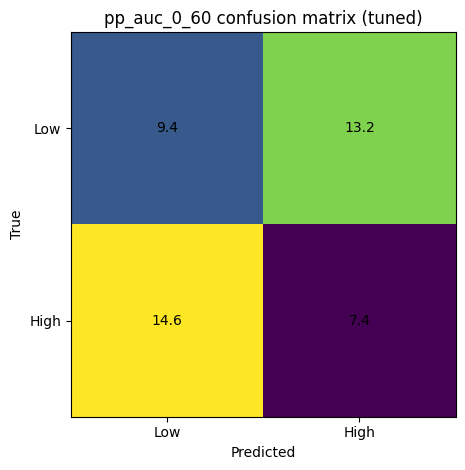

num ['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi']
cat []


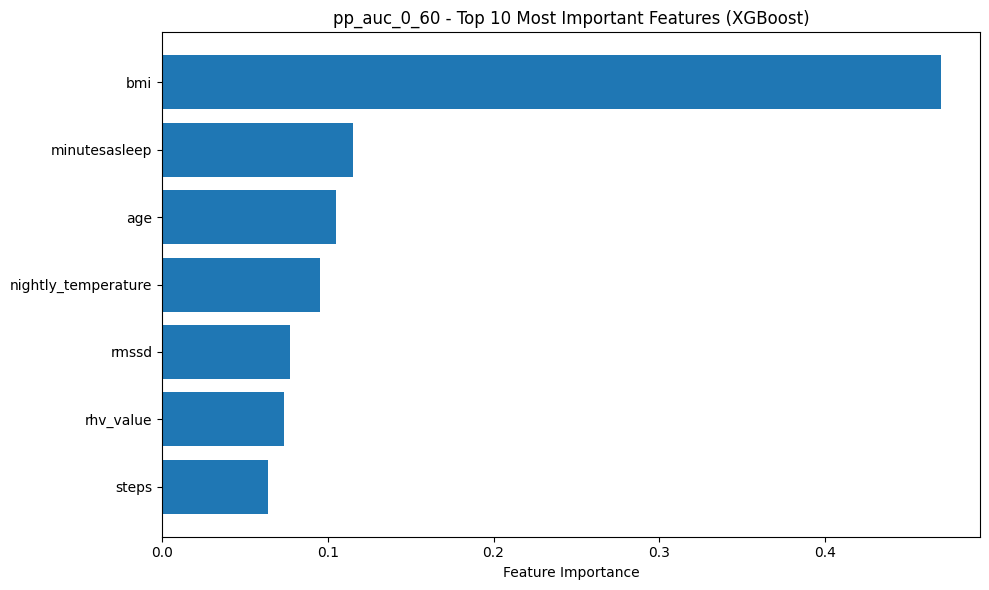

~~~~~~~~~~~~~k_decay~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[k_decay] Best CV AUC (RandomizedSearchCV): nan
[k_decay] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


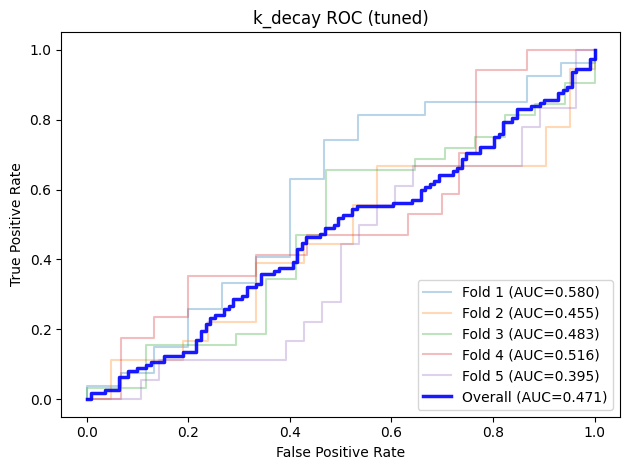

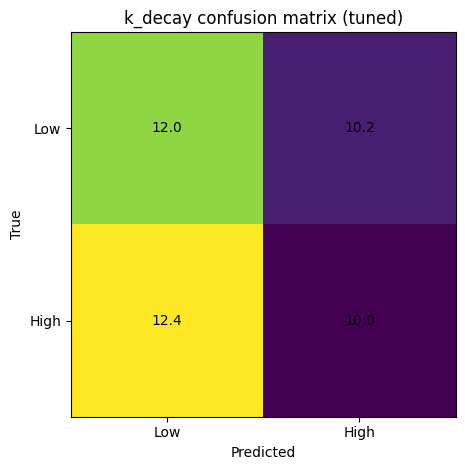

num ['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi']
cat []


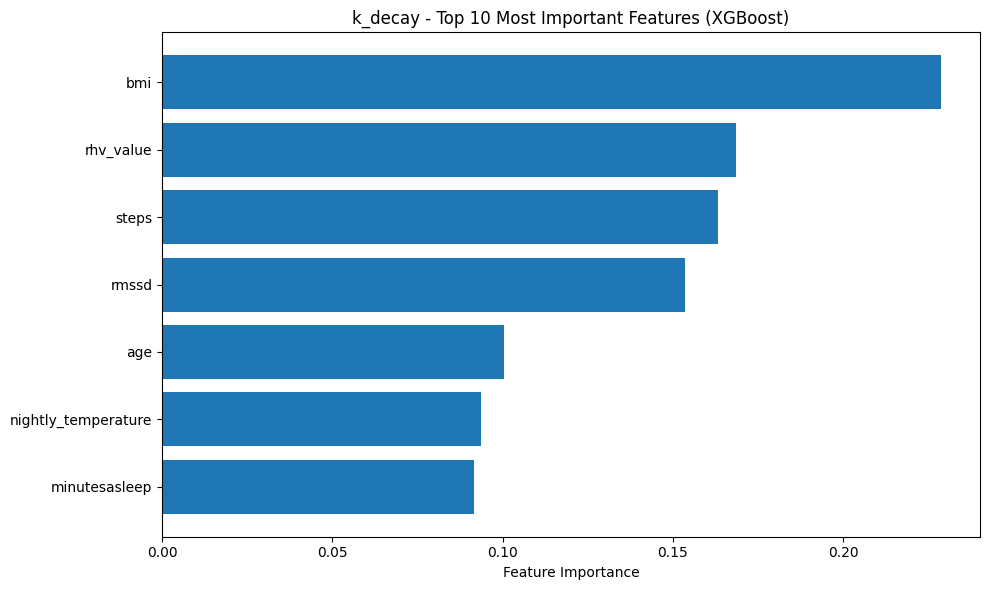

~~~~~~~~~~~~~cremaster_score_daily_global~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[cremaster_score_daily_global] Best CV AUC (RandomizedSearchCV): nan
[cremaster_score_daily_global] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


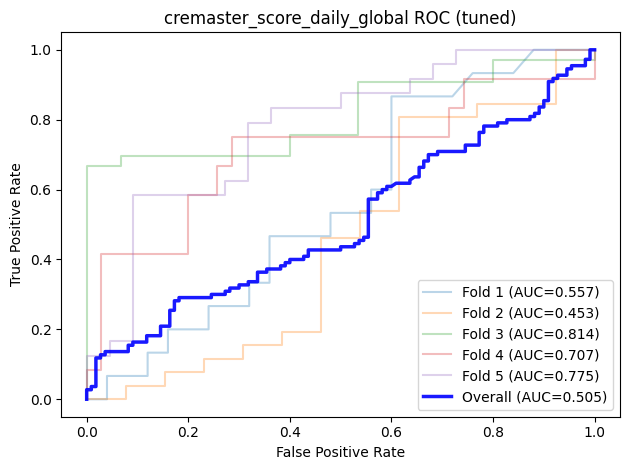

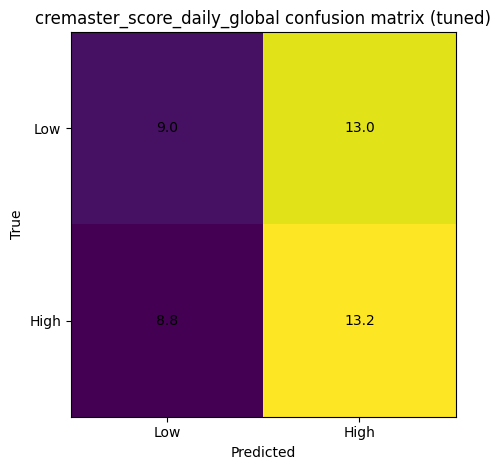

num ['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi']
cat []


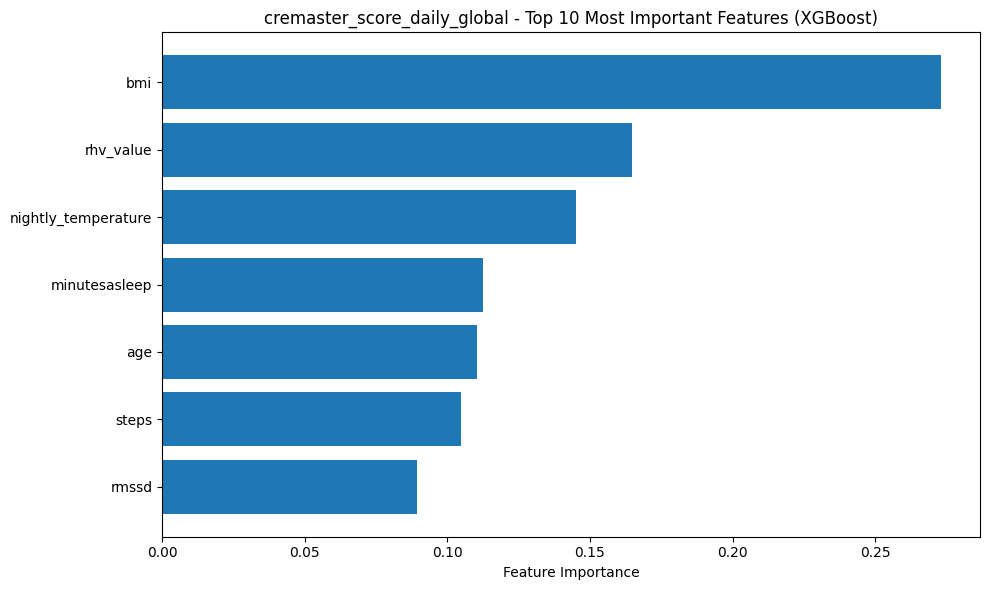

In [77]:
top_k=10
eval_cv_results = []
for y_name in irp_scores:
  print(f'~~~~~~~~~~~~~{y_name}~~~~~~~~~~~~~~~')
  y_train_vec = globals()[f"{y_name}_y_train"]
 # y_test_vec  = globals()[f"{y_name}_y_test"]
  evals_cv, preprocessor, pipeline, numeric_cols, categorical_cols = get_xgboost_groupkfold(
    y_name, X_train_phase_unaware, y_train_vec,
    groups_train=train_df.loc[X_train_phase_unaware.index, "id"],
    q=(0.5, 0.5),
    n_splits=5,
    tune_n_iter=25  # bump up if you want
)
  eval_cv_results.append(evals_cv)
  print("num", numeric_cols)
  print("cat", categorical_cols)

  # plotting feautures
  get_feature_names(y_name, preprocessor, pipeline, numeric_cols, categorical_cols = None) # there are no more categorical cols


In [78]:
eval_cv_results
eval_cv_results_phase_unaware = eval_cv_results.copy()

In [79]:
eval_cv_results_phase_unaware

[['daily_mean_glucose', 0.392, 0.348],
 ['daily_min_glucose', 0.509, 0.508],
 ['daily_max_glucose', 0.502, 0.614],
 ['overnight_mean', 0.443, 0.423],
 ['cv_glucose', 0.634, 0.71],
 ['mage', 0.71, 0.757],
 ['pp_auc_0_60', 0.614, 0.721],
 ['k_decay', 0.511, 0.486],
 ['cremaster_score_daily_global', 0.49, 0.661]]

## PHASE SPECIFIC


Luteal Phase:
  Total samples: 74
  Unique subjects: 19
  X shape: (74, 7)
  Features: ['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi']

Follicular Phase:
  Total samples: 55
  Unique subjects: 15
  X shape: (55, 7)
  Features: ['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi']

Menstrual Phase:
  Total samples: 40
  Unique subjects: 17
  X shape: (40, 7)
  Features: ['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi']

Fertility Phase:
  Total samples: 54
  Unique subjects: 18
  X shape: (54, 7)
  Features: ['age', 'rhv_value', 'rmssd', 'steps', 'minutesasleep', 'nightly_temperature', 'bmi']

Total across all phases: 223
Phase distribution:
  Luteal: 74 (33.2%)
  Follicular: 55 (24.7%)
  Menstrual: 40 (17.9%)
  Fertility: 54 (24.2%)

################################################################################
####################################################################

c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Luteal_daily_mean_glucose] Best CV AUC (RandomizedSearchCV): nan
[Luteal_daily_mean_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}
Fold 5: ⚠️ skipped (only one class after binning).
Fold 5: ⚠️ skipped (only one class after binning).


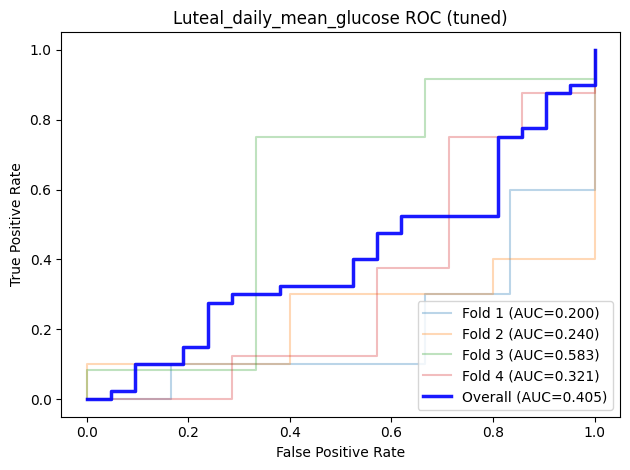

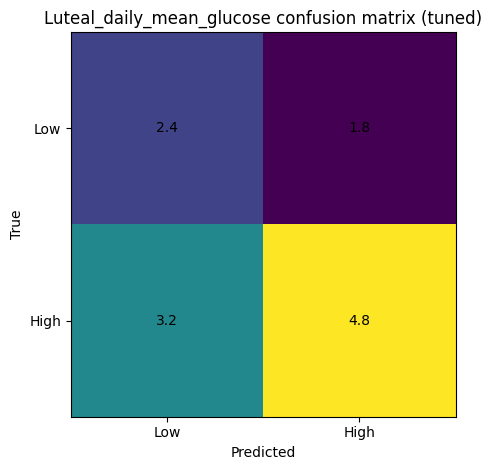

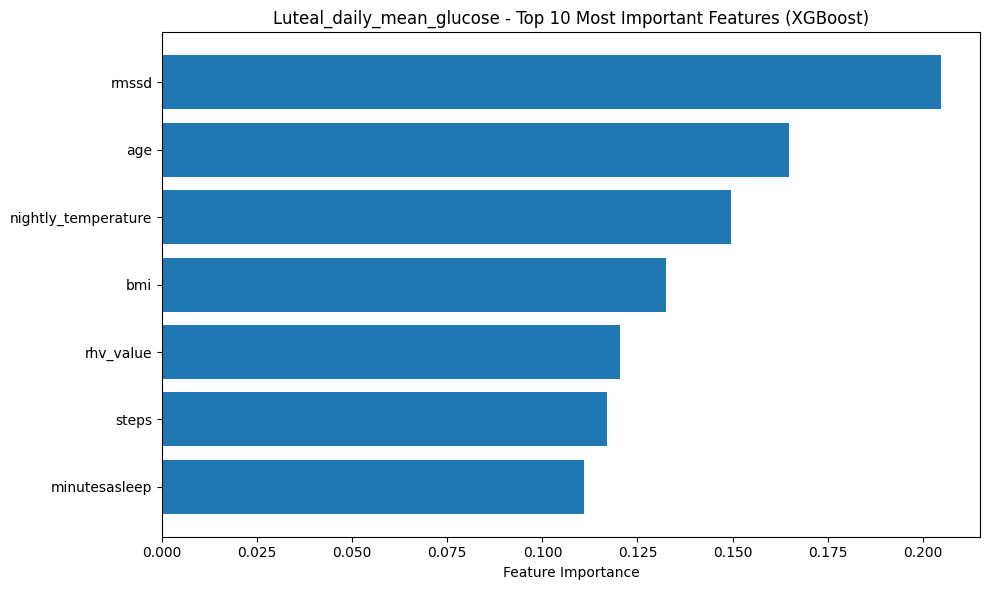


~~~~~~~~~~~~~Luteal - daily_min_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Luteal_daily_min_glucose] Best CV AUC (RandomizedSearchCV): nan
[Luteal_daily_min_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


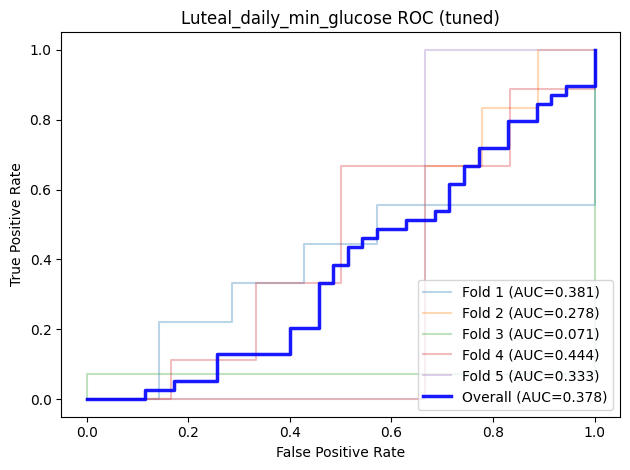

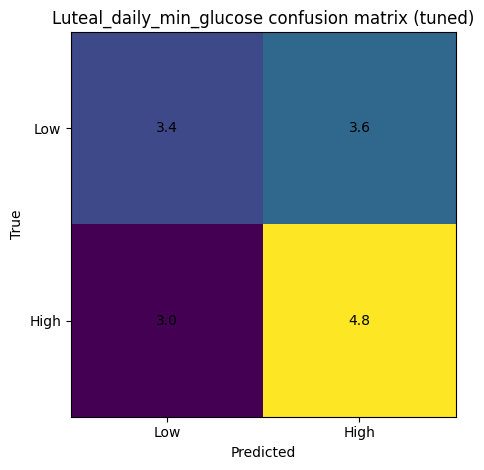

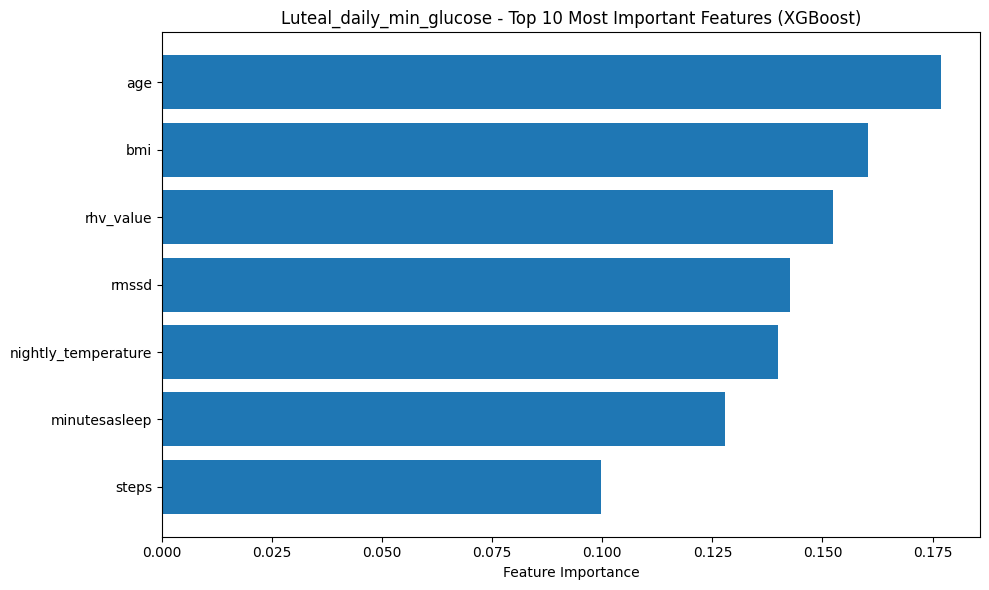


~~~~~~~~~~~~~Luteal - daily_max_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Luteal_daily_max_glucose] Best CV AUC (RandomizedSearchCV): nan
[Luteal_daily_max_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


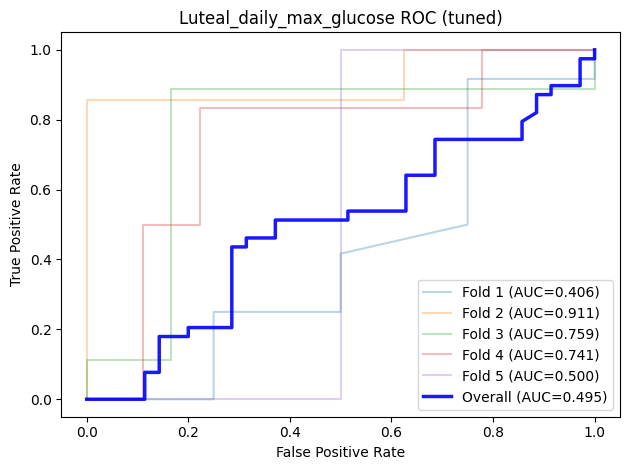

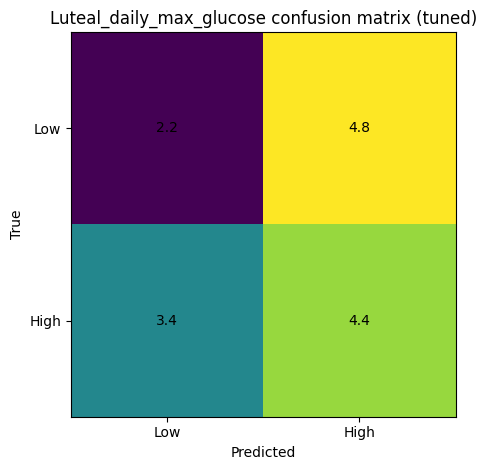

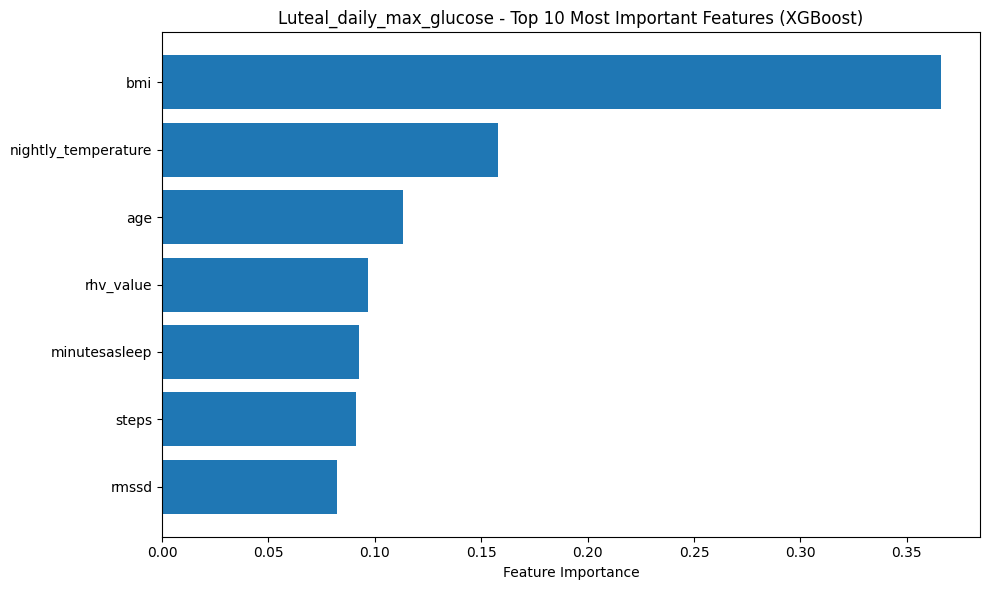


~~~~~~~~~~~~~Luteal - overnight_mean~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Luteal_overnight_mean] Best CV AUC (RandomizedSearchCV): nan
[Luteal_overnight_mean] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


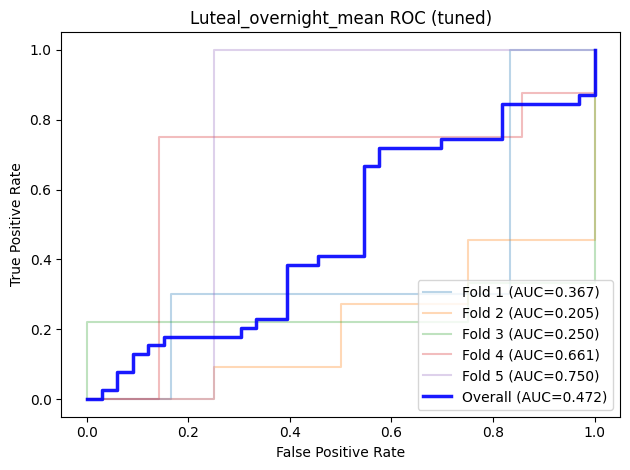

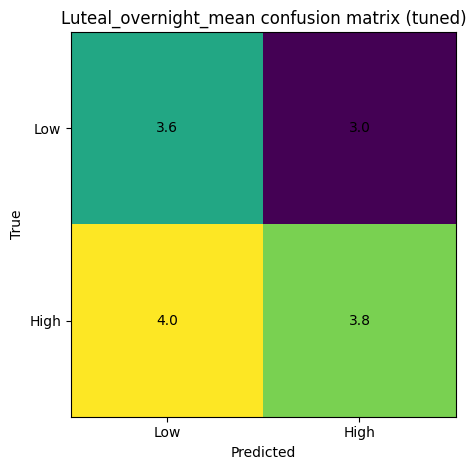

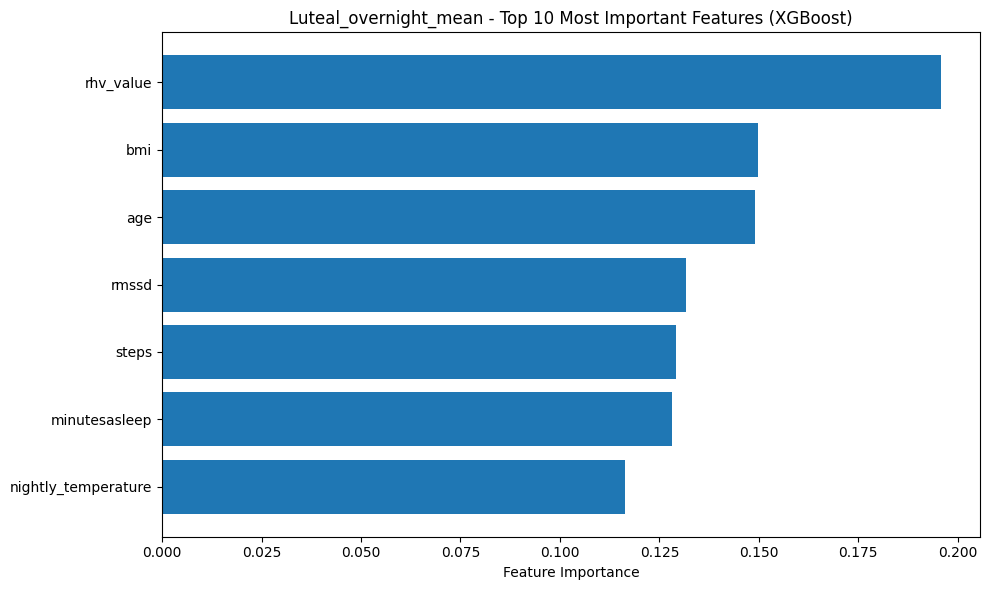


~~~~~~~~~~~~~Luteal - cv_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Luteal_cv_glucose] Best CV AUC (RandomizedSearchCV): nan
[Luteal_cv_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


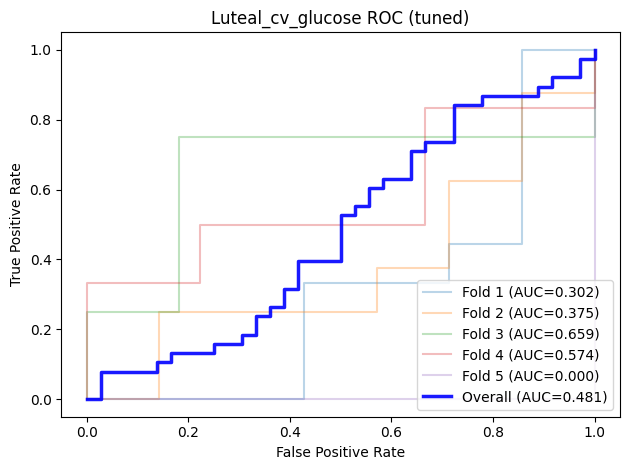

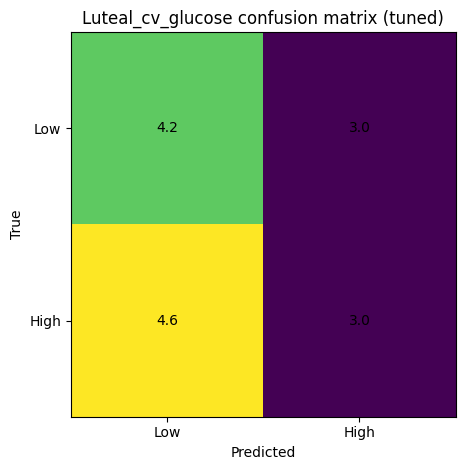

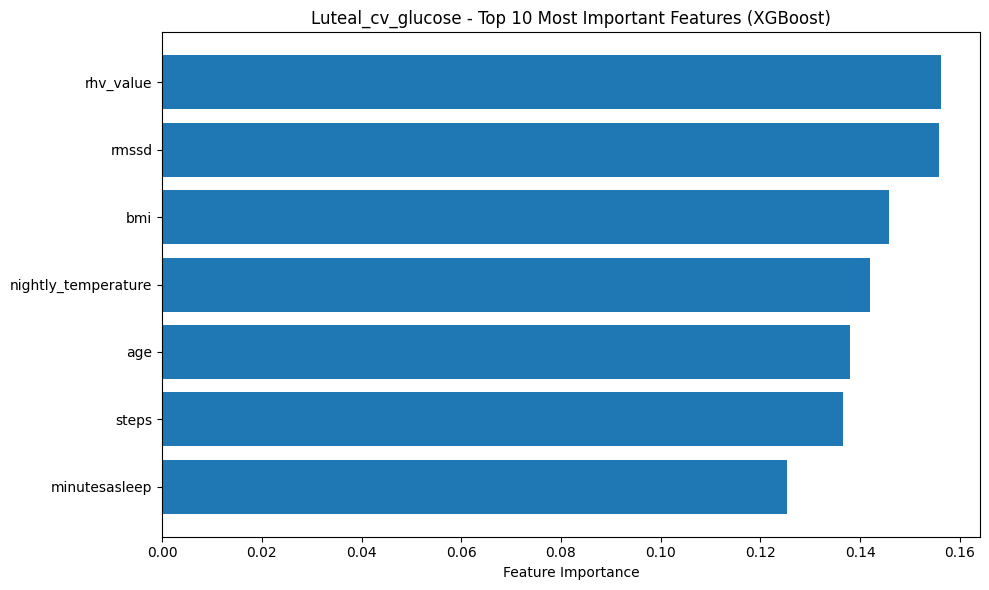


~~~~~~~~~~~~~Luteal - mage~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Luteal_mage] Best CV AUC (RandomizedSearchCV): nan
[Luteal_mage] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


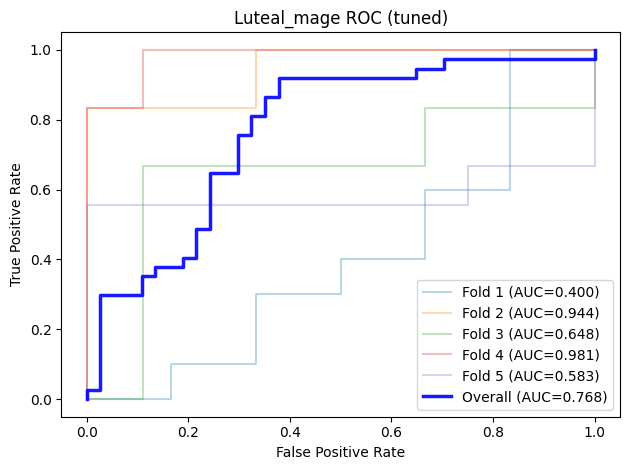

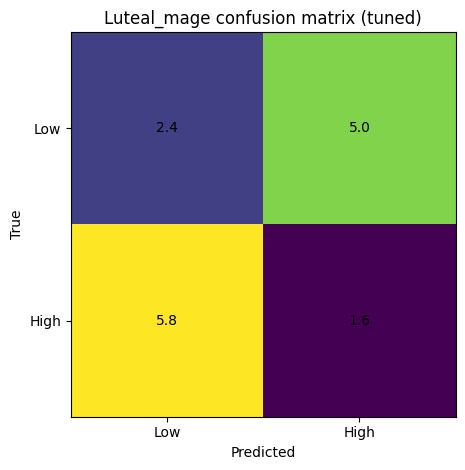

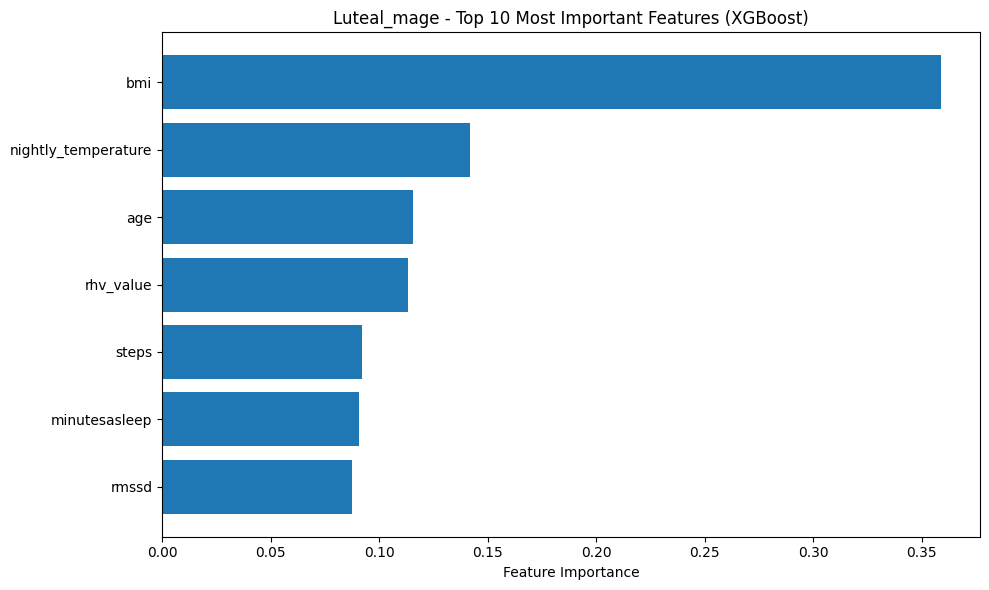


~~~~~~~~~~~~~Luteal - pp_auc_0_60~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Luteal_pp_auc_0_60] Best CV AUC (RandomizedSearchCV): nan
[Luteal_pp_auc_0_60] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


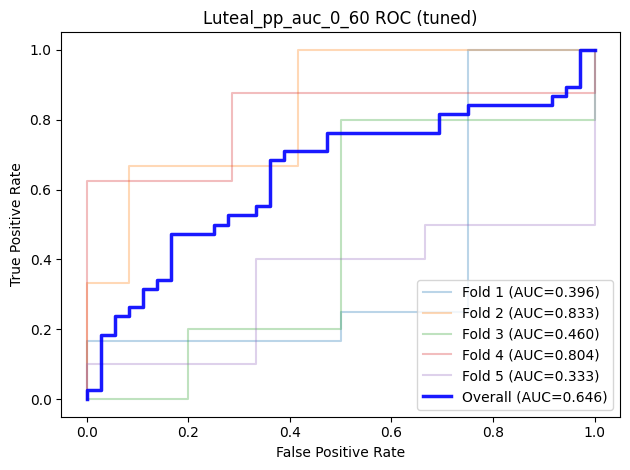

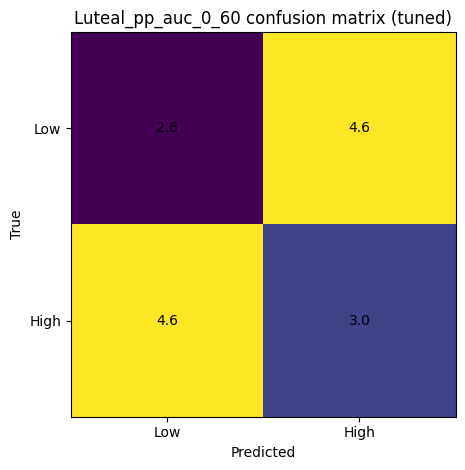

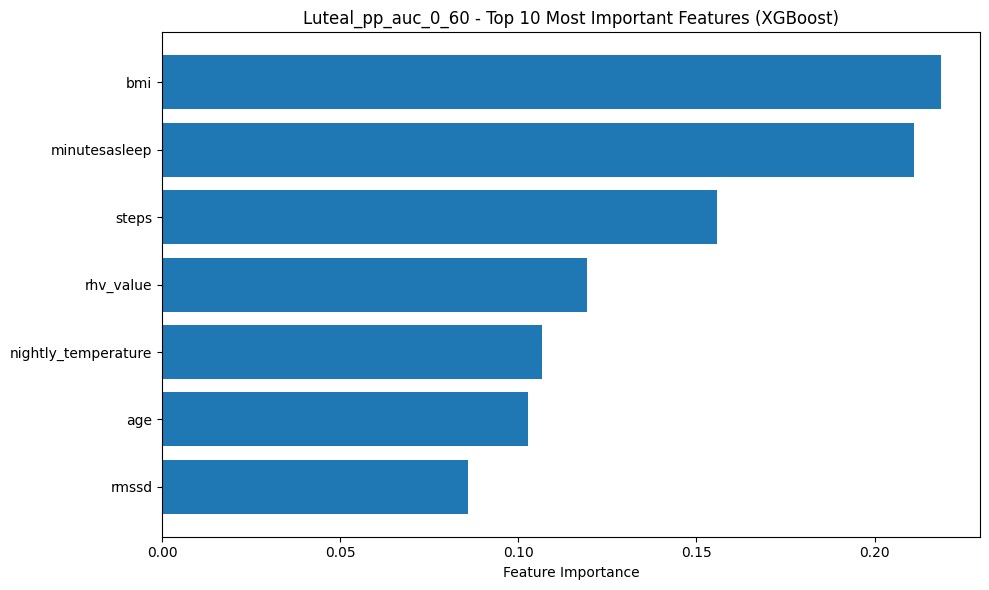


~~~~~~~~~~~~~Luteal - k_decay~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Luteal_k_decay] Best CV AUC (RandomizedSearchCV): nan
[Luteal_k_decay] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


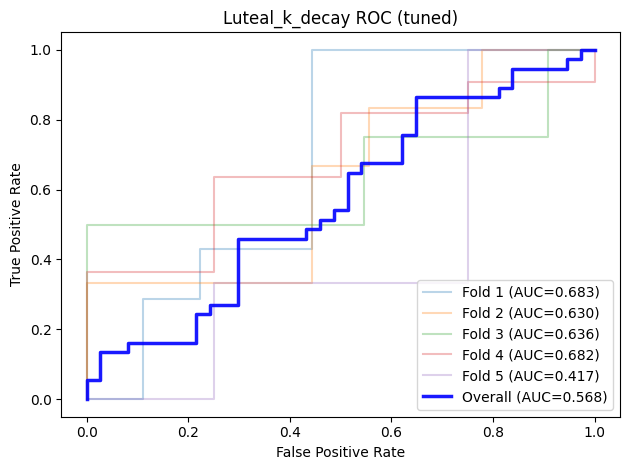

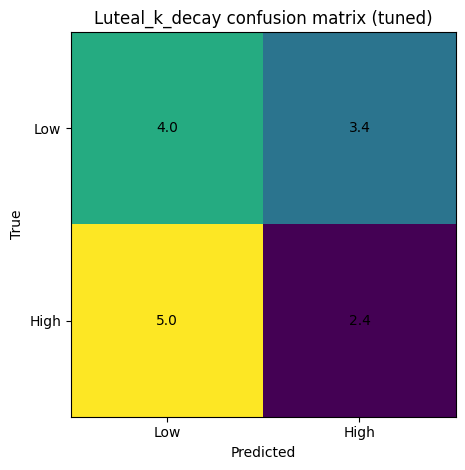

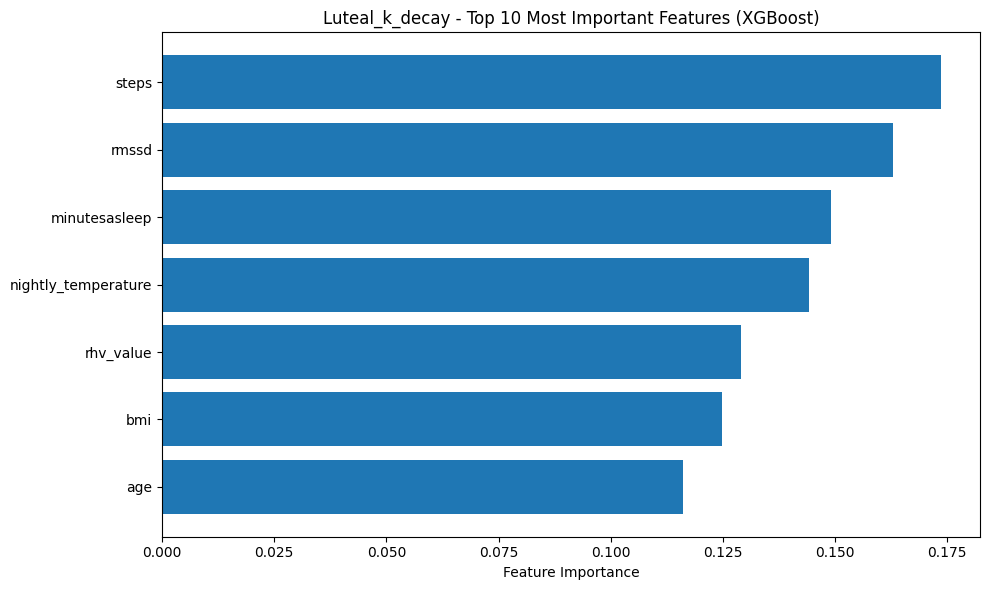


~~~~~~~~~~~~~Luteal - cremaster_score_daily_global~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Luteal_cremaster_score_daily_global] Best CV AUC (RandomizedSearchCV): nan
[Luteal_cremaster_score_daily_global] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


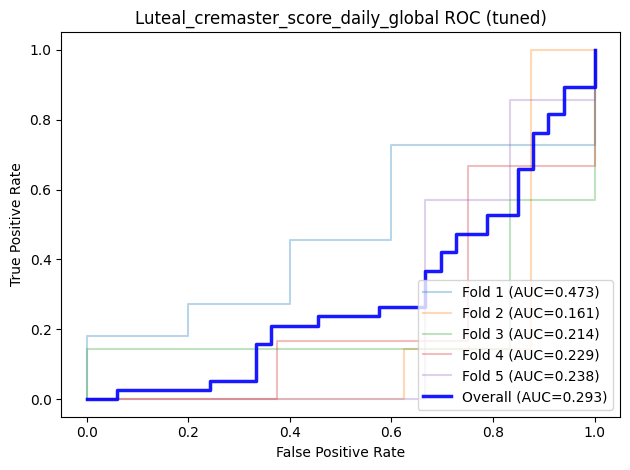

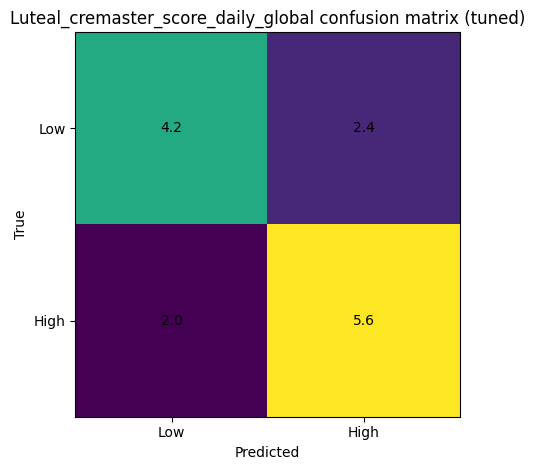

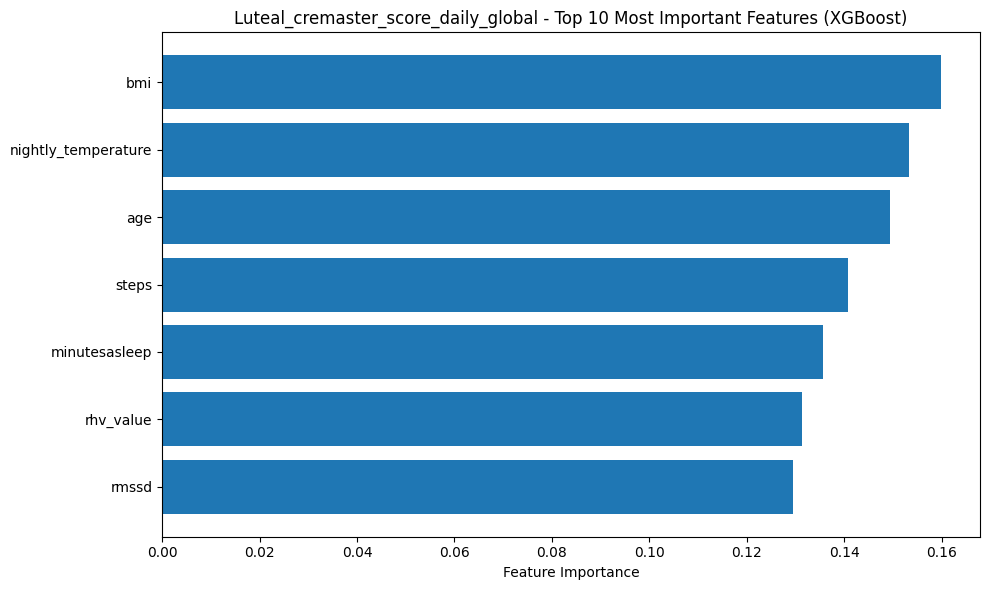


################################################################################
################################################################################
### PHASE: FOLLICULAR
################################################################################
################################################################################


~~~~~~~~~~~~~Follicular - daily_mean_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Follicular_daily_mean_glucose] Best CV AUC (RandomizedSearchCV): nan
[Follicular_daily_mean_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


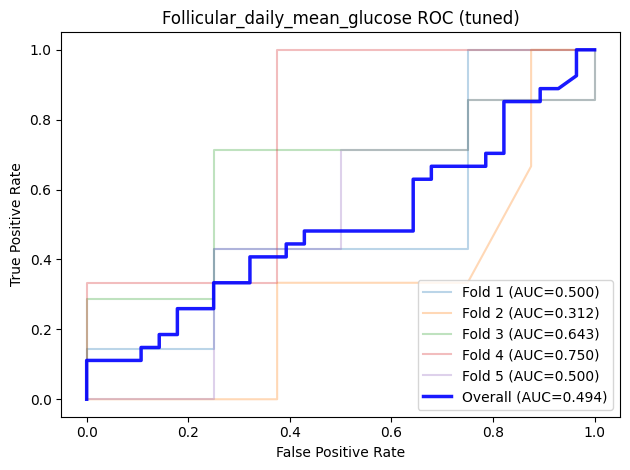

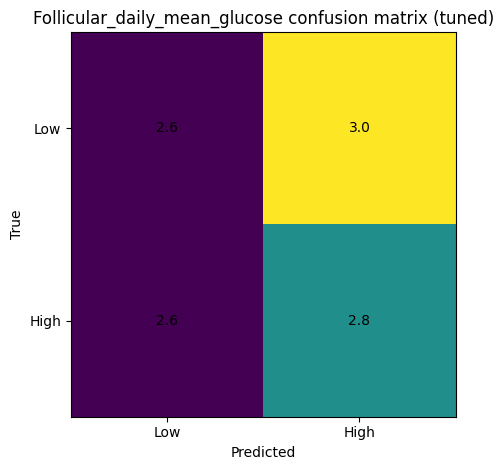

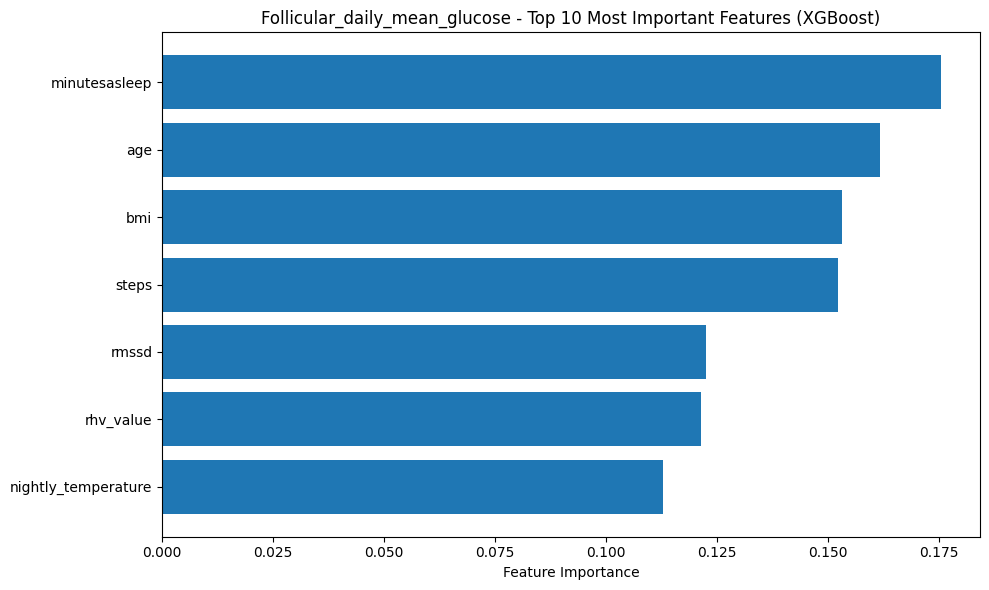


~~~~~~~~~~~~~Follicular - daily_min_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Follicular_daily_min_glucose] Best CV AUC (RandomizedSearchCV): nan
[Follicular_daily_min_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


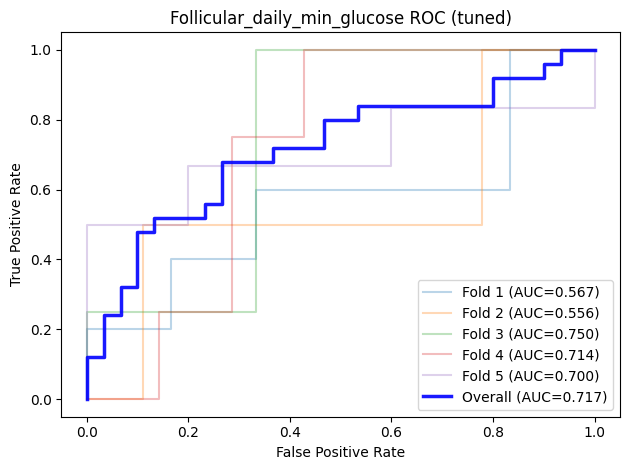

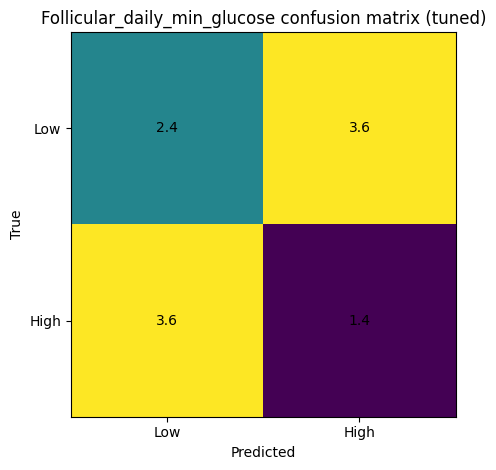

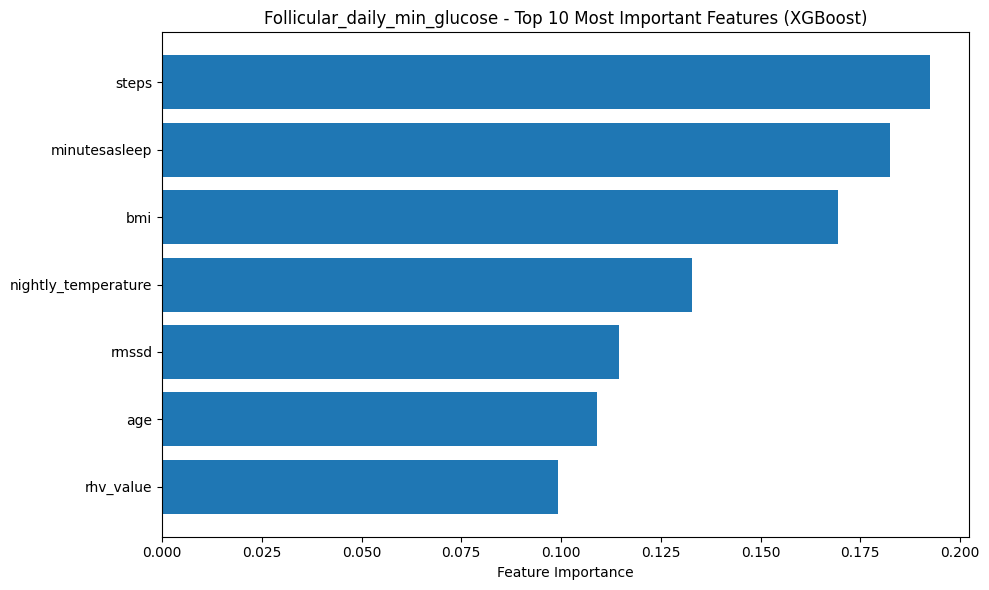


~~~~~~~~~~~~~Follicular - daily_max_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Follicular_daily_max_glucose] Best CV AUC (RandomizedSearchCV): nan
[Follicular_daily_max_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


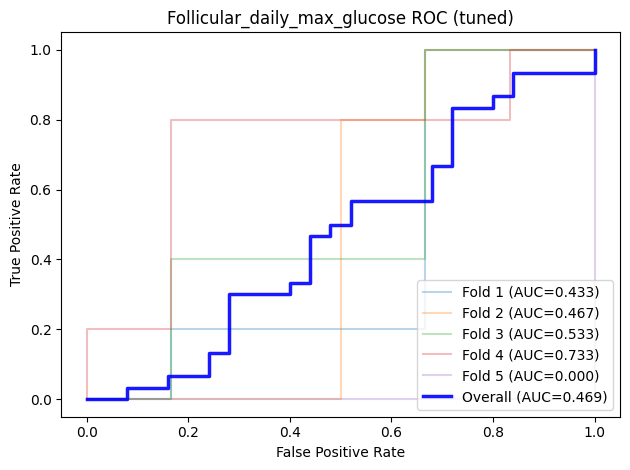

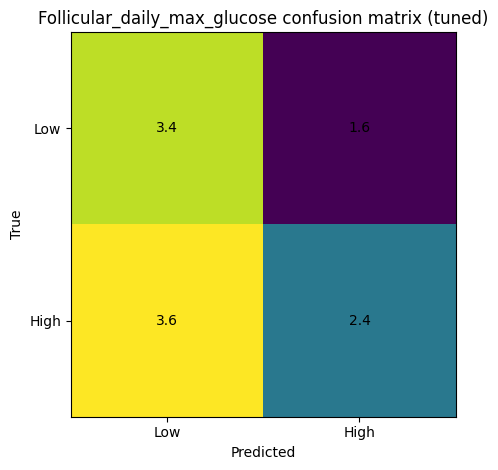

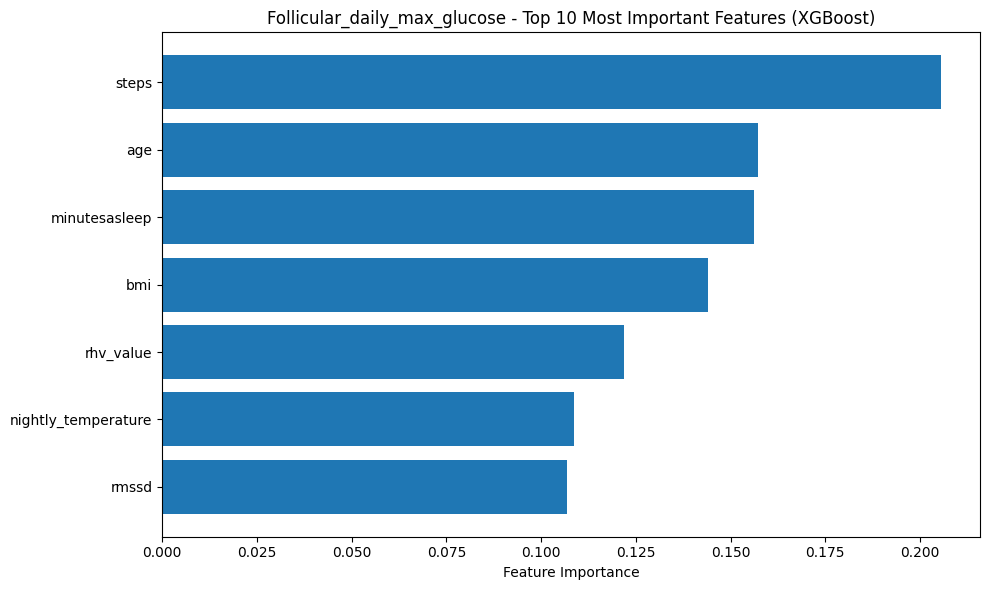


~~~~~~~~~~~~~Follicular - overnight_mean~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Follicular_overnight_mean] Best CV AUC (RandomizedSearchCV): nan
[Follicular_overnight_mean] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}
Fold 3: ⚠️ skipped (only one class after binning).
Fold 3: ⚠️ skipped (only one class after binning).


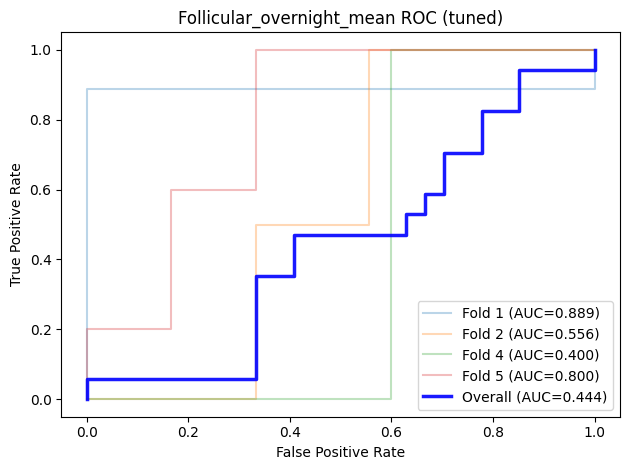

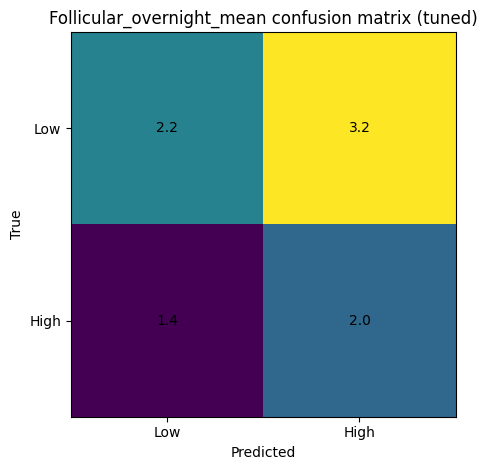

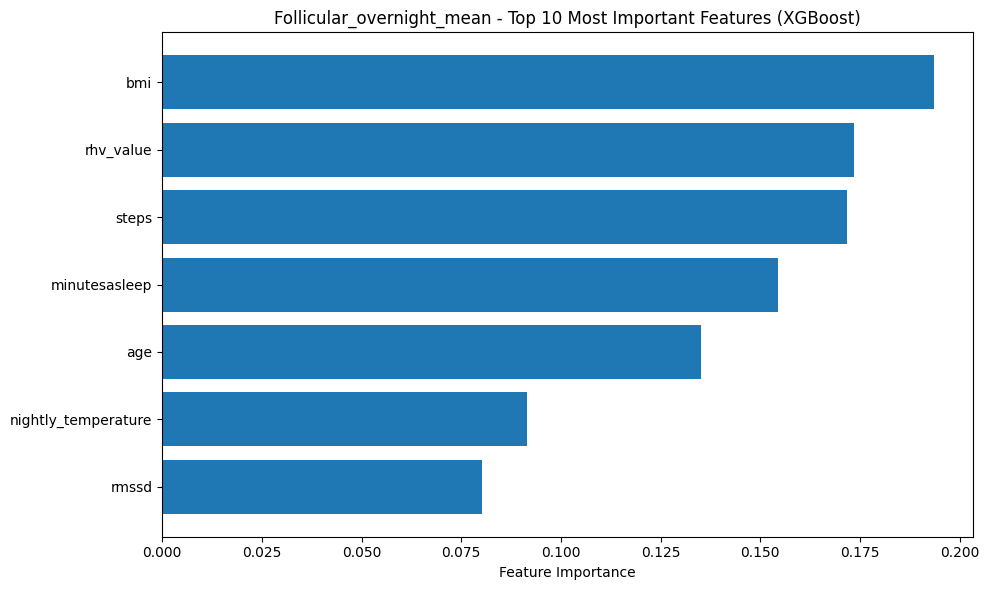


~~~~~~~~~~~~~Follicular - cv_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Follicular_cv_glucose] Best CV AUC (RandomizedSearchCV): nan
[Follicular_cv_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


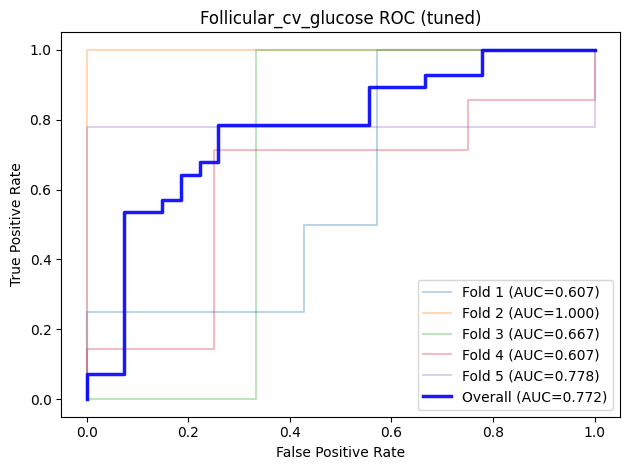

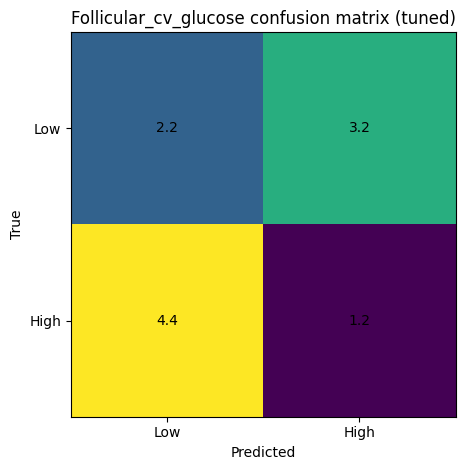

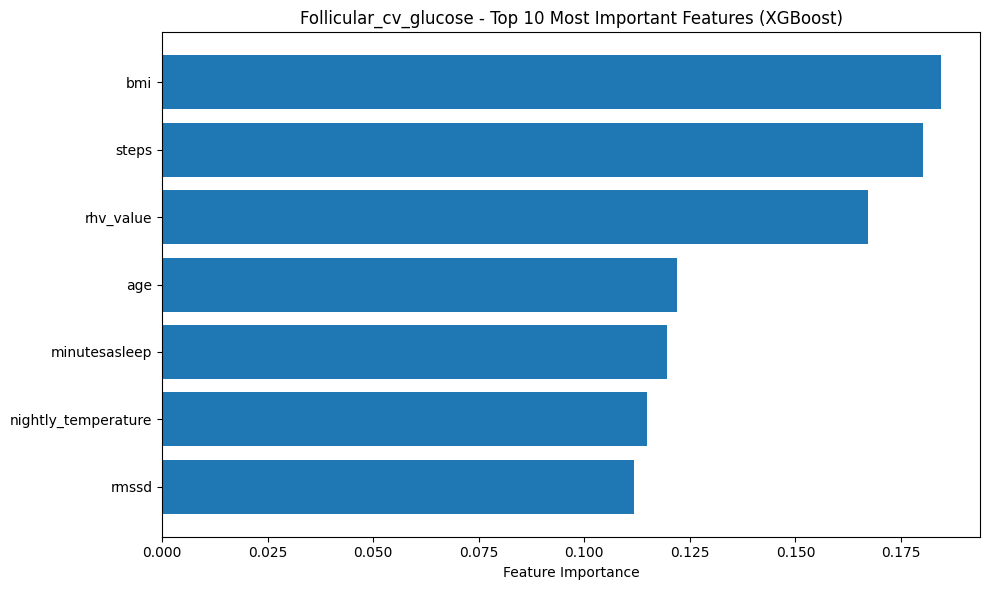


~~~~~~~~~~~~~Follicular - mage~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Follicular_mage] Best CV AUC (RandomizedSearchCV): nan
[Follicular_mage] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}
Fold 3: ⚠️ skipped (only one class after binning).
Fold 3: ⚠️ skipped (only one class after binning).


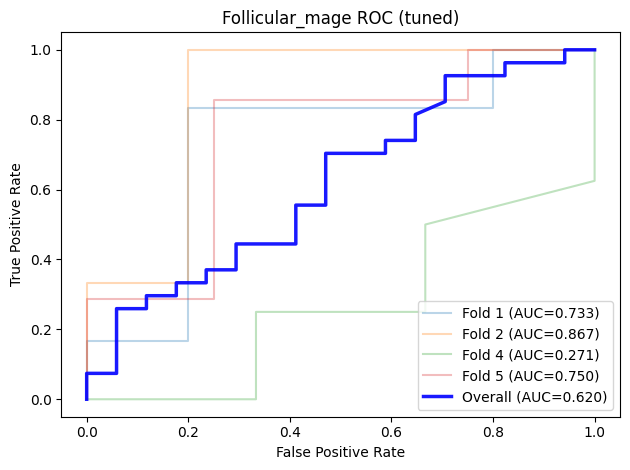

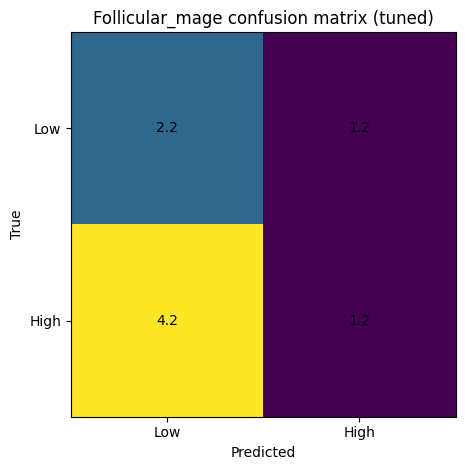

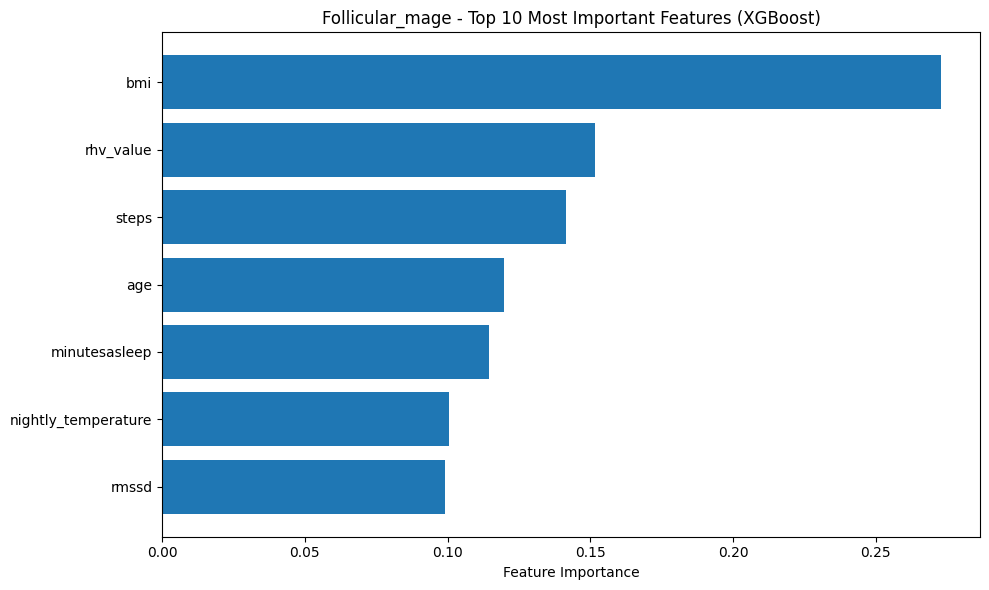


~~~~~~~~~~~~~Follicular - pp_auc_0_60~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Follicular_pp_auc_0_60] Best CV AUC (RandomizedSearchCV): nan
[Follicular_pp_auc_0_60] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


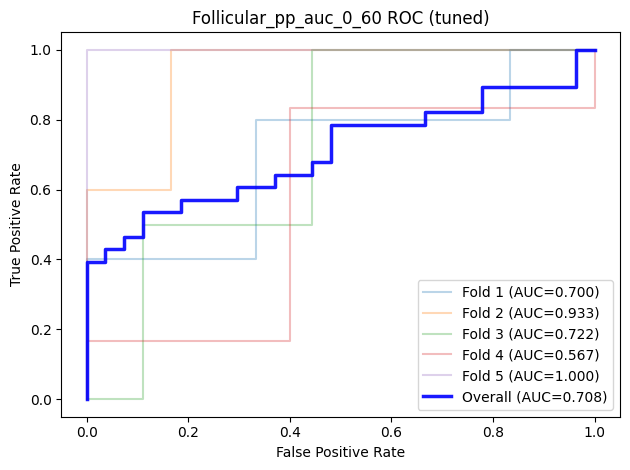

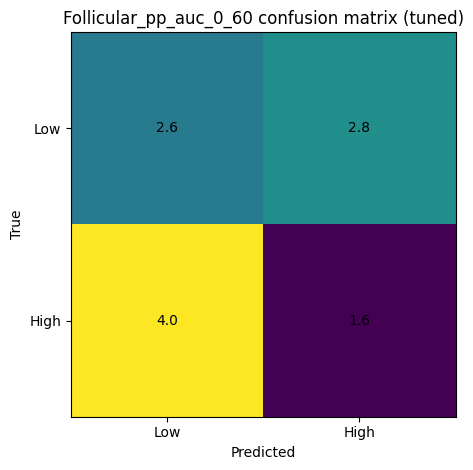

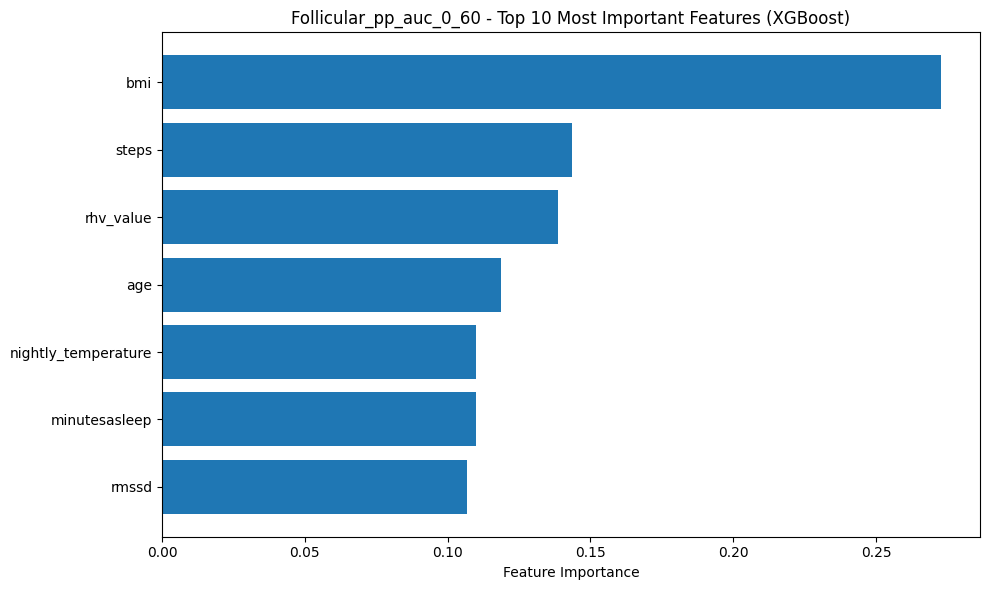


~~~~~~~~~~~~~Follicular - k_decay~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Follicular_k_decay] Best CV AUC (RandomizedSearchCV): nan
[Follicular_k_decay] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


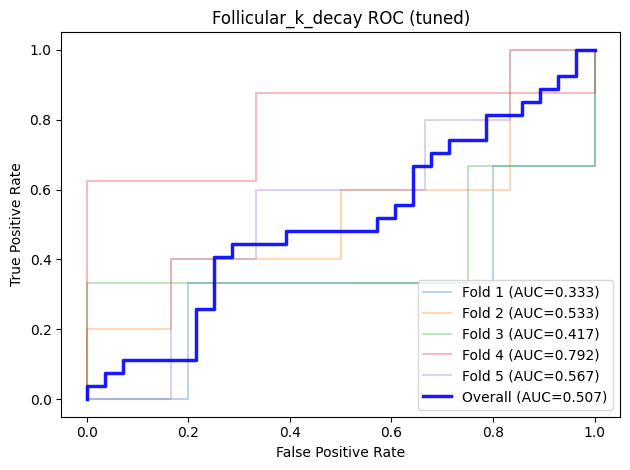

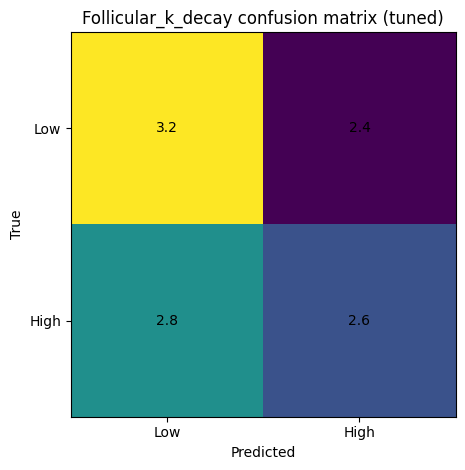

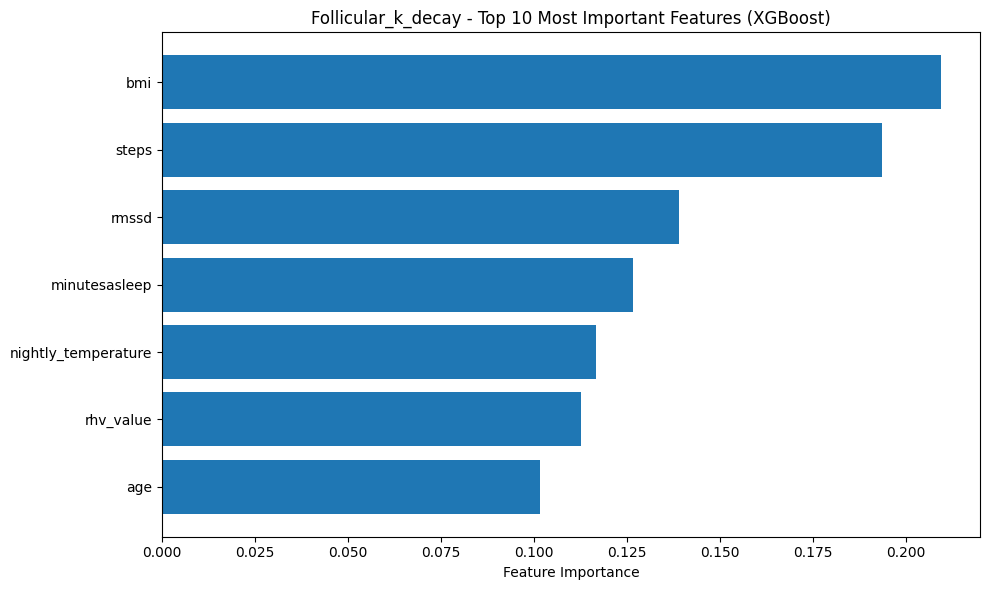


~~~~~~~~~~~~~Follicular - cremaster_score_daily_global~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Follicular_cremaster_score_daily_global] Best CV AUC (RandomizedSearchCV): nan
[Follicular_cremaster_score_daily_global] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


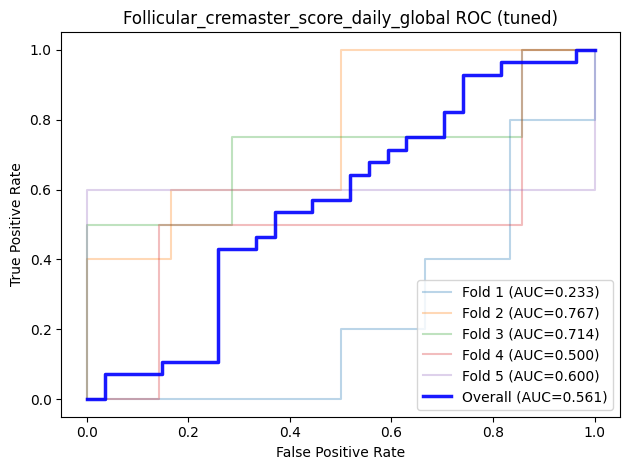

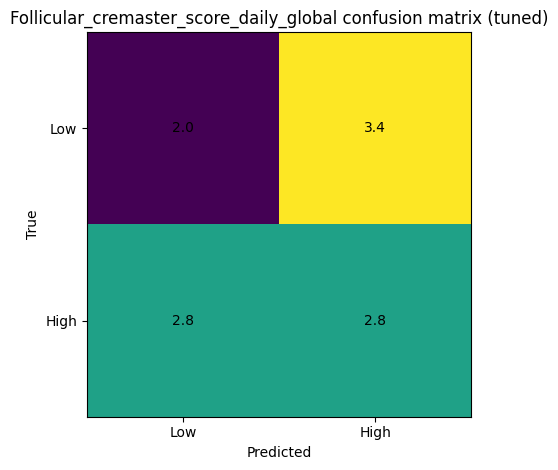

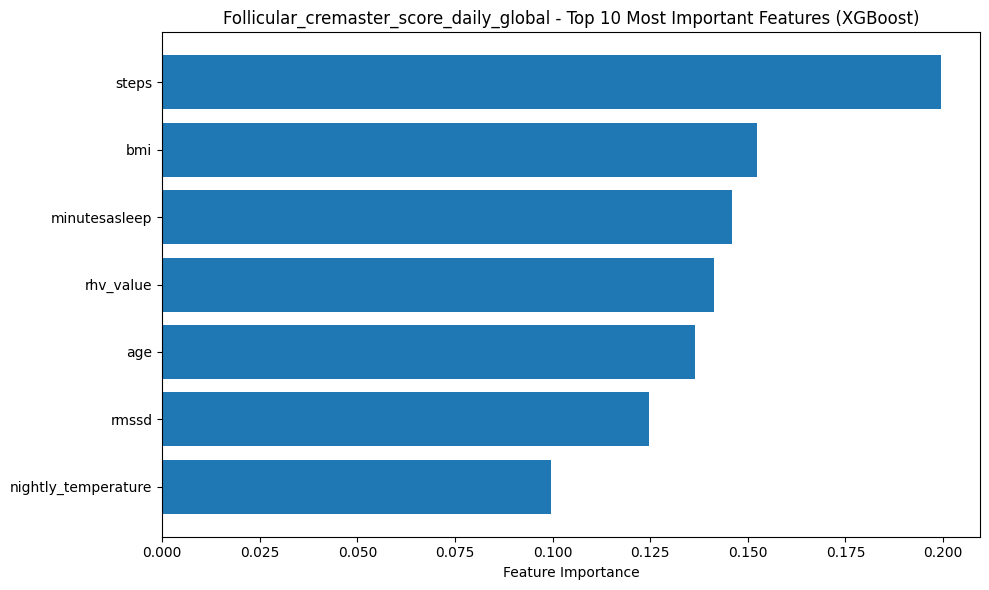


################################################################################
################################################################################
### PHASE: MENSTRUAL
################################################################################
################################################################################


~~~~~~~~~~~~~Menstrual - daily_mean_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Menstrual_daily_mean_glucose] Best CV AUC (RandomizedSearchCV): nan
[Menstrual_daily_mean_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}
Fold 5: ⚠️ skipped (only one class after binning).
Fold 5: ⚠️ skipped (only one class after binning).


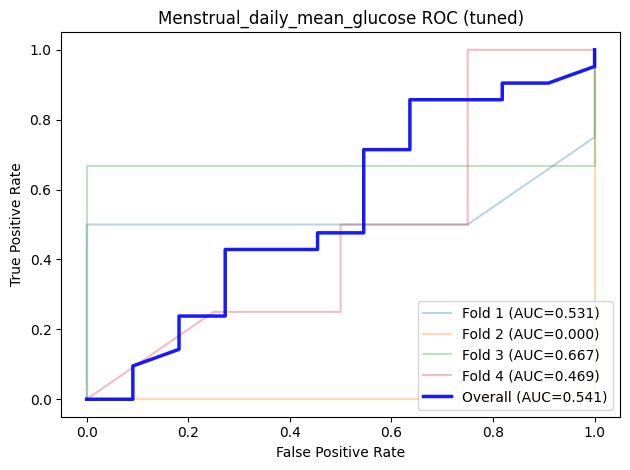

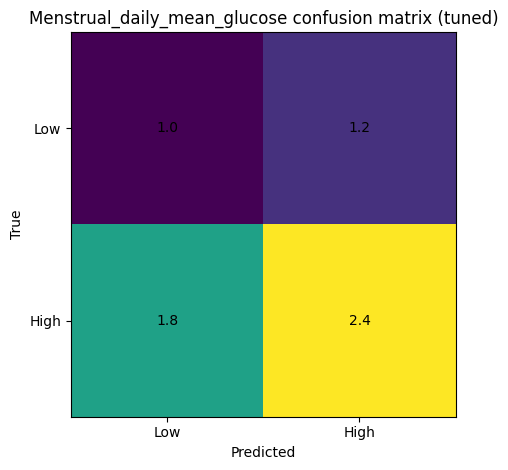

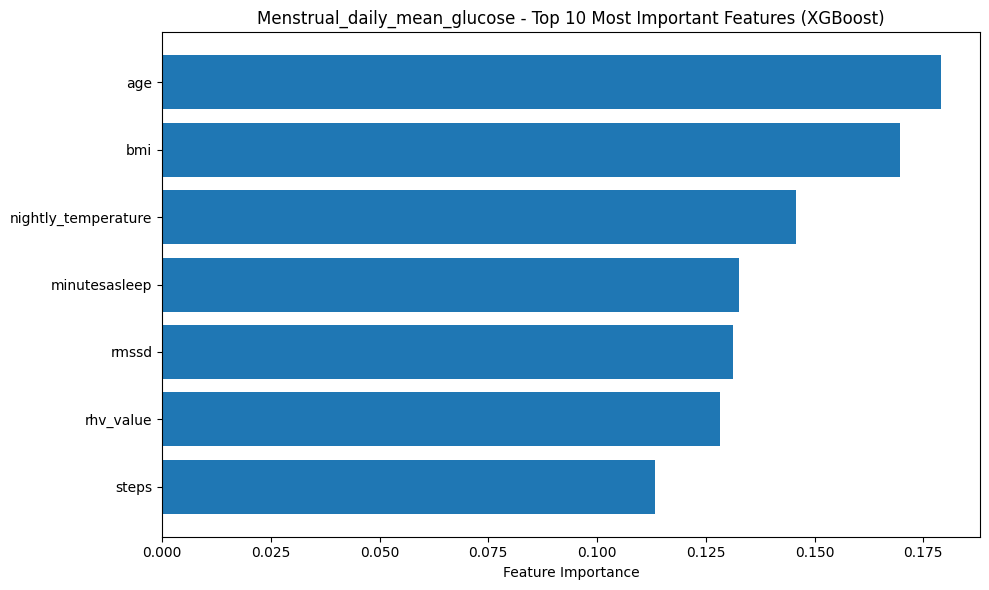


~~~~~~~~~~~~~Menstrual - daily_min_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Menstrual_daily_min_glucose] Best CV AUC (RandomizedSearchCV): nan
[Menstrual_daily_min_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


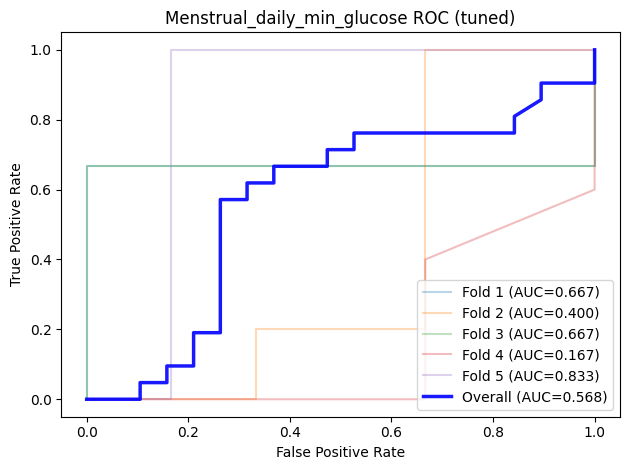

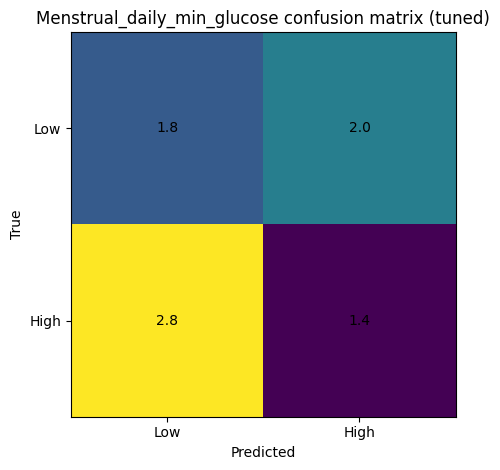

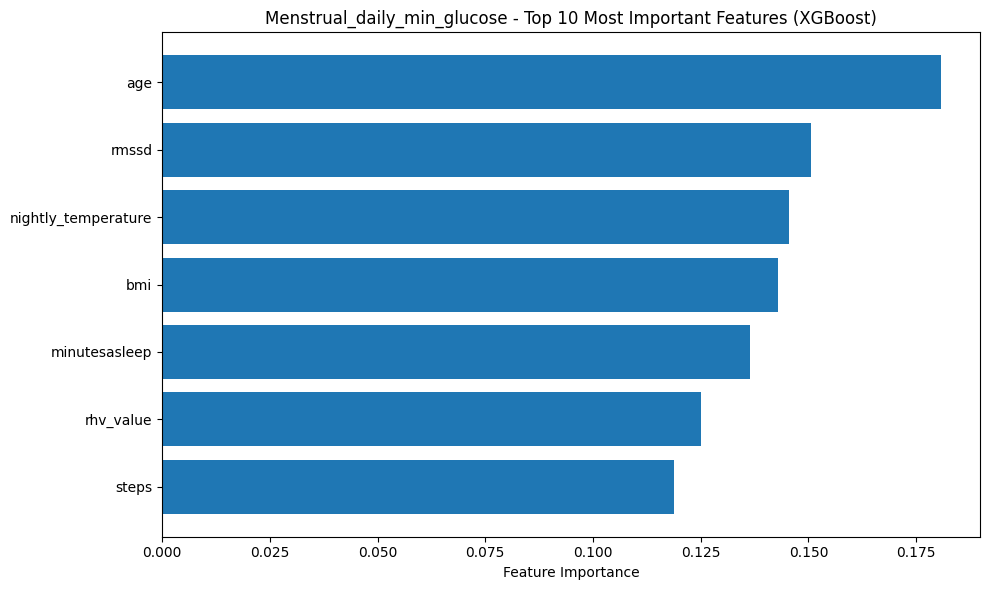


~~~~~~~~~~~~~Menstrual - daily_max_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Menstrual_daily_max_glucose] Best CV AUC (RandomizedSearchCV): nan
[Menstrual_daily_max_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}
Fold 2: ⚠️ skipped (only one class after binning).
Fold 5: ⚠️ skipped (only one class after binning).
Fold 2: ⚠️ skipped (only one class after binning).
Fold 5: ⚠️ skipped (only one class after binning).


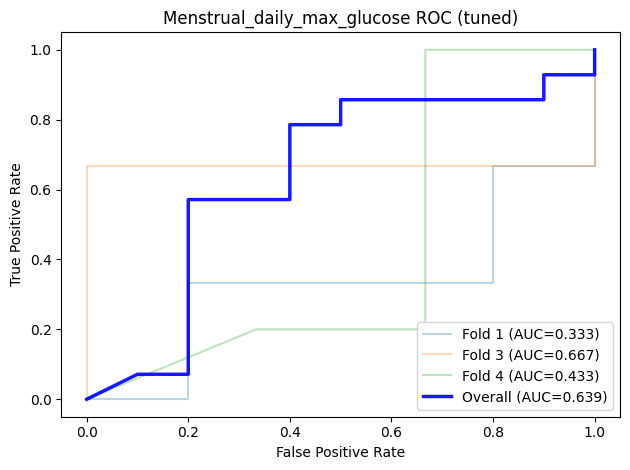

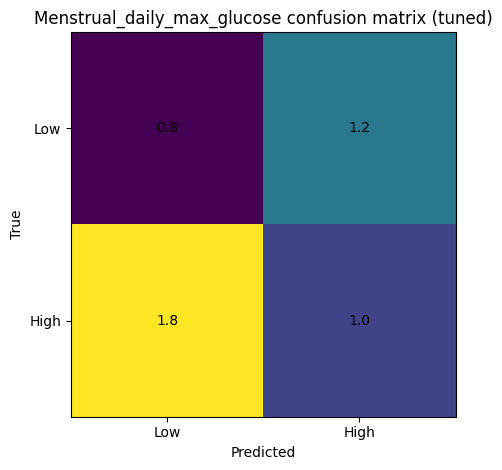

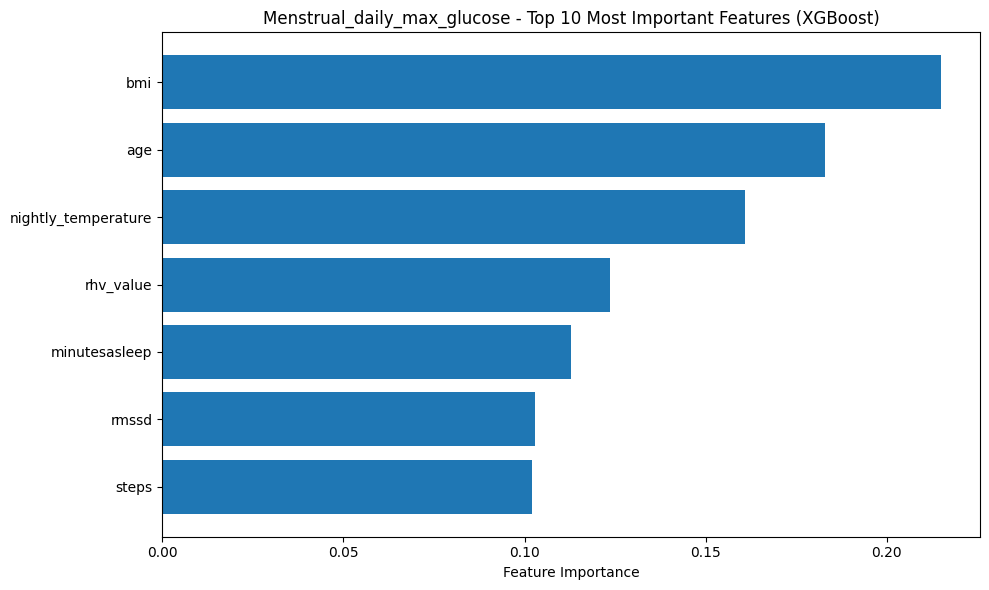


~~~~~~~~~~~~~Menstrual - overnight_mean~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Menstrual_overnight_mean] Best CV AUC (RandomizedSearchCV): nan
[Menstrual_overnight_mean] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


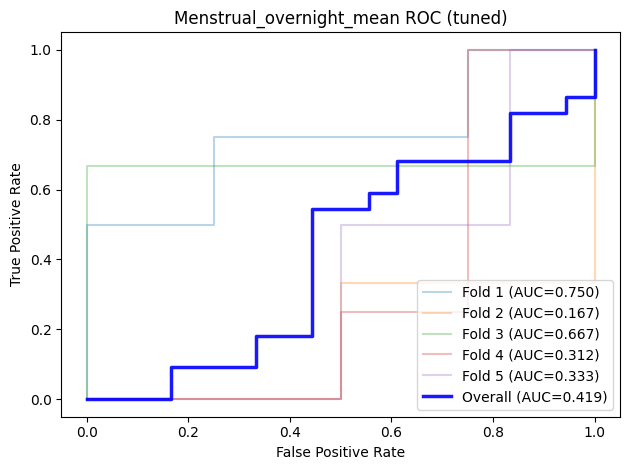

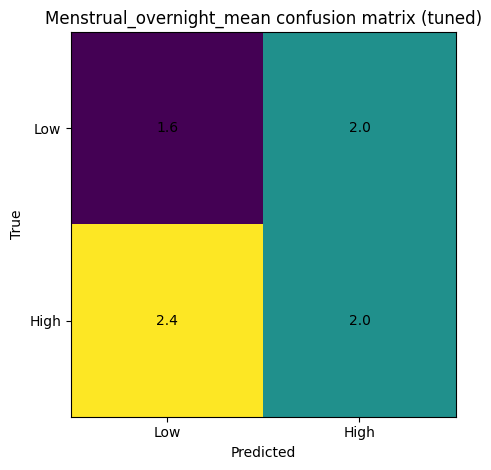

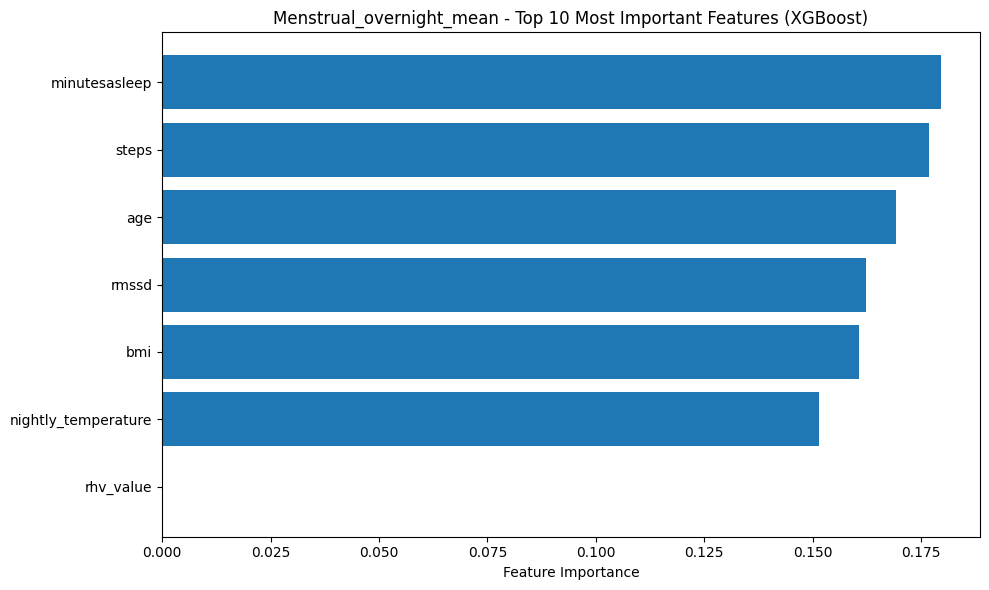


~~~~~~~~~~~~~Menstrual - cv_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Menstrual_cv_glucose] Best CV AUC (RandomizedSearchCV): nan
[Menstrual_cv_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


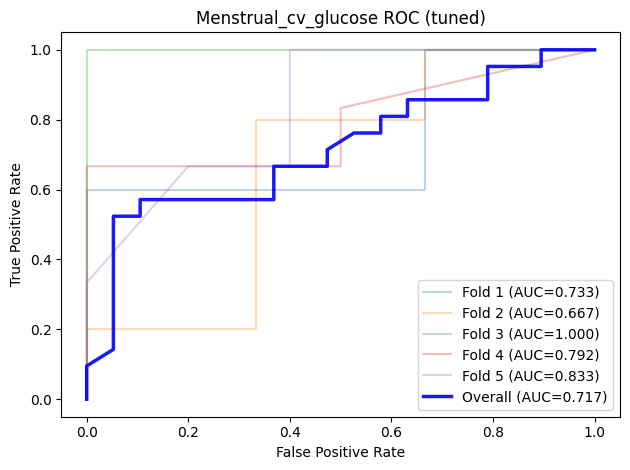

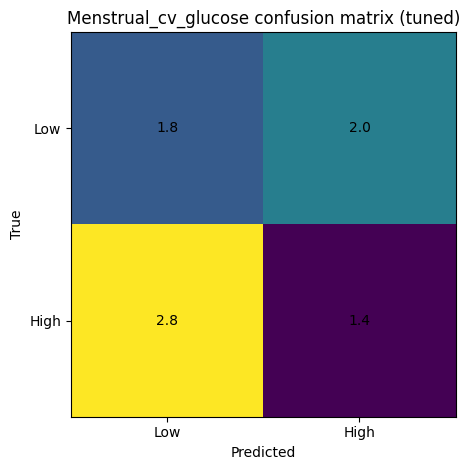

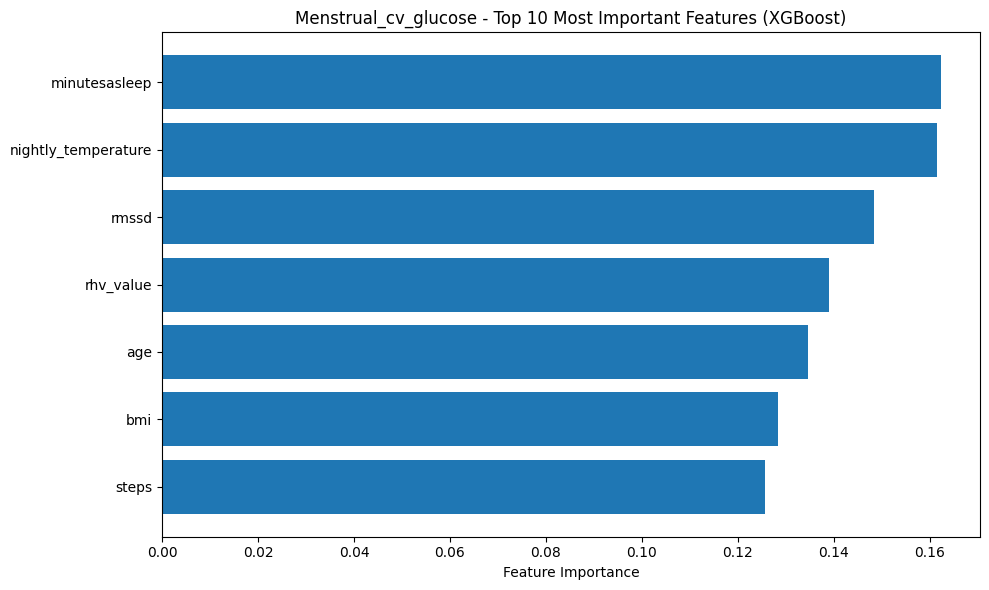


~~~~~~~~~~~~~Menstrual - mage~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Menstrual_mage] Best CV AUC (RandomizedSearchCV): nan
[Menstrual_mage] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}
Fold 5: ⚠️ skipped (only one class after binning).
Fold 5: ⚠️ skipped (only one class after binning).


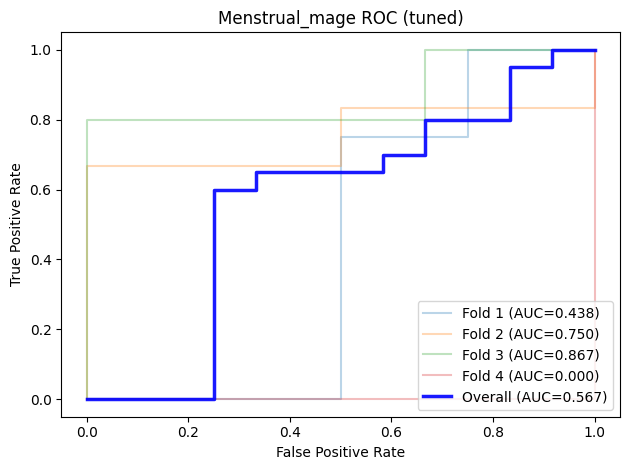

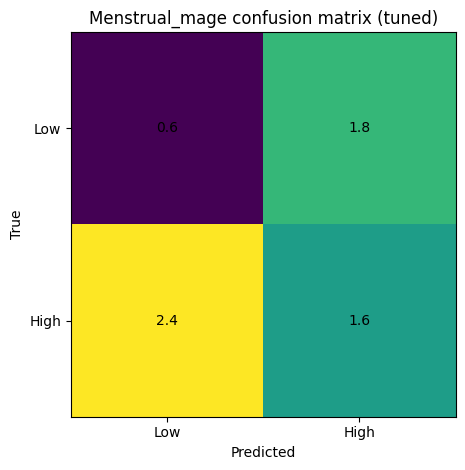

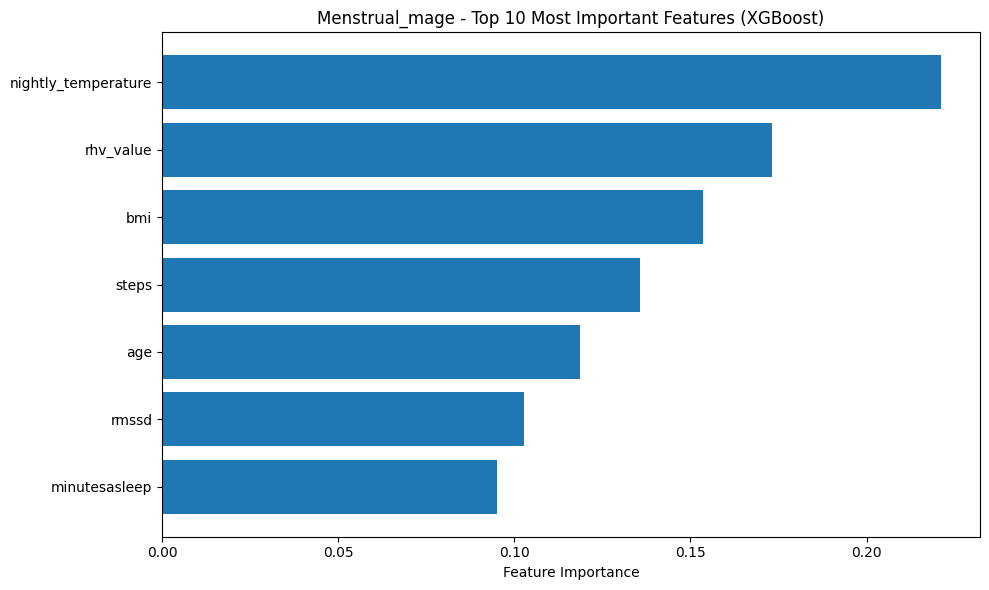


~~~~~~~~~~~~~Menstrual - pp_auc_0_60~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Menstrual_pp_auc_0_60] Best CV AUC (RandomizedSearchCV): nan
[Menstrual_pp_auc_0_60] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}
Fold 2: ⚠️ skipped (only one class after binning).
Fold 2: ⚠️ skipped (only one class after binning).


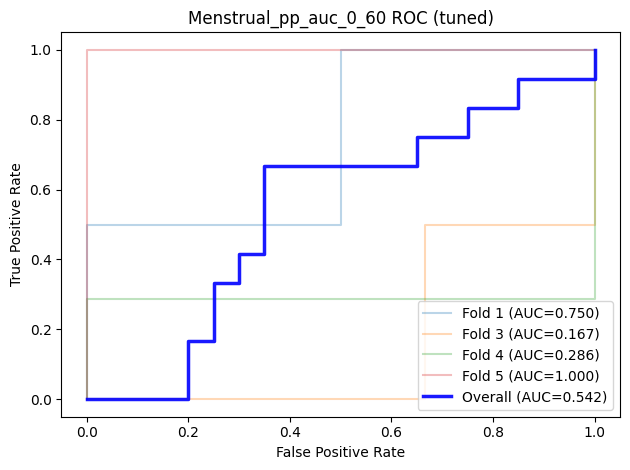

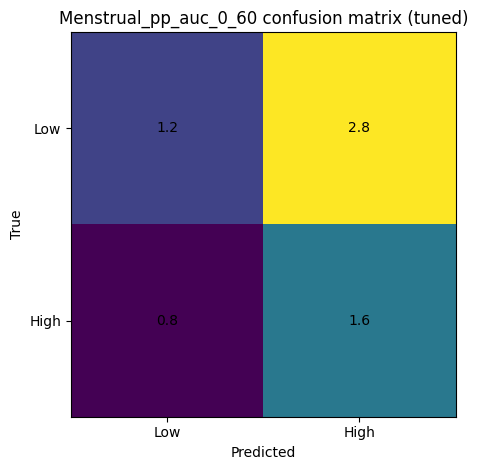

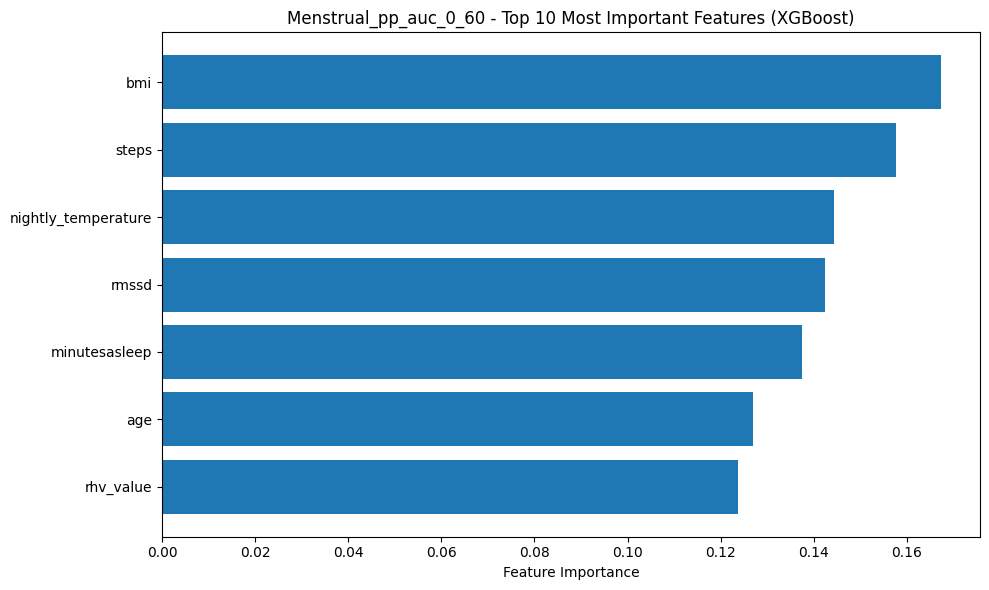


~~~~~~~~~~~~~Menstrual - k_decay~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Menstrual_k_decay] Best CV AUC (RandomizedSearchCV): nan
[Menstrual_k_decay] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


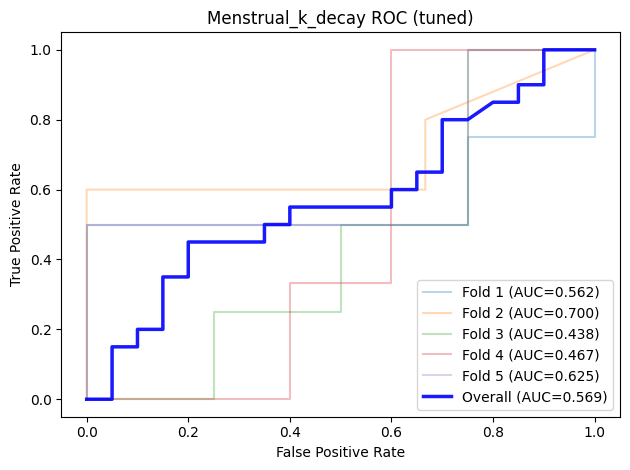

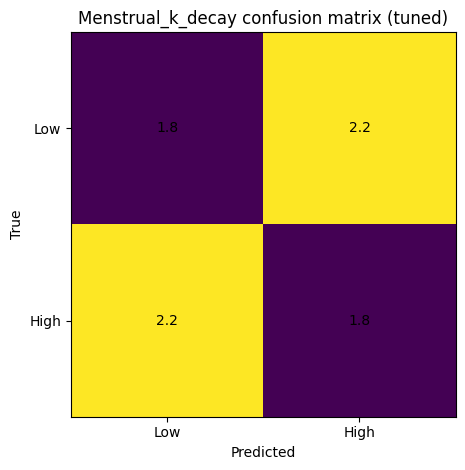

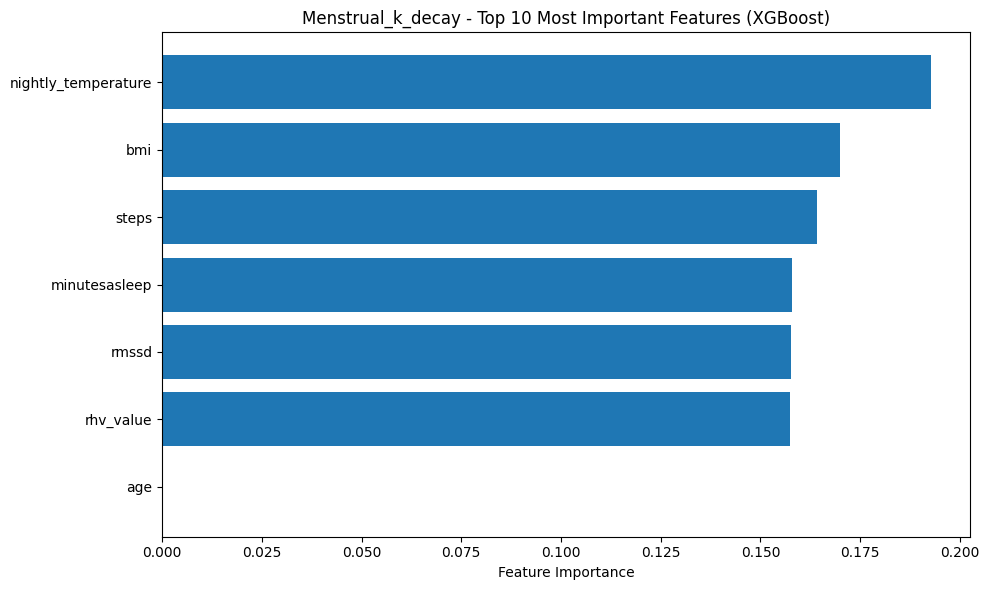


~~~~~~~~~~~~~Menstrual - cremaster_score_daily_global~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Menstrual_cremaster_score_daily_global] Best CV AUC (RandomizedSearchCV): nan
[Menstrual_cremaster_score_daily_global] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


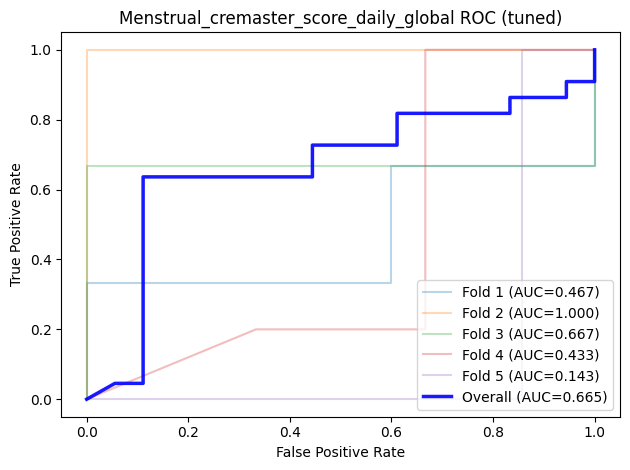

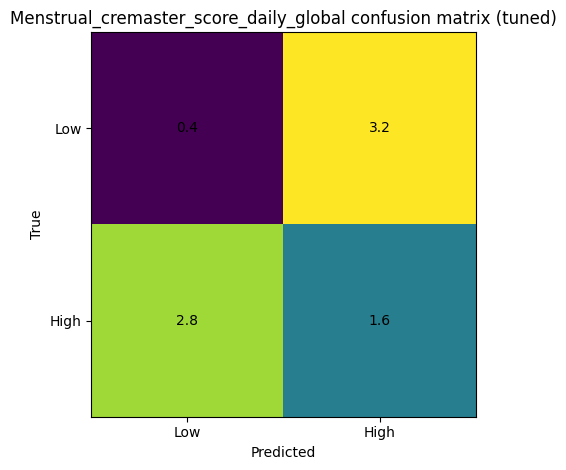

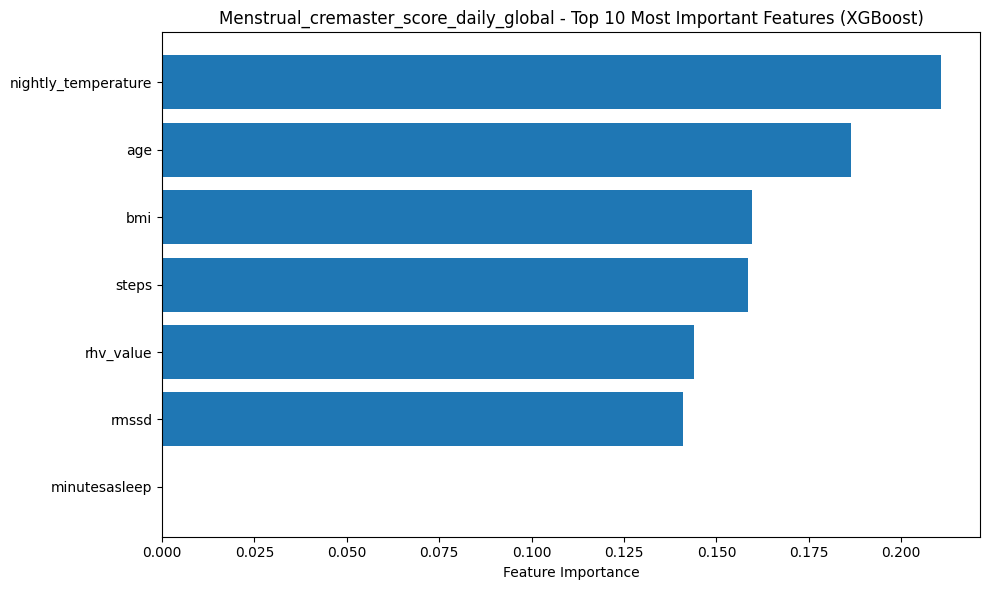


################################################################################
################################################################################
### PHASE: FERTILITY
################################################################################
################################################################################


~~~~~~~~~~~~~Fertility - daily_mean_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Fertility_daily_mean_glucose] Best CV AUC (RandomizedSearchCV): nan
[Fertility_daily_mean_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}
Fold 5: ⚠️ skipped (only one class after binning).
Fold 5: ⚠️ skipped (only one class after binning).


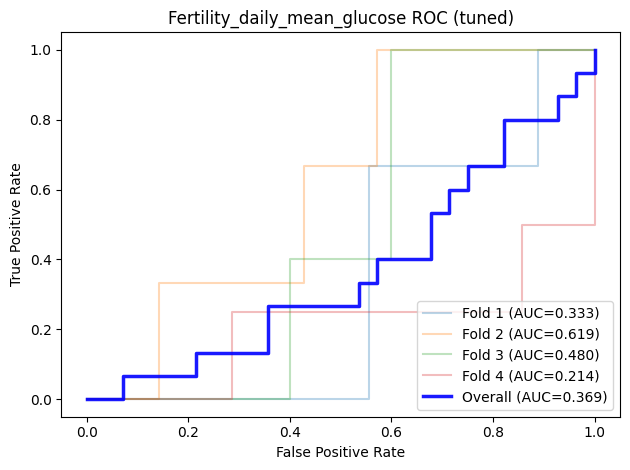

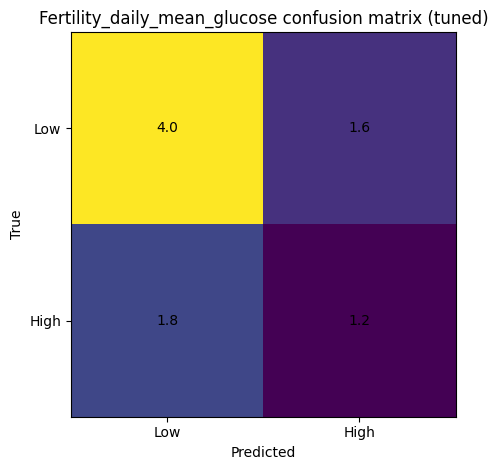

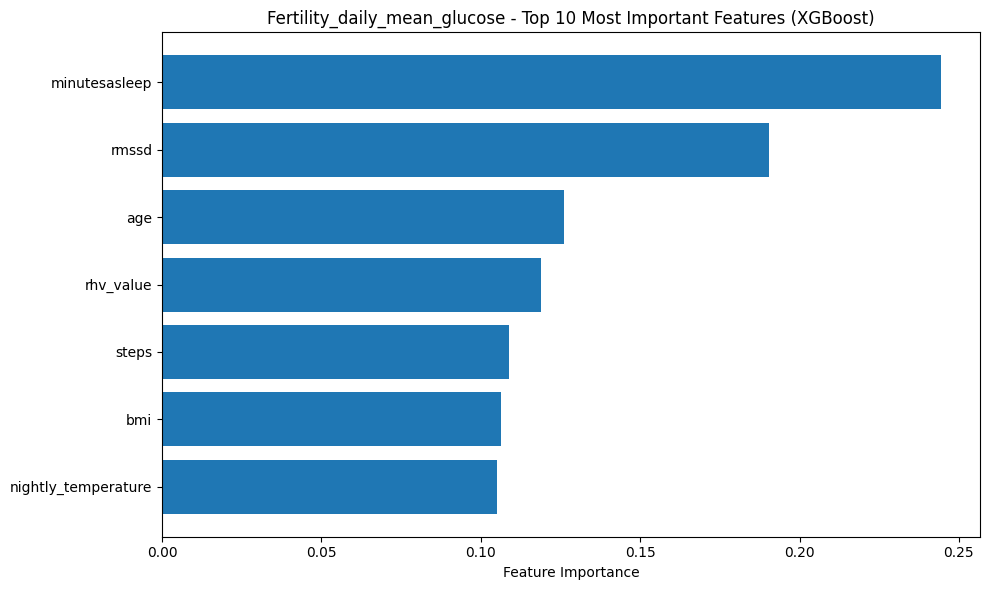


~~~~~~~~~~~~~Fertility - daily_min_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Fertility_daily_min_glucose] Best CV AUC (RandomizedSearchCV): nan
[Fertility_daily_min_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


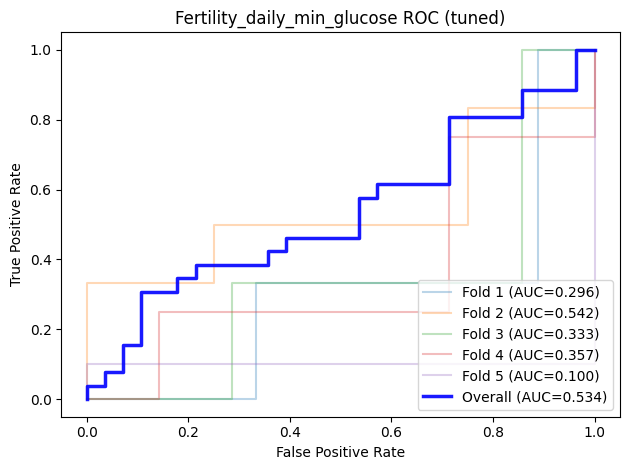

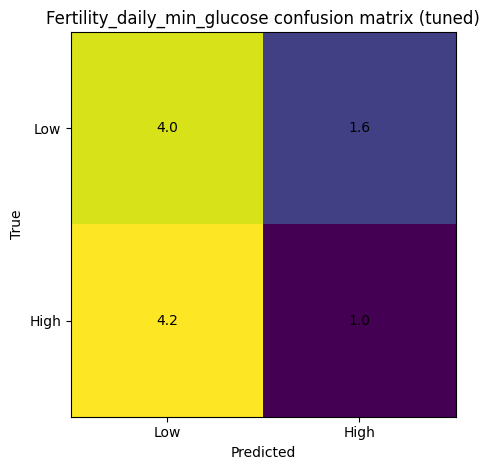

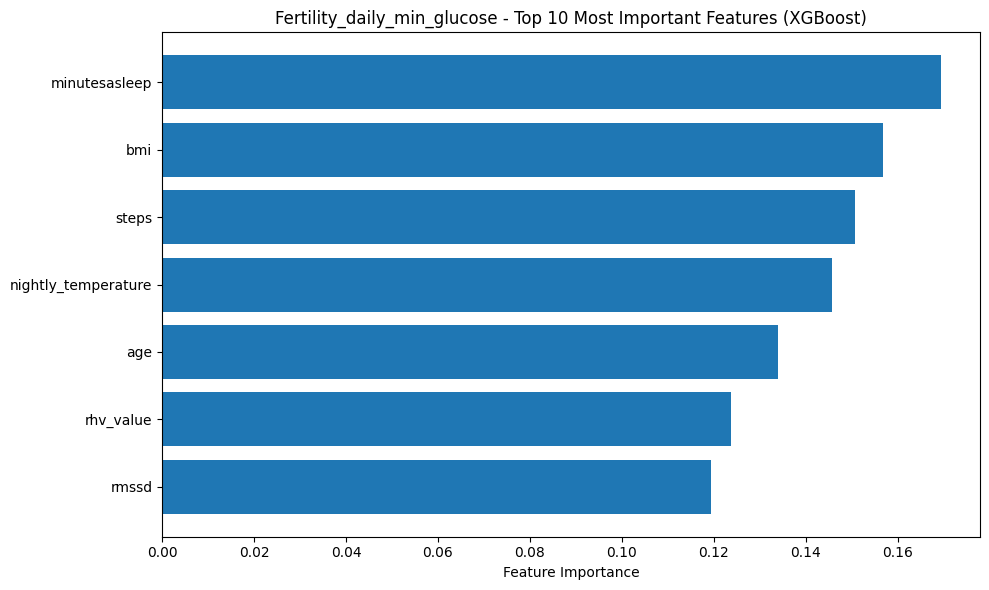


~~~~~~~~~~~~~Fertility - daily_max_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Fertility_daily_max_glucose] Best CV AUC (RandomizedSearchCV): nan
[Fertility_daily_max_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


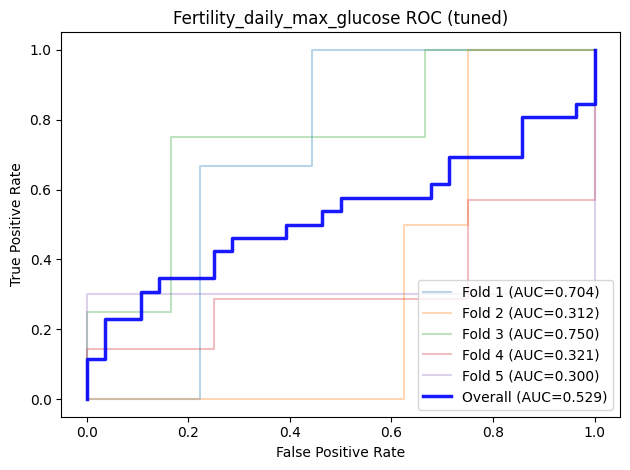

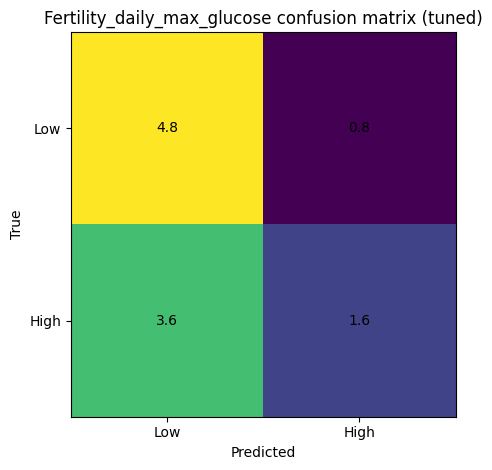

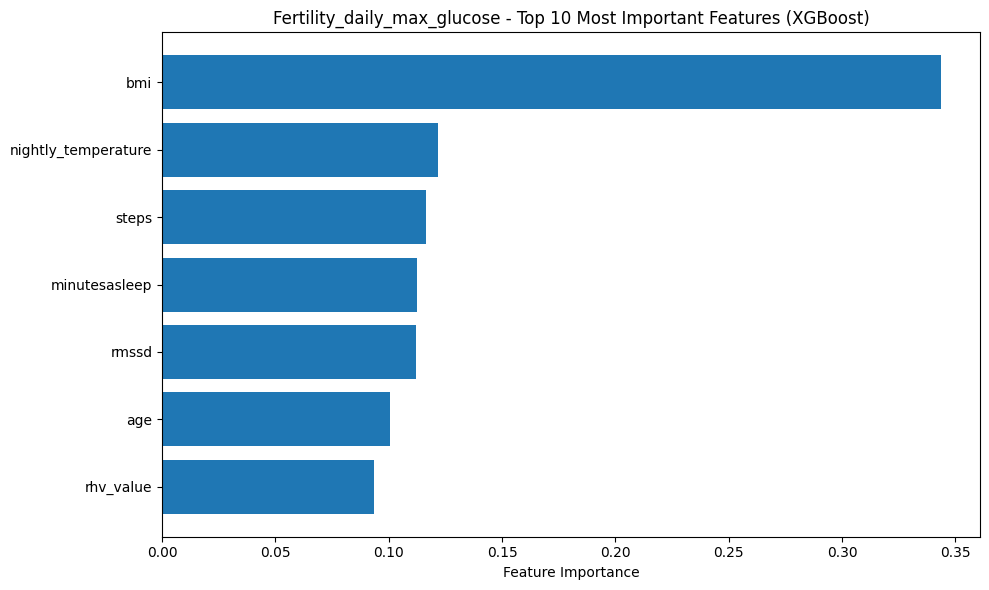


~~~~~~~~~~~~~Fertility - overnight_mean~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Fertility_overnight_mean] Best CV AUC (RandomizedSearchCV): nan
[Fertility_overnight_mean] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}
Fold 5: ⚠️ skipped (only one class after binning).
Fold 5: ⚠️ skipped (only one class after binning).


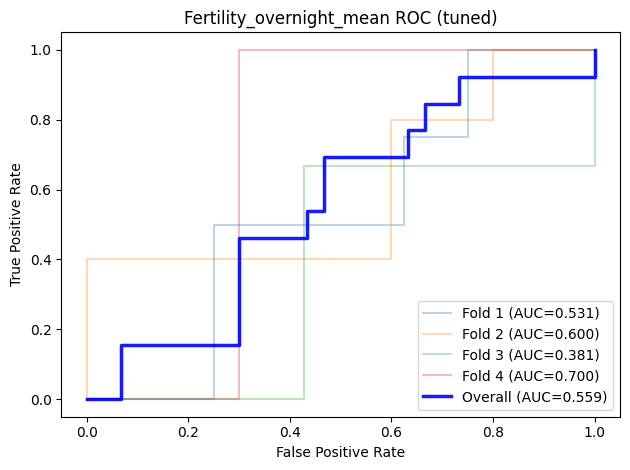

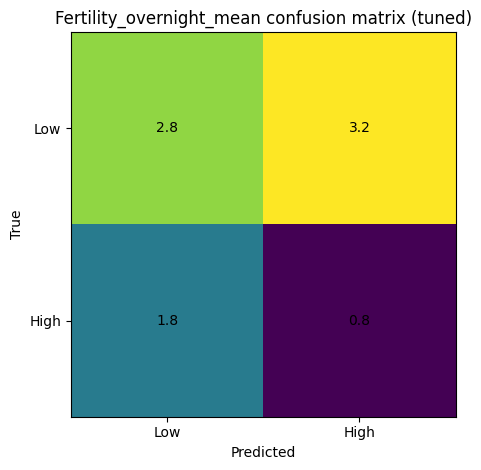

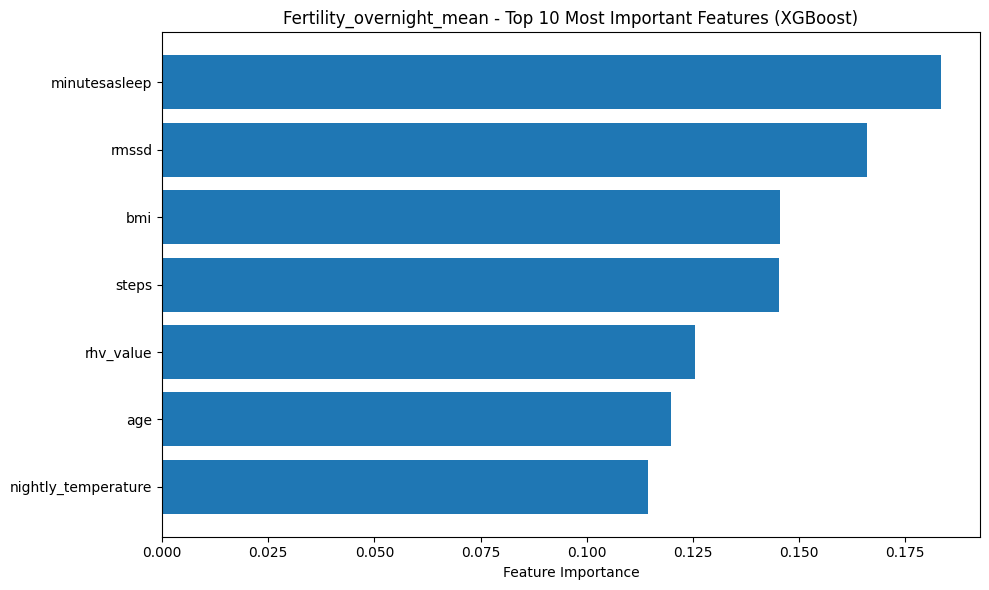


~~~~~~~~~~~~~Fertility - cv_glucose~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Fertility_cv_glucose] Best CV AUC (RandomizedSearchCV): nan
[Fertility_cv_glucose] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


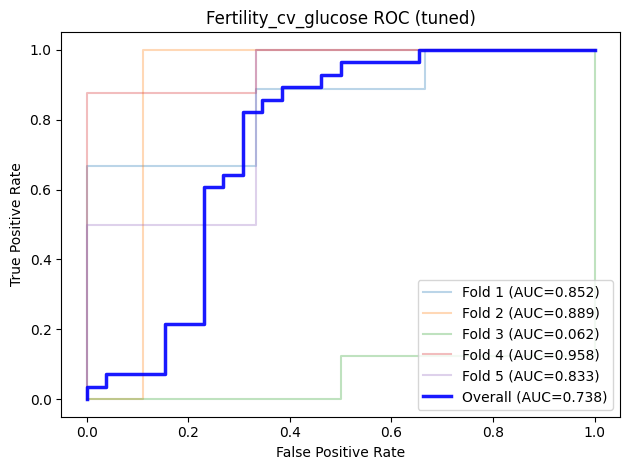

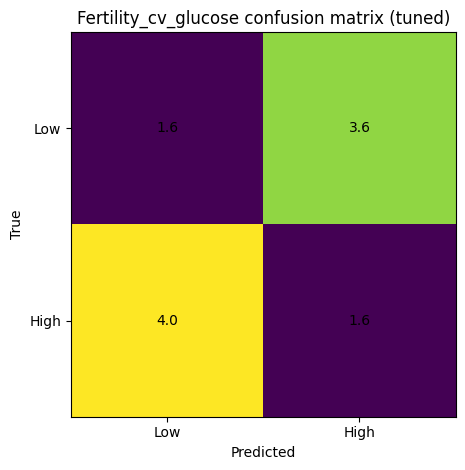

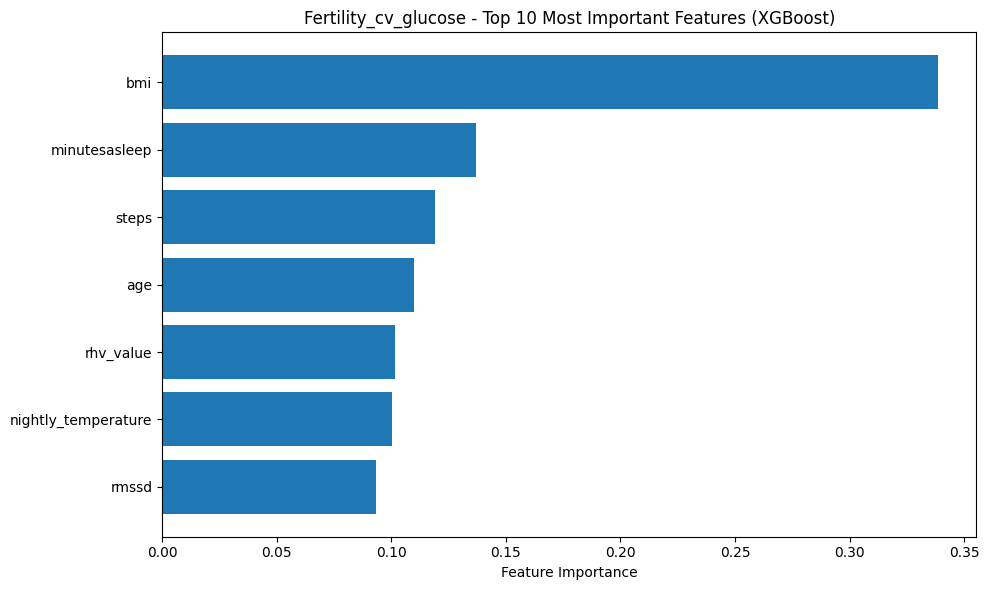


~~~~~~~~~~~~~Fertility - mage~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Fertility_mage] Best CV AUC (RandomizedSearchCV): nan
[Fertility_mage] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


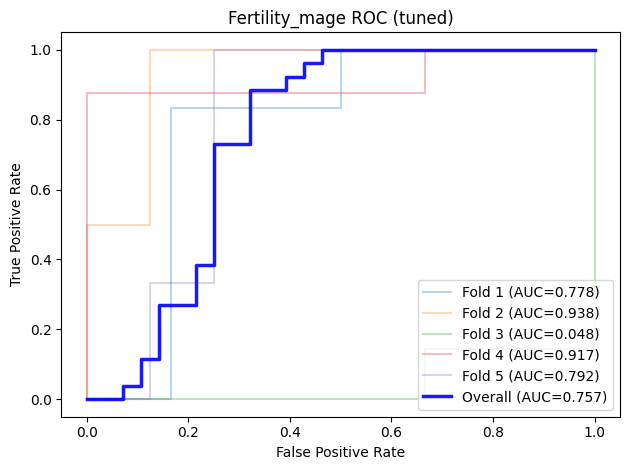

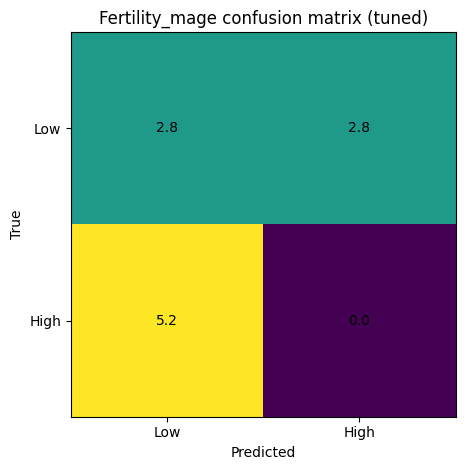

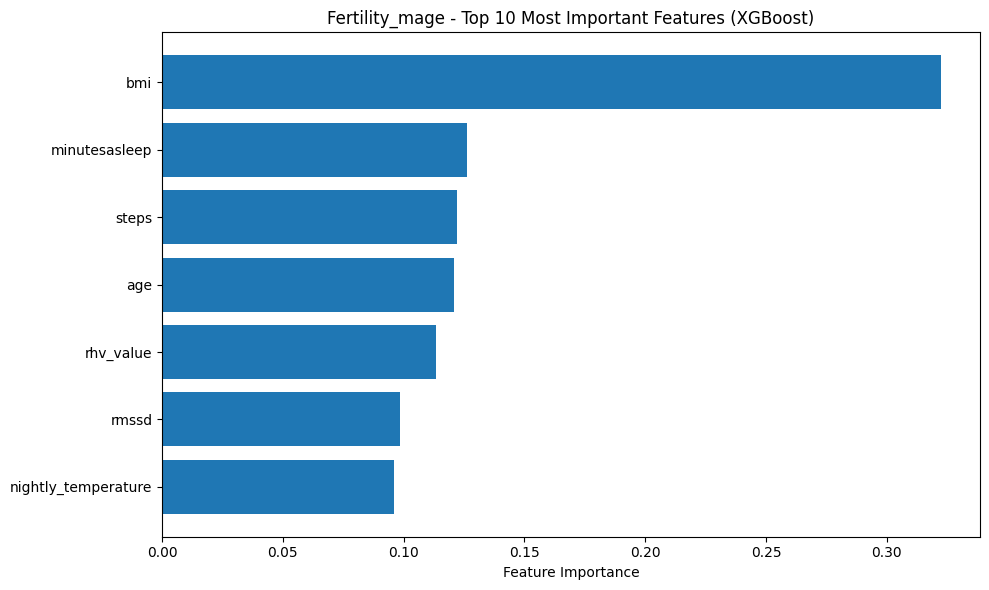


~~~~~~~~~~~~~Fertility - pp_auc_0_60~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Fertility_pp_auc_0_60] Best CV AUC (RandomizedSearchCV): nan
[Fertility_pp_auc_0_60] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


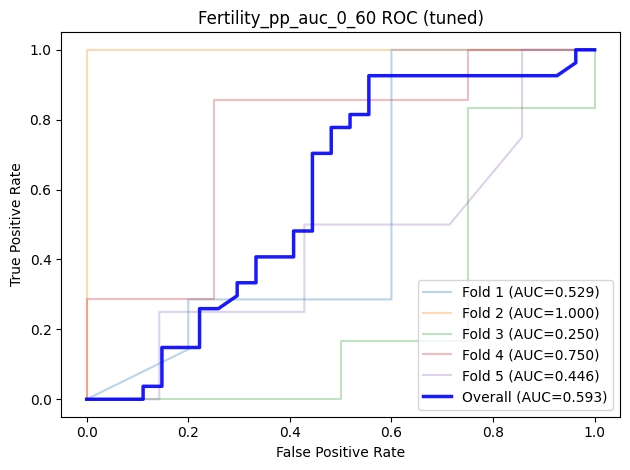

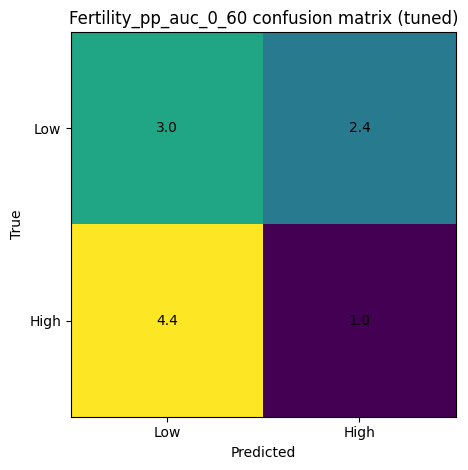

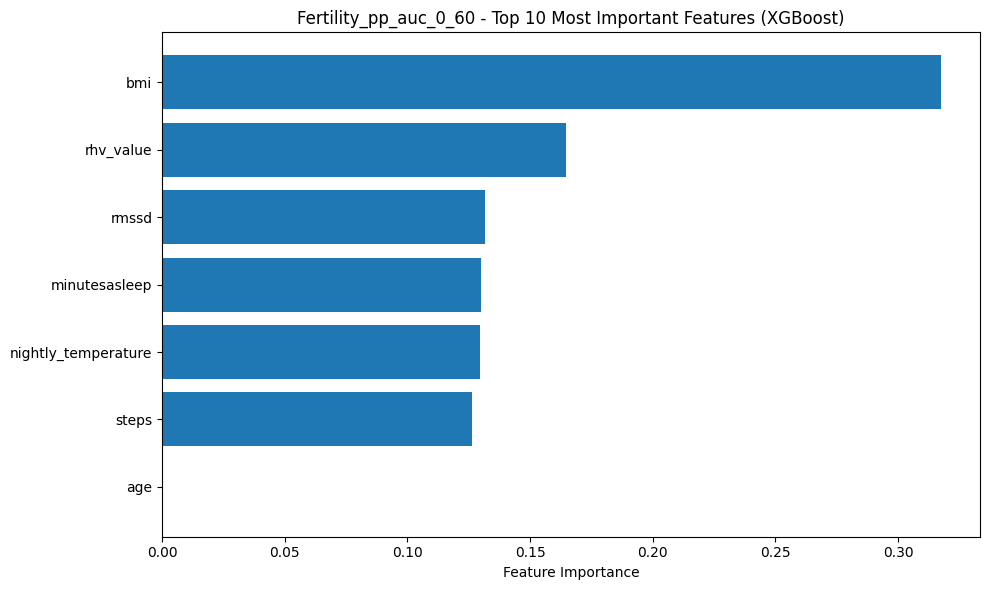


~~~~~~~~~~~~~Fertility - k_decay~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Fertility_k_decay] Best CV AUC (RandomizedSearchCV): nan
[Fertility_k_decay] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


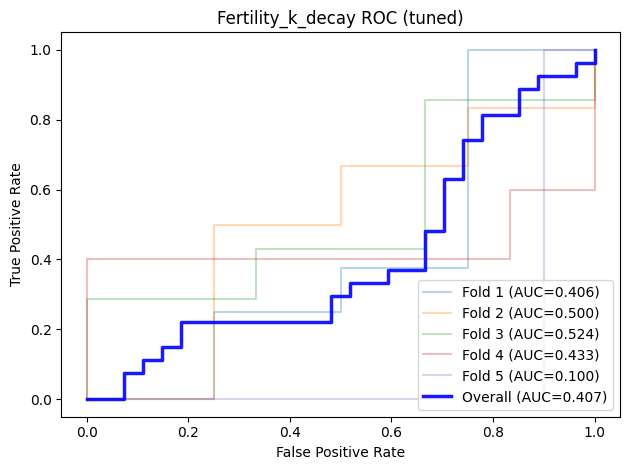

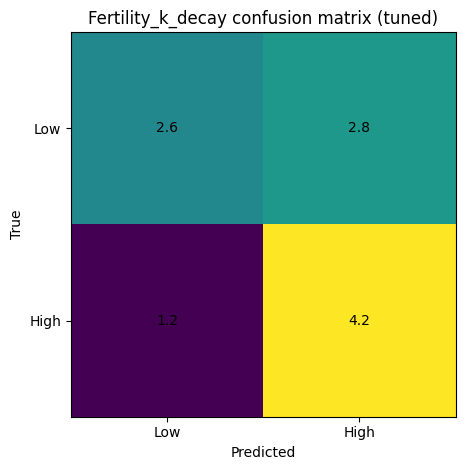

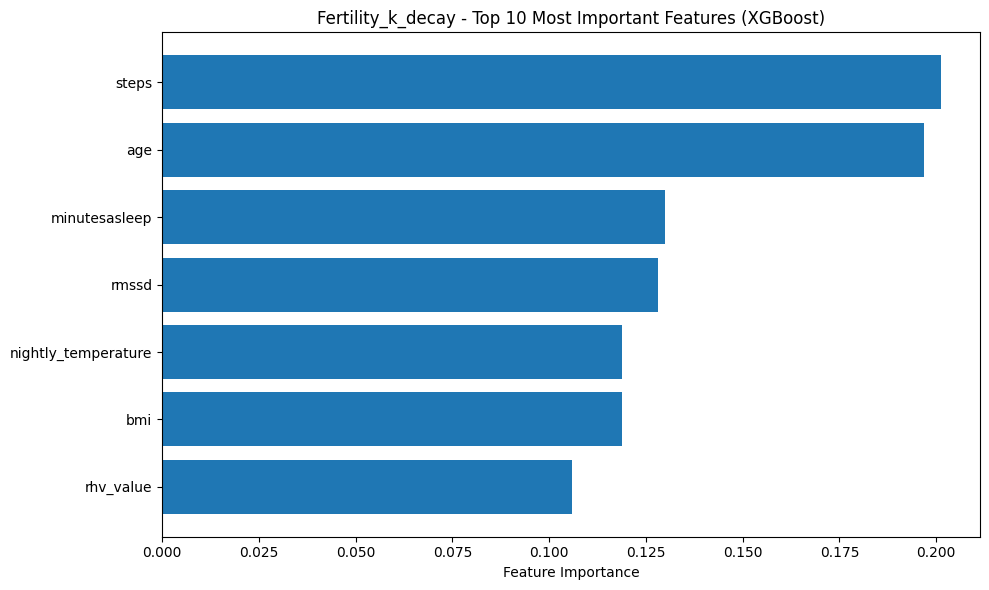


~~~~~~~~~~~~~Fertility - cremaster_score_daily_global~~~~~~~~~~~~~~~
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\carlo\miniconda3\envs\datathon.0\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(



[Fertility_cremaster_score_daily_global] Best CV AUC (RandomizedSearchCV): nan
[Fertility_cremaster_score_daily_global] Best params: {'subsample': np.float64(0.8), 'reg_lambda': np.float64(100.0), 'reg_alpha': np.float64(0.001), 'n_estimators': np.int64(500), 'min_child_weight': np.float64(0.46415888336127786), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.026366508987303583), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.8500000000000001)}


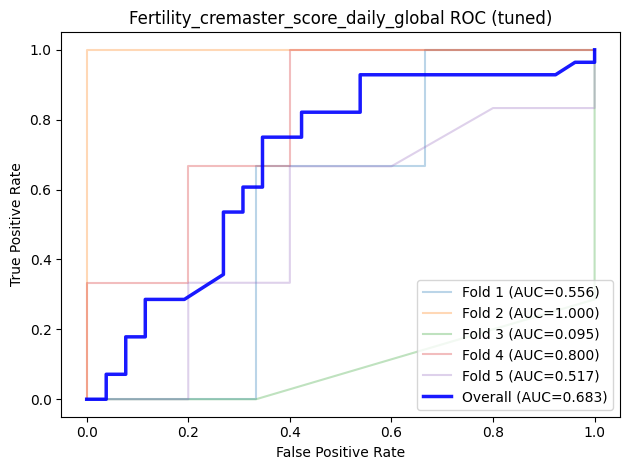

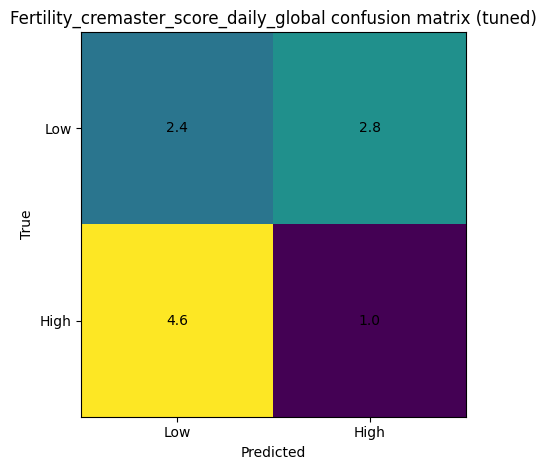

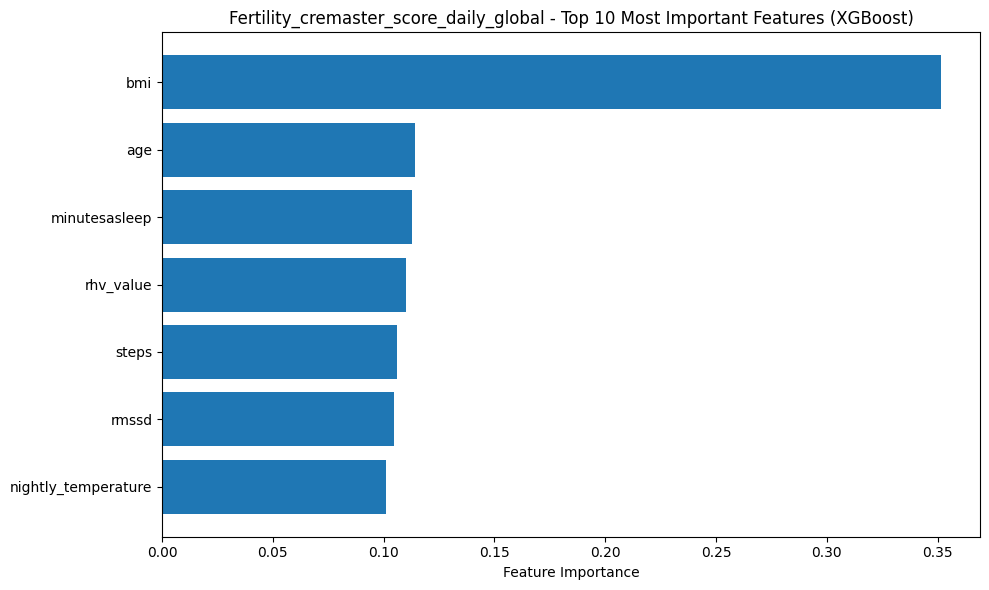


PHASE-SPECIFIC MODELING COMPLETE


In [80]:
# make this phase-specific by splitting up the dataset into phases
# Note: phase values in dataset are capitalized (Luteal, Follicular, Menstrual, Fertility)
phase_list = ['Luteal', 'Follicular', 'Menstrual', 'Fertility']

# Dictionary to store phase-specific dataframes
phase_dfs = {}

for phase in phase_list:
    # Filter train_df by phase
    phase_mask = train_df['phase'] == phase
    phase_df = train_df[phase_mask].copy()

    # Create X and y datasets for this phase
    X_phase = phase_df.drop(columns=['id', 'week', 'phase'] + irp_scores)

    # Store in dictionary
    phase_dfs[phase] = {
        'full_df': phase_df,
        'X': X_phase,
        'groups': phase_df['id'].values
    }

    # Also create y variables for each IRP score
    for score in irp_scores:
        phase_dfs[phase][f'y_{score}'] = phase_df[score].astype(float)

    print(f"\n{phase} Phase:")
    print(f"  Total samples: {len(phase_df)}")
    print(f"  Unique subjects: {phase_df['id'].nunique()}")
    print(f"  X shape: {X_phase.shape}")
    print(f"  Features: {X_phase.columns.tolist()}")

print(f"\n{'='*60}")
print(f"Total across all phases: {len(train_df)}")
print(f"Phase distribution:")
for phase in phase_list:
    pct = len(phase_dfs[phase]['full_df']) / len(train_df) * 100
    print(f"  {phase}: {len(phase_dfs[phase]['full_df'])} ({pct:.1f}%)")

# Run phase-specific models for each phase and each IRP score
phase_eval_results = {phase: [] for phase in phase_list}

for phase in phase_list:
    print(f"\n{'#'*80}")
    print(f"{'#'*80}")
    print(f"### PHASE: {phase.upper()}")
    print(f"{'#'*80}")
    print(f"{'#'*80}\n")

    # Get phase-specific data
    X_phase = phase_dfs[phase]['X']
    groups_phase = phase_dfs[phase]['groups']

    for y_name in irp_scores:
        print(f'\n~~~~~~~~~~~~~{phase} - {y_name}~~~~~~~~~~~~~~~')

        # Get y variable for this phase and score
        y_phase = phase_dfs[phase][f'y_{y_name}']

        try:
            # Run the tuned model with GroupKFold CV
            evals_cv, preprocessor, pipeline, numeric_cols, categorical_cols = get_xgboost_groupkfold(
                y_name=f"{phase}_{y_name}",
                X_train=X_phase,
                y_train=y_phase,
                groups_train=groups_phase,
                q=(0.5, 0.5),
                n_splits=min(5, len(np.unique(groups_phase))),  # Adjust n_splits based on available groups
                tune_n_iter=25,
                need_cols={"age", "bmi"}
            )

            phase_eval_results[phase].append(evals_cv)

            # Plot feature importances
            get_feature_names(f"{phase}_{y_name}", preprocessor, pipeline, numeric_cols, categorical_cols=None)

        except Exception as e:
            print(f"⚠️ Error for {phase} - {y_name}: {str(e)}")
            continue

print(f"\n{'='*80}")
print("PHASE-SPECIFIC MODELING COMPLETE")




##########################################################################################
# COMPREHENSIVE MODEL PERFORMANCE COMPARISON
# Phase-Unaware vs Phase-Aware vs Phase-Specific Models
##########################################################################################




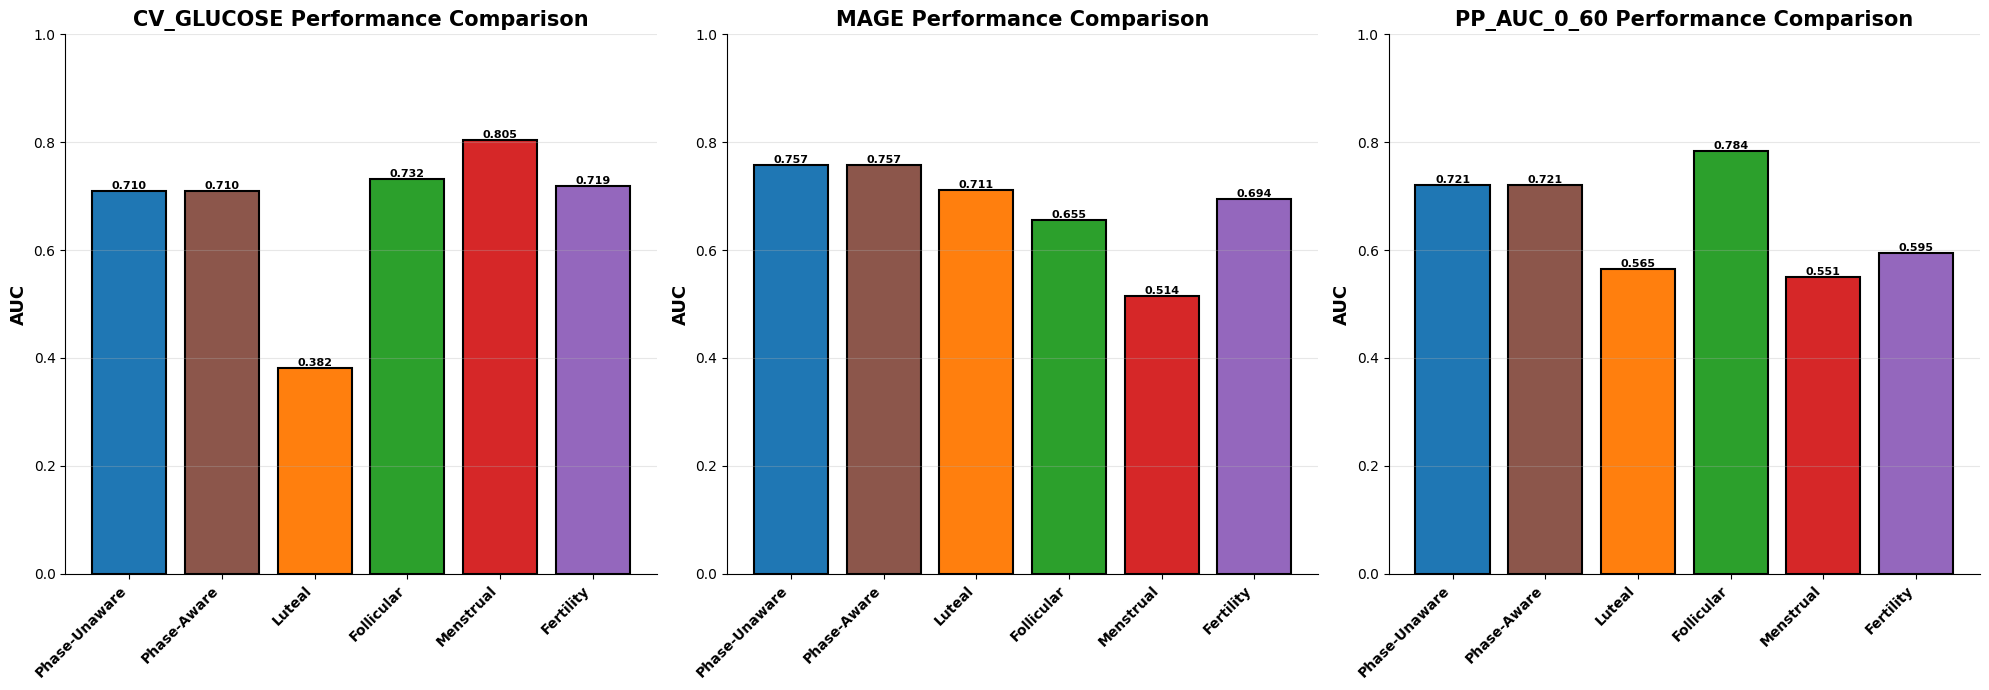


MODEL PERFORMANCE COMPARISON SUMMARY
Metric                     cv_glucose   mage  pp_auc_0_60
Model Type     Phase                                     
Phase-Aware    All              0.710  0.757        0.721
Phase-Specific Fertility        0.719  0.694        0.595
               Follicular       0.732  0.655        0.784
               Luteal           0.382  0.711        0.565
               Menstrual        0.805  0.514        0.551
Phase-Unaware  N/A              0.710  0.757        0.721


AVERAGE AUC BY MODEL TYPE:
------------------------------------------------------------------------------------------
Phase-Aware         : 0.7293
Phase-Specific      : 0.6422
Phase-Unaware       : 0.7293

AVERAGE AUC BY PHASE (Phase-Specific Models Only):
------------------------------------------------------------------------------------------
Fertility           : 0.6693
Follicular          : 0.7237
Luteal              : 0.5527
Menstrual           : 0.6233

DETAILED BREAKDOWN BY METRIC:
-

In [ ]:
def compare_model_performances(eval_cv_results_phase_unaware, eval_cv_results_phase_aware, phase_eval_results,
                               metrics=['cv_glucose', 'mage', 'pp_auc_0_60'],
                               phase_list=['Luteal', 'Follicular', 'Menstrual', 'Fertility']):
    """
    Compare AUC performance across phase-unaware, phase-aware, and phase-specific models.

    Parameters:
    -----------
    eval_cv_results_phase_unaware : list
        Results from phase-unaware model (no phase column). Each element is [y_name, accuracy, auc]
    eval_cv_results_phase_aware : list
        Results from phase-aware model (phase as a feature). Each element is [y_name, accuracy, auc]
    phase_eval_results : dict
        Dictionary with phase names as keys, each containing list of [y_name, accuracy, auc]
    metrics : list
        List of metric names to compare (e.g., ['cv_glucose', 'mage', 'pp_auc_0_60'])
    phase_list : list
        List of phase names

    Returns:
    --------
    DataFrame with comparison results
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Prepare data structure for plotting
    comparison_data = []

    # Process phase-unaware results (no phase information)
    for result in eval_cv_results_phase_unaware:
        metric_name = result[0]
        if metric_name in metrics:
            auc = result[2] if result[2] is not None else 0
            comparison_data.append({
                'Metric': metric_name,
                'Model Type': 'Phase-Unaware',
                'Phase': 'N/A',
                'AUC': auc
            })

    # Process phase-aware results (phase as a feature)
    for result in eval_cv_results_phase_aware:
        metric_name = result[0]
        if metric_name in metrics:
            auc = result[2] if result[2] is not None else 0
            comparison_data.append({
                'Metric': metric_name,
                'Model Type': 'Phase-Aware',
                'Phase': 'All',
                'AUC': auc
            })

    # Process phase-specific results (separate models per phase)
    for phase in phase_list:
        if phase in phase_eval_results:
            for result in phase_eval_results[phase]:
                # Remove phase prefix from metric name (e.g., "Luteal_cv_glucose" -> "cv_glucose")
                full_name = result[0]
                metric_name = full_name.split('_', 1)[1] if '_' in full_name else full_name

                if metric_name in metrics:
                    auc = result[2] if result[2] is not None else 0
                    comparison_data.append({
                        'Metric': metric_name,
                        'Model Type': 'Phase-Specific',
                        'Phase': phase,
                        'AUC': auc
                    })

    # Create DataFrame
    df = pd.DataFrame(comparison_data)

    # Create grouped bar chart
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    # Define color palette
    colors = sns.color_palette('tab10')

    # Color mapping for different model types and phases
    model_colors = {
        'Phase-Unaware': colors[0],   # Blue
        'Phase-Aware': colors[5],      # Brown
        'Luteal': colors[1],           # Orange
        'Follicular': colors[2],       # Green
        'Menstrual': colors[3],        # Red
        'Fertility': colors[4]         # Purple
    }

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        # Filter data for this metric
        metric_data = df[df['Metric'] == metric].copy()

        # Create custom labels combining model type and phase
        metric_data['Label'] = metric_data.apply(
            lambda row: row['Model Type'] if row['Model Type'] in ['Phase-Unaware', 'Phase-Aware']
            else row['Phase'], axis=1
        )

        # Assign colors
        metric_data['Color'] = metric_data['Label'].map(model_colors)

        # Sort for consistent ordering: Phase-Unaware, Phase-Aware, then phase-specific
        order = ['Phase-Unaware', 'Phase-Aware'] + phase_list
        metric_data['Label'] = pd.Categorical(metric_data['Label'], categories=order, ordered=True)
        metric_data = metric_data.sort_values('Label')

        # Create bar plot
        bars = ax.bar(range(len(metric_data)), metric_data['AUC'],
                      color=metric_data['Color'], edgecolor='black', linewidth=1.5)

        # Customize plot
        ax.set_xticks(range(len(metric_data)))
        ax.set_xticklabels(metric_data['Label'], rotation=45, ha='right', fontweight='bold', fontsize=10)
        ax.set_ylabel('AUC', fontweight='bold', fontsize=13)
        ax.set_title(f'{metric.upper()} Performance Comparison', fontweight='bold', fontsize=15)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for i, (bar, val) in enumerate(zip(bars, metric_data['AUC'])):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

        sns.despine(ax=ax)

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\n" + "="*90)
    print("MODEL PERFORMANCE COMPARISON SUMMARY")
    print("="*90)

    pivot_table = df.pivot_table(
        values='AUC',
        index=['Model Type', 'Phase'],
        columns='Metric',
        aggfunc='mean'
    )

    print(pivot_table.to_string())
    print("\n" + "="*90)

    # Calculate and print average performance by model type
    print("\nAVERAGE AUC BY MODEL TYPE:")
    print("-"*90)
    avg_by_model = df.groupby('Model Type')['AUC'].mean()
    for model_type, avg_auc in avg_by_model.items():
        print(f"{model_type:20s}: {avg_auc:.4f}")

    print("\nAVERAGE AUC BY PHASE (Phase-Specific Models Only):")
    print("-"*90)
    phase_specific = df[df['Model Type'] == 'Phase-Specific']
    if len(phase_specific) > 0:
        avg_by_phase = phase_specific.groupby('Phase')['AUC'].mean()
        for phase, avg_auc in avg_by_phase.items():
            print(f"{phase:20s}: {avg_auc:.4f}")

    # Print detailed breakdown by metric
    print("\nDETAILED BREAKDOWN BY METRIC:")
    print("-"*90)
    for metric in metrics:
        print(f"\n{metric.upper()}:")
        metric_subset = df[df['Metric'] == metric].copy()
        metric_subset['Label'] = metric_subset.apply(
            lambda row: row['Model Type'] if row['Model Type'] in ['Phase-Unaware', 'Phase-Aware']
            else f"{row['Model Type']}-{row['Phase']}", axis=1
        )
        for _, row in metric_subset.iterrows():
            print(f"  {row['Label']:30s}: {row['AUC']:.4f}")

    return df

# Run the comparison
print("\n\n")
print("#" * 90)
print("# COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("# Phase-Unaware vs Phase-Aware vs Phase-Specific Models")
print("#" * 90)
print("\n")

# Note: You need to have two separate eval_cv_results:
# 1. eval_cv_results from the phase-UNAWARE model (X_train without 'phase' column)
# 2. eval_cv_results from the phase-AWARE model (X_train with 'phase' column)

# Assuming you have:
# - eval_cv_results_unaware: from phase-unaware model (already computed above)
# - eval_cv_results_aware: from phase-aware model (needs to be computed if not already done)
# - phase_eval_results: from phase-specific models (already computed)

comparison_df = compare_model_performances(
    eval_cv_results_phase_unaware=eval_cv_results_phase_unaware,  # Replace with your phase-unaware results
    eval_cv_results_phase_aware=eval_cv_results_phase_aware,    # Replace with your phase-aware results (if different)
    phase_eval_results=phase_eval_results,
    metrics=['cv_glucose', 'mage', 'pp_auc_0_60'],
    phase_list=['Luteal', 'Follicular', 'Menstrual', 'Fertility']
)

In [82]:
eval_cv_results




[['daily_mean_glucose', 0.392, 0.348],
 ['daily_min_glucose', 0.509, 0.508],
 ['daily_max_glucose', 0.502, 0.614],
 ['overnight_mean', 0.443, 0.423],
 ['cv_glucose', 0.634, 0.71],
 ['mage', 0.71, 0.757],
 ['pp_auc_0_60', 0.614, 0.721],
 ['k_decay', 0.511, 0.486],
 ['cremaster_score_daily_global', 0.49, 0.661]]

In [83]:
'''
# find categorical delineartion for each cremaster score
for col in crem_scores:
  print(col)
  # compute Q1 and Q3
  q1 = merged_df[col].quantile(0.25)
  q3 = merged_df[col].quantile(0.75)

  out = pd.Series(pd.NA, index=merged_df.index, dtype="object")
  out[merged_df[col] >= q3] = "High"
  out[merged_df[col] <= q1] = "Low"
  merged_df[f"{col}_level"] = out
  '''

'\n# find categorical delineartion for each cremaster score\nfor col in crem_scores:\n  print(col)\n  # compute Q1 and Q3\n  q1 = merged_df[col].quantile(0.25)\n  q3 = merged_df[col].quantile(0.75)\n\n  out = pd.Series(pd.NA, index=merged_df.index, dtype="object")\n  out[merged_df[col] >= q3] = "High"\n  out[merged_df[col] <= q1] = "Low"\n  merged_df[f"{col}_level"] = out\n  '

# For sedentary patients
calculated as > 8 sedentary ratio:


*   total = df[["sedentary","lightly","moderately","very"]].sum(axis=1)
*   ratio = df["sedentary"] / total.replace(0, np.nan)